# HW3 Image Classification
## We strongly recommend that you run with Kaggle for this homework
https://www.kaggle.com/c/ml2022spring-hw3b/code?competitionId=34954&sortBy=dateCreated

# Get Data
Notes: if the links are dead, you can download the data directly from Kaggle and upload it to the workspace, or you can use the Kaggle API to directly download the data into colab.


In [ ]:
! wget https://www.dropbox.com/s/6l2vcvxl54b0b6w/food11.zip

In [ ]:
! unzip food11.zip

# Training

In [1]:
_exp_name = "sample"

In [2]:
# Numerical Operations
import random
import numpy as np
import math

# Reading/Writing Data
import os
import pandas as pd

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch
import torch.nn as nn
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset, random_split, SubsetRandomSampler
from torchvision.datasets import DatasetFolder, VisionDataset
import torchvision.transforms as transforms
import torchvision.models as models
from torchsummary import summary
from torch.cuda import amp

# Visualize the training information
import matplotlib.pyplot as plt

# Reading images
from PIL import Image

# For hyper-parameters searching
import optuna

# KFold Cross Validation
from sklearn.model_selection import KFold, StratifiedKFold

# Garbage Collection
import gc

# Utility Functions

In [3]:
def same_seed(seed): 
    """
    Fixes random number generator seeds for reproducibility.
    Arguments:
        seed: Numerical number.
    Returns:
        void: No return value.
    """
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

        
# For visualizing the warm up learning rate.
def warmup_lr(n_epochs,
              rise_ratio=0.25, 
              peak_ratio=0, 
              LR_START=0.00001, 
              LR_MAX=0.00005, 
              LR_MIN=0.00001, 
              LR_EXP_DECAY=0.8):
    """ Get a list of warmup learning rate. """
    LR_RISE_EPOCHS = int(n_epochs * rise_ratio)
    LR_PEAK_EPOCHS = int(n_epochs * peak_ratio)
    
    lr = []
    for epoch in range(n_epochs):
        if epoch < LR_RISE_EPOCHS:
            lr.append((LR_MAX - LR_START) / LR_RISE_EPOCHS * epoch + LR_START)
        elif epoch < LR_RISE_EPOCHS + LR_PEAK_EPOCHS:
            lr.append(LR_MAX)
        else:
            lr.append((LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RISE_EPOCHS - LR_PEAK_EPOCHS) + LR_MIN)
    plt.plot(list(range(n_epochs)), lr)
    return lr

def train_valid_split(label_paths, train_ratio, seed):
    """
    Split provided training data into training set and validation set.
    Arguments:
        label_paths : Dictionay of each label training data paths.
        train_ratio : Training ratio, range (0, 1].
        seed        : Random seed.
    Returns:
        tuple of list: 
    """
    train_path, valid_path = [], []
    for key, value in label_paths.items():
        train_set_size = int(train_ratio * len(value))
        valid_set_size = len(value) - train_set_size
        train_subset, valid_subset = random_split(value, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
        print(f"Label {key}: {len(value)} = {train_set_size} + {valid_set_size}")
        train_path += train_subset
        valid_path += valid_subset
    return train_path, valid_path

def plot_figure(train_acc, train_loss, valid_acc, valid_loss, n_epochs, **kwargs):
    """
    Plot thr accuracy and loss figures. 
    Arguments:
        train_acc : List of training accuracy.
        train_loss: List of training loss.
        valid_acc : List of validation acccuracy.
        valid_loss: List of validation loss.
        n_epochs  : Number of epochs.
        **kwargs  : Other keyword arguments.
    Returns:
        void: No return value.
    """

    # Check the length of list.
    assert len(train_acc) == n_epochs and \
           len(train_loss) == n_epochs and \
           len(valid_acc) == n_epochs and \
           len(valid_loss) == n_epochs, \
           "Length of list must match number of epoches."

    # Default keyword arguments value.
    kwargs.setdefault('loss_path', 'loss.png')
    kwargs.setdefault('acc_path', 'acc.png')

    # Loss figure
    plt.figure(figsize=(8, 6))
    plt.plot(list(range(1, n_epochs + 1)), train_loss)   # plot your training loss
    plt.plot(list(range(1, n_epochs + 1)), valid_loss)   # plot your validation loss
    plt.title('Loss')
    plt.ylabel('loss'), plt.xlabel('epoch')
    plt.legend(['training loss', 'testing loss'], loc = 'upper right')
    plt.savefig(kwargs['loss_path'])
    plt.show()

    # Accuracy figure
    plt.figure(figsize=(8, 6))
    plt.plot(list(range(1, n_epochs + 1)), train_acc)    # plot your training accuracy
    plt.plot(list(range(1, n_epochs + 1)), valid_acc)    # plot your validation accuracy
    plt.title('Accuracy')
    plt.ylabel('acc'), plt.xlabel('epoch')
    plt.legend(['training acc', 'testing acc'], loc = 'upper left')
    plt.savefig(kwargs['acc_path'])
    plt.show()

In [4]:
def get_specific_model(config, **classifier_paras):
    """
    Return a model(Fine-Tuning pre-defined model / Custom model).
    Arguments:
        config              : Configuration dictionary.
        **classifier_paras  : Classifier hyper-parameters dictionary.
    Returns:
        nn.Module: Your model.
    """
    # Use pre-defined model and can find specific pre-defined model.
    if config['pre_defined_model'] and hasattr(models, config['premodel']):
        model = getattr(models, config['premodel'])(**config['premodel_paras']).to(device)
        last_layer_name = next(reversed(model._modules))                                        # Get the name of last layer of last module.
        # print(f"{last_layer_name}: {model._modules[last_layer_name]}")                          # Glance of the name of last layer of last module..

        """ Information about last module of model. """
        fc_in_features = None                                                                   # Input features of the first layer of last module
        fc_out_features = None                                                                  # Output features of the first layer of last module

        """ Fine-tuning parameters. """
        output_dim = classifier_paras['output_dim']
        prob = classifier_paras['prob']
        hidden_layers = classifier_paras['hidden_layers']

        if config['pre_classifier']:                                                            # Use pre-defined classifier module(Fine-tuning the output classes)
            # last module is nn.Sequential
            if isinstance(model._modules[last_layer_name], nn.Sequential):
                fc_in_features = model._modules[last_layer_name][-1].in_features
                model._modules[last_layer_name][-1] = nn.Linear(fc_in_features, output_dim)
                model._modules[last_layer_name].add_module('log-soft',nn.LogSoftmax(dim=1))     # Add log-softmax layer
            # last module is nn.Linear
            else:
                fc_in_features = model._modules[last_layer_name].in_features
                model._modules[last_layer_name] = nn.Sequential(
                    nn.Linear(fc_in_features, output_dim),
                    nn.LogSoftmax(dim=1),
                )
        else:                                                                                   # Custom classifier module
            if isinstance(model._modules[last_layer_name], nn.Sequential):
                for layer in model._modules[last_layer_name]:
                    if hasattr(layer, 'in_features'):
                        fc_in_features = layer.in_features
                        fc_out_features = pow(2, int(math.log2(fc_in_features // 2)))
                        break
            else:
                fc_in_features = model._modules[last_layer_name].in_features
                fc_out_features = pow(2, int(math.log2(fc_in_features // 2)))

            """ Add custom classifier module. """
            model._modules[last_layer_name] = nn.Sequential(
                BasicBlock(fc_in_features, fc_out_features, prob),                              # First layer of classifier part
                *[BasicBlock(int(fc_out_features / pow(2, i)), int(fc_out_features / pow(2, i+1)), prob) for i in range(hidden_layers - 1)],
                nn.Linear(int(fc_out_features / pow(2, hidden_layers - 1)), output_dim),        # Last layer to propagate in output dimension
                nn.LogSoftmax(dim=1),
            )

        print(f"in_features: {fc_in_features}\nout_features: {fc_out_features}")
        model = model.to(device)                                                                # Put the model and data on the same computation device.
    # Custom model.
    else:
        model = Classifier(**config['model_paras']).to(device)                                  # Put the model and data on the same computation device.
    return model

In [5]:
def print_model(model, dataloader):
    """
    Print the model architecture.
    Arguments:
        model: Your Neural Network model.
        dataloader: Training data loader.
    Returns:
        void: No return value.
    """
    # Get the input size of training data.
    input_size = None
    for X, y in dataloader:
        input_size = X.shape[1:]        # input_size = (C, H, W)
        break

    # Pass model and the input size as parameters.
    print(model)
    summary(model, input_size)

# Ref: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
def reset_weights(model):
    """
    Reset model weights to avoid weight leakage.
    Arguments:
        model: Your Neural Network model.
    Returns:
        void: No return value.
    """
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            # print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

In [6]:
# Ref: https://github.com/facebookresearch/mixup-cifar10/blob/main/train.py
def mixup_data(x, y, alpha=1.0, device='cuda'):
    """
    Returns mixed inputs, pairs of targets, and lambda.
    Arguments:
        x      : A batch of data.
        y      : A batch of labels.
        alpha  : Beta distribution.
        device : Your device('cuda' / 'cpu').
    Returns:
        mixed_x: Mix up data(Tensor).
        y_a    : One of label.
        y_b    : The other label.
        lam    : Mixup ratio.
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]        # Get batch size.
    if device == 'cuda':            # Support cuda
        index = torch.randperm(batch_size).to(device)
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """
    Criterion for mixup data.
    Arguments:
        criterion: Loss function.
        pred     : Prediction of model.
        y_a      : One of label.
        y_b      : The other label.
        lam      : Mixup ratio.
    Returns:
        Tensor   : Loss of mixup data.
    """
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Testing Utility Functions

In [7]:
def test_time_augmentation(config, model, classes=11, alpha=0.5, numAugment=5, test_tfm=None, test_aug_tfm=None):
    """
    Test Time Augmentation.
    Arguments:
        config        : Configuration dictionary.
        model         : Your model.
        classes       : Output classes.
        alpha         : Weight of prediction without augmentation, range (0, 1].
        numAugment    : Number of augmentation times.
        test_tfm      : Testing transform.
        test_aug_tfm  : Testing transform with augmentation.
    Returns:
        Numpy array   : If use K-Fold, return the score after the weighted-sum;
                        otherwise, return the prediction.
    """

    """ Evaluation """
    model.eval()

    test_pred = np.empty((0, classes))                                  # Prediction of the test dataset without augmentation.

    # First to gain the test_loader without augmentation
    test_set = FoodDataset(os.path.join(_dataset_dir, "test"), tfm=test_tfm)
    test_loader = DataLoader(test_set, batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)

    with torch.no_grad():
        for data, _ in tqdm(test_loader):
            data = data.to(device)
            pred = model(data)
            test_pred = np.vstack((test_pred, pred.detach().cpu().numpy()))
            # # Debugging
            # for d in data:
            #     plt.figure()
            #     plt.imshow(d.detach().cpu().permute(1, 2, 0))

    print(test_pred.argmax(axis=-1))
    test_pred = test_pred * alpha                                       # Weight of prediction with outaugmentation.

    del test_set, test_loader
    gc.collect()

    # Second to gain the test_loader with augmentation
    test_set = FoodDataset(os.path.join(_dataset_dir, "test"), tfm=test_aug_tfm)
    test_loader = DataLoader(test_set, batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)

    numTestDataset = len(test_loader.sampler)                           # Number of test dtatset.
    augment_preds = np.empty((numTestDataset, classes, 0))              # Prediction of the test dataset with augmentation.

    with torch.no_grad():
        for idx in range(numAugment):
            predictions = np.empty((0, classes))
            for data, _ in tqdm(test_loader):
                data = data.to(device)
                pred = model(data)
                predictions = np.vstack((predictions, pred.detach().cpu().numpy()))
                # # Debugging
                # for d in data:
                #     plt.figure()
                #     plt.imshow(d.detach().cpu().permute(1, 2, 0))
                
            augment_preds = np.dstack((augment_preds, predictions))
 
    mean_augment_preds = np.mean(augment_preds, axis=2) * (1 - alpha)   # Weight of prediction with augmentation.
    score = test_pred + mean_augment_preds
    prediction = score.argmax(axis=-1)
    if config['k_folds'] > 0:
        return score
    return prediction

In [8]:
def ensemble_soft_voting(config, model_list=None, classes=11, **kwargs):
    """
    Soft-voting ensemble.
    Arguments:
        config        : Configuration dictionary.
        model_list    : Your model's checkpoint path list.
        classes       : Output classes.
        **kwargs      : Arguments for Test Time Augmentation.
    Returns:
        Numpy array   : Return the prediction.
    """
    
    # First to gain the test_loader without augmentation
    test_set = FoodDataset(os.path.join(_dataset_dir, "test"), tfm=test_tfm)
    test_loader = DataLoader(test_set, batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)
    
    numTestDataset = len(test_loader.sampler)                # Number of test dtatset.
    ensemble_preds = np.empty((numTestDataset, classes, 0))  # Prediction of the test dataset with augmentation.
    
    with torch.no_grad():
        for model_path in model_list:
            backbone = model_path.split('/')[-1].split('-')[1]
            fold = model_path.split('/')[-1].split('-')[-1].split('.')[0]
            print(f"{backbone}-{fold}.ckpt")
            config['premodel'] = backbone
            model = get_specific_model(config, **config['classifier_paras'])
            model.load_state_dict(torch.load(model_path))
            model.eval()
            predictions = np.empty((0, classes))
            
            if config['TTA']:
                predictions = test_time_augmentation(config, model, classes=11, **kwargs)
            else:
                for data, _ in tqdm(test_loader):
                    data = data.to(device)
                    pred = model(data)
                    predictions = np.vstack((predictions, pred.detach().cpu().numpy()))
            ensemble_preds = np.dstack((ensemble_preds, predictions))
            
            del model
            gc.collect()
            
        mean_ensemble_preds = np.mean(ensemble_preds, axis=2)
        prediction = mean_ensemble_preds.argmax(axis=-1)
    return prediction

# Trainer Function

In [9]:
def trainer(train_loader, valid_loader, model, config, device, param=None, trial=None):
    """
    Training and validation.
    Arguments:
        train_loader     : Training dataloader.
        valid_loader     : Validation dataloader.
        model            : Your model.
        config           : Configuration dictionary.
        device           : Your device('cuda' / 'cpu').
        param            : For Optuna parameters searching , default as None0
        trail            : For Optuna prune, default as None.
    Returns:
        train_acc_record : List of each epoch's training average accuracy.
        train_loss_record: List of each epoch's training average loss.
        valid_acc_record : List of each epoch's validation average accuracy.
        valid_loss_record: List of each epoch's validation average loss.
    """

    criterion = nn.CrossEntropyLoss()           # Classification task, cross-entropy as loss function.

    # If we sepcify parameters for selection of optimizer, otherwise use optimizer in config.
    if param:
        optimizer = getattr(torch.optim, param['optimizer'])(model.parameters(), **param['optim_hparas'])
    else:
        optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparas'])

    scheduler = None                            # Deafult no learning rate scheduler
    # Learning rate scheduling(Warm up / lr_scheduler privided by pytorch)
    if  config['warm_up']:
        scheduler = ScheduledOptim(optimizer, 
                                   config['n_epochs'], 
                                   rise_ratio=0.25, 
                                   peak_ratio=0, 
                                   LR_START=0.00001, 
                                   LR_MAX=0.005, 
                                   LR_MIN=0.00001, 
                                   LR_EXP_DECAY=0.99
                    )
        # First update scheduler to adjust the learning rate to initial.
        scheduler.step()
        
    if hasattr(torch.optim.lr_scheduler, config['lr_scheduler']):
        scheduler = getattr(torch.optim.lr_scheduler, config['lr_scheduler'])(optimizer, **config['lr_hparas'])

    if not os.path.isdir('./models'):
        os.mkdir('./models')                    # Create directory of saving models.

    # Initialize trackers, these are not parameters and should not be changed
    n_epochs, best_acc, stale = config['n_epochs'], 0.0, 0
    train_acc_record, train_loss_record = [], []
    valid_acc_record, valid_loss_record = [], []

    for epoch in range(n_epochs):
        # These are used to record information in training.
        train_acc, train_loss = 0.0, 0.0
        valid_acc, valid_loss = 0.0, 0.0

        """ Training """
        size = len(train_loader.sampler)        # Number of training data.
        batch_size = len(train_loader)          # Number of batches.

        model.train()                           # Set your model to training mode.

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for X, y in train_pbar:
            X, y = X.to(device), y.to(device)   # Move the dataset to the device('cpu'/'cuda') that torch assign.
            
            if config['MIXUP']:
                X, y_a, y_b, lam = mixup_data(X, y, alpha=1, device=device)
                # Compute prediction error
                pred = model(X).logits
                loss = mixup_criterion(criterion, pred, y_a, y_b, lam)
            else:
                pred = model(X).logits
                loss = criterion(pred, y)

            # Backpropagation
            optimizer.zero_grad()               # Set gradient to zero.
            loss.backward()                     # Compute gradient(backpropagate).
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)   # Clip the gradient norms for stable training.
            optimizer.step()                    # Update parameters.

            
            # Accumulate the accuracy and loss for current batch.
            if config['MIXUP']:
                train_acc += (lam * (pred.argmax(dim=-1) == y_a).float().sum().item()
                           + (1 - lam) * (pred.argmax(dim=-1) == y_b).float().sum().item())
            else:
                train_acc += (pred.argmax(dim=-1) == y).float().sum().item()
            train_loss += loss.item()

            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f"Train")

        # Compute the average loss among all batches and the accuracy of an epoch
        train_acc_record.append(train_acc / size)
        train_loss_record.append(train_loss / batch_size)

        """ Validation """
        size = len(valid_loader.sampler)    # Number of validation data.
        batch_size = len(valid_loader)      # Number of batches.

        model.eval()                        # Set your model to evaluation mode.

        # tqdm is a package to visualize your validation progress.
        valid_pbar = tqdm(valid_loader, position=0, leave=True)

        with torch.no_grad():
            # Iterate the validation set by batches.
            for X, y in valid_pbar:
                X, y = X.to(device), y.to(device)       # Move the dataset to the device('cpu'/'cuda') that torch assign.
                # X = X.half()

                # Compute prediction error
                pred = model(X)
                loss = criterion(pred, y)

                # Accumulate the accuracy and loss for current batch.
                valid_acc += (pred.argmax(dim=-1) == y).float().sum().item()
                valid_loss += loss.item()

                # Display current epoch number and loss on tqdm progress bar.
                valid_pbar.set_description(f"Valid")

            # Compute the average loss among all batches and the accuracy of an epoch
            valid_acc_record.append(valid_acc / size)
            valid_loss_record.append(valid_loss / batch_size)

        # Print the information.
        print(f"Epoch: {epoch+1:>3d} / {n_epochs:>3d}")
        print(f"\tTraining   Acc: {train_acc_record[-1]:>7f} | loss: {train_loss_record[-1]:>7f}")
        print(f"\tValidation Acc: {valid_acc_record[-1]:>7f} | loss: {valid_loss_record[-1]:>7f}")

        if scheduler:                       # Use Learning Rate Scheduler
            scheduler.step()

        # Update logs
        if valid_acc_record[-1] > best_acc:
            with open(f"./{_exp_name}_log.txt", "a"):
                print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss_record[-1]:.5f}, acc = {valid_acc_record[-1]:.5f} -> best")
        else:
            with open(f"./{_exp_name}_log.txt", "a"):
                print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss_record[-1]:.5f}, acc = {valid_acc_record[-1]:.5f}")

        # Updates the current best acc and save the best model
        if valid_acc_record[-1] > best_acc:
            best_acc = valid_acc_record[-1]
            torch.save(model.state_dict(), config['save_path'])     # Save the best model
            print(f"Saving model with acc {best_acc:0.3f}")
            stale = 0
        else:
            stale += 1
            if stale > config['patience']:
                print(f"No improvment {config['patience']} consecutive epochs, early stopping")
                break
    return train_acc_record, train_loss_record, valid_acc_record, valid_loss_record # Return the information about training & validation

# Custom Learning Rate Scheduler (Warm Up)
Reference: https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/132907dd272e2cc92e3c10e6c4e783a87ff8893d/transformer/Optim.py

In [10]:
class ScheduledOptim():
    """ A simple wrapper class for learning rate scheduling """

    def __init__(self, 
                 optimizer, 
                 n_epochs, 
                 rise_ratio=0.25, 
                 peak_ratio=0, 
                 LR_START=0.00001, 
                 LR_MAX=0.00005, 
                 LR_MIN=0.00001, 
                 LR_EXP_DECAY=0.8):
        self._optimizer = optimizer                         # Optimizer Object
        self.LR_RISE_EPOCHS = int(n_epochs * rise_ratio)    # According to the rise_ratio, decides the number of rising epochs
        self.LR_PEAK_EPOCHS = int(n_epochs * peak_ratio)    # According to the peak_ratio, decides the number of peak epochs
        self.LR_START = LR_START                            # Staring learning rate
        self.LR_MAX = LR_MAX                                # Maximum learning rate
        self.LR_MIN = LR_MIN                                # Minimum learning rate
        self.LR_EXP_DECAY = LR_EXP_DECAY                    # Exponential decay rate
        self.n_steps = 0                                    # Current update step


    def step(self):
        """ Step with the inner optimizer. """
        self._update_learning_rate()                        # Update the learning rate
        self._optimizer.step()                              # Update the optimizer


    def zero_grad(self):
        """ Zero out the gradients with the inner optimizer. """
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        """ Based on current step, calculate the learning rate. """
        if self.n_steps < self.LR_RISE_EPOCHS:
            lr = (self.LR_MAX - self.LR_START) / self.LR_RISE_EPOCHS * self.n_steps + self.LR_START
        elif self.n_steps < self.LR_RISE_EPOCHS + self.LR_PEAK_EPOCHS:
            lr = self.LR_MAX
        else:
            lr = (self.LR_MAX - self.LR_MIN) * self.LR_EXP_DECAY**(self.n_steps - self.LR_RISE_EPOCHS - self.LR_PEAK_EPOCHS) + self.LR_MIN
        print(f"Adjusting the learning rate to {lr:>7f}")
        return lr

    def _update_learning_rate(self):
        """ Learning rate scheduling per step. """

        self.n_steps += 1
        lr = self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

## **Transforms**
Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Please refer to PyTorch official website for details about different transforms.

In [11]:
# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
image_size = 256
test_tfm = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

# Policies for autoaugmentation
policies = [transforms.AutoAugmentPolicy.CIFAR10, transforms.AutoAugmentPolicy.IMAGENET]
augmenters = [transforms.AutoAugment(policy) for policy in policies]

transform_set = [
    transforms.RandomCrop((96, 96)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.5, hue=0.15),
    transforms.RandomRotation(degrees=(-30, 30)),
]

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((image_size, image_size)),
    transforms.CenterCrop((224, 224)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.ColorJitter(brightness=0.5, hue=0.1),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2)),
    # transforms.RandomRotation(degrees=(-30, 30)),
    # transforms.RandomEqualize(),
    
    # Use autoaugment
    *augmenters,

    # Use the random transform
    # transforms.RandomChoice(transform_set),
    # transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


## **Datasets**
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [12]:
class FoodDataset(Dataset):

    def __init__(self, path, tfm=test_tfm, files=None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path, x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self, idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        # im = self.data[idx]
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1              # test data has no label
        return im, label

# Model Architecture

In [13]:
# Design a block of Linear MLP(Custom fully-connected layers)
class BasicBlock(nn.Module):
    def __init__(self, input_dim, output_dim, prob=0.2):
        super(BasicBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Dropout(p=prob),
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.block(x)
        return x

In [14]:
class Classifier(nn.Module):
    def __init__(self, input_dim, output_dim, prob=0.2):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),      # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),          # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1),    # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(p=prob),
            nn.MaxPool2d(2, 2, 0),          # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1),   # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(p=prob),
            nn.MaxPool2d(2, 2, 0),          # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1),   # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(p=prob),
            nn.MaxPool2d(2, 2, 0),          # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1),   # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(p=prob),
            nn.MaxPool2d(2, 2, 0),          # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Dropout(p=prob),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=prob),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

# Configurations

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

config = {
    # Data Processing parameters.
    'k_folds': 5,                   # If k_folds is not zero, the priority is higher than train_ratio
    'train_ratio': 0.8,             # training_size = train_size * train_ratio(The rest are validation), if 0 then use default split

    # Test Time Augmentation
    'TTA': True,                    # Whether to use Test Time Augmentation
    'MIXUP': True,                  # Whether to use Mix Up

    # Training parameters.
    'seed': 5401314,                # Your seed number, you can pick your lucky number. :)
    'n_epochs': 200,                # Number of epochs
    'batch_size': 64,               # Batch size

    # Pre-defined models
    'pre_defined_model': True,      # Whether to use pre-defined model
    'pre_classifier': True,         # Whether to use classifier in pre-defined model
    'classifier_paras': {           # Custom classifier parameters
        'output_dim': 11,           # Output dimension of the model(Classes)
        'hidden_layers': 3,         # Number of hidden layers
        'prob': 0.5,                # Dropout probability
    },
    'premodel': 'googlenet',        # Specify the pre-defined model
    'premodel_paras': {             # Model parameters.
        'pretrained': False
    },
    

    # Optimizer
    'optimizer': 'Adam',            # Select optimizer
    'optim_hparas': {               # Hyper-parameters of optimizer
        'lr': 0.0003,               # Learning rate for optimizer
        'weight_decay': 1e-5        # L2 Regularization
    },
    'patience': 300,                # If no improvement in 'patience' updates, early stop

    # Learning Rate Scheduler
    'warm_up': False,               # Whether to use custom warm up learning rate scheduler, if True, ignore lr_scheduler
    'lr_scheduler': 'None',
    # 'lr_scheduler': 'SequentialLR',
    'lr_hparas': {                  # Hyper-parameters of Learning Rate Scheduler
        'T_max': 100,
        'verbose': True
    },

    'save_path': './models/model.ckpt',  # Your model will be saved here.

    # Model parameters.
    'model_paras': {
        'input_dim': 3,             # Input dimension of the model(Image channel).
        'output_dim': 11,           # Output dimension of the model(Classes)
        'prob': 0.2,                # Dropout probability
    }
}

Using cuda device


# Fetch all files' path

In [16]:
_dataset_dir = "./food11"
training_path = os.path.join(_dataset_dir, "training")
validation_path = os.path.join(_dataset_dir, "validation")
# Concatenate training and validation file paths.
files = sorted([os.path.join(training_path, x) for x in os.listdir(training_path) if x.endswith(".jpg")] +\
               [os.path.join(validation_path, x) for x in os.listdir(validation_path) if x.endswith(".jpg")])

# Dataloader (K-Fold / Custom Split / Default Folder)

In [17]:
if config['k_folds'] > 0:               # K-Fold(Cross Validation)
    print(f"{config['k_folds']}-Fold Cross Validation")
    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=config['k_folds'], shuffle=True)
    train_set = FoodDataset(os.path.join(_dataset_dir, "training"), tfm=train_tfm)
    valid_set = FoodDataset(os.path.join(_dataset_dir, "validation"), tfm=train_tfm)
    dataset = ConcatDataset([train_set, valid_set])
elif config['train_ratio'] > 0:         # Custom splitting
    print(f"Custom Splitting with train raio: {config['train_ratio']}")
    # Record all file paths for each label.
    label_paths = {}
    for file in files:
        label = int(file.split("/")[-1].split("_")[0])
        if label not in label_paths.keys():
            label_paths[label] = []
        label_paths[label].append(file)

    # Split the training and validation path.
    train_path, valid_path = train_valid_split(label_paths, config['train_ratio'], config['seed'])
    print(f"""[INFO]
Training size: {len(train_path)}
Validation size: {len(valid_path)}""")

    # Construct datasets.
    # The argument "loader" tells how torchvision reads the data.
    train_set = FoodDataset(os.path.join(_dataset_dir, "training"), tfm=train_tfm, files=train_path)
    train_loader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True)
    valid_set = FoodDataset(os.path.join(_dataset_dir, "validation"), tfm=test_tfm, files=valid_path)
    valid_loader = DataLoader(valid_set, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True)
else:                                   # Default training / validation spling
    print("Default Set")
    train_set = FoodDataset(os.path.join(_dataset_dir, "training"), tfm=train_tfm)
    train_loader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True)
    valid_set = FoodDataset(os.path.join(_dataset_dir, "validation"), tfm=test_tfm)
    valid_loader = DataLoader(valid_set, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True)

5-Fold Cross Validation
One ./food11/training sample ./food11/training/0_0.jpg
One ./food11/validation sample ./food11/validation/0_0.jpg


## Check training dataset and validation dataset in each fold (K-Fold)

In [18]:
if config['k_folds'] > 0:               # K-Fold(Cross Validation)
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(dataset)):
        print(f'FOLD {fold+1}')
        print('--------------------------------')

        # Sample elements randomly from a given list of idx, no replacement.
        train_subsampler = SubsetRandomSampler(train_idx)
        valid_subsampler = SubsetRandomSampler(valid_idx)

        # Define data loaders for training and validation data in this fold
        train_loader = DataLoader(dataset, batch_size=config['batch_size'], sampler=train_subsampler, shuffle=False, num_workers=4, pin_memory=True)
        valid_loader = DataLoader(dataset, batch_size=config['batch_size'], sampler=valid_subsampler, shuffle=False, num_workers=4, pin_memory=True)

        # INFO of training / validation dataset
        print(f"[INFO]\nTraining size: {len(train_loader.sampler)}\nValidation size: {len(valid_loader.sampler)}")
        
        # # Debugging
        # train_labels, valid_labels = {}, {}
        # for idx in train_subsampler:
        #     if dataset[idx][1] not in train_labels.keys():
        #         train_labels[dataset[idx][1]] = 0
        #     train_labels[dataset[idx][1]] += 1
        # for idx in valid_subsampler:
        #     if dataset[idx][1] not in valid_labels.keys():
        #         valid_labels[dataset[idx][1]] = 0
        #     valid_labels[dataset[idx][1]] += 1
        # print(train_labels)
        # print(valid_labels)
        
        # Remove raw feature to save memory
        del train_loader, valid_loader
        gc.collect()

FOLD 1
--------------------------------
[INFO]
Training size: 10636
Validation size: 2660
FOLD 2
--------------------------------
[INFO]
Training size: 10637
Validation size: 2659
FOLD 3
--------------------------------
[INFO]
Training size: 10637
Validation size: 2659
FOLD 4
--------------------------------
[INFO]
Training size: 10637
Validation size: 2659
FOLD 5
--------------------------------
[INFO]
Training size: 10637
Validation size: 2659


# Start training

FOLD 1
--------------------------------


/tmp3/tienyi/anaconda3/envs/MLVENV/lib/python3.8/site-packages/torchvision/models/googlenet.py:78: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '


in_features: 1024
out_features: None
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]            9408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]            9536
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]            4096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]            4224
            Conv2d-8          [-1, 192, 56, 56]          110592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]          110976
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]           12288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.85it/s]


Epoch:   1 / 200
	Training   Acc: 0.180011 | loss: 2.267763
	Validation Acc: 0.235714 | loss: 2.190896
[ Valid | 001/200 ] loss = 2.19090, acc = 0.23571 -> best
Saving model with acc 0.236


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.83it/s]


Epoch:   2 / 200
	Training   Acc: 0.209465 | loss: 2.196851
	Validation Acc: 0.245113 | loss: 2.126447
[ Valid | 002/200 ] loss = 2.12645, acc = 0.24511 -> best
Saving model with acc 0.245


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.91it/s]


Epoch:   3 / 200
	Training   Acc: 0.226910 | loss: 2.172748
	Validation Acc: 0.245113 | loss: 2.073875
[ Valid | 003/200 ] loss = 2.07387, acc = 0.24511


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.74it/s]


Epoch:   4 / 200
	Training   Acc: 0.249306 | loss: 2.124636
	Validation Acc: 0.283083 | loss: 2.035476
[ Valid | 004/200 ] loss = 2.03548, acc = 0.28308 -> best
Saving model with acc 0.283


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.05it/s]


Epoch:   5 / 200
	Training   Acc: 0.269550 | loss: 2.081316
	Validation Acc: 0.287970 | loss: 2.065762
[ Valid | 005/200 ] loss = 2.06576, acc = 0.28797 -> best
Saving model with acc 0.288


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.92it/s]


Epoch:   6 / 200
	Training   Acc: 0.283712 | loss: 2.052429
	Validation Acc: 0.342857 | loss: 1.936590
[ Valid | 006/200 ] loss = 1.93659, acc = 0.34286 -> best
Saving model with acc 0.343


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.69it/s]


Epoch:   7 / 200
	Training   Acc: 0.298388 | loss: 2.026571
	Validation Acc: 0.291353 | loss: 2.066538
[ Valid | 007/200 ] loss = 2.06654, acc = 0.29135


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.91it/s]


Epoch:   8 / 200
	Training   Acc: 0.309960 | loss: 2.000437
	Validation Acc: 0.343985 | loss: 1.849925
[ Valid | 008/200 ] loss = 1.84992, acc = 0.34398 -> best
Saving model with acc 0.344


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.79it/s]


Epoch:   9 / 200
	Training   Acc: 0.323663 | loss: 1.975716
	Validation Acc: 0.406391 | loss: 1.734781
[ Valid | 009/200 ] loss = 1.73478, acc = 0.40639 -> best
Saving model with acc 0.406


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.87it/s]


Epoch:  10 / 200
	Training   Acc: 0.340085 | loss: 1.951352
	Validation Acc: 0.420301 | loss: 1.712323
[ Valid | 010/200 ] loss = 1.71232, acc = 0.42030 -> best
Saving model with acc 0.420


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.21it/s]


Epoch:  11 / 200
	Training   Acc: 0.348463 | loss: 1.918044
	Validation Acc: 0.462030 | loss: 1.616625
[ Valid | 011/200 ] loss = 1.61662, acc = 0.46203 -> best
Saving model with acc 0.462


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.80it/s]


Epoch:  12 / 200
	Training   Acc: 0.372317 | loss: 1.874020
	Validation Acc: 0.432331 | loss: 1.656467
[ Valid | 012/200 ] loss = 1.65647, acc = 0.43233


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.78it/s]


Epoch:  13 / 200
	Training   Acc: 0.383272 | loss: 1.850218
	Validation Acc: 0.460150 | loss: 1.603987
[ Valid | 013/200 ] loss = 1.60399, acc = 0.46015


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.67it/s]


Epoch:  14 / 200
	Training   Acc: 0.388145 | loss: 1.849045
	Validation Acc: 0.449248 | loss: 1.614278
[ Valid | 014/200 ] loss = 1.61428, acc = 0.44925


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.65it/s]


Epoch:  15 / 200
	Training   Acc: 0.421036 | loss: 1.767964
	Validation Acc: 0.483083 | loss: 1.534440
[ Valid | 015/200 ] loss = 1.53444, acc = 0.48308 -> best
Saving model with acc 0.483


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.56it/s]


Epoch:  16 / 200
	Training   Acc: 0.395628 | loss: 1.812352
	Validation Acc: 0.457143 | loss: 1.584296
[ Valid | 016/200 ] loss = 1.58430, acc = 0.45714


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.38it/s]


Epoch:  17 / 200
	Training   Acc: 0.413166 | loss: 1.785515
	Validation Acc: 0.551504 | loss: 1.403327
[ Valid | 017/200 ] loss = 1.40333, acc = 0.55150 -> best
Saving model with acc 0.552


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.78it/s]


Epoch:  18 / 200
	Training   Acc: 0.422022 | loss: 1.775579
	Validation Acc: 0.505639 | loss: 1.485642
[ Valid | 018/200 ] loss = 1.48564, acc = 0.50564


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.10it/s]


Epoch:  19 / 200
	Training   Acc: 0.432543 | loss: 1.745947
	Validation Acc: 0.530827 | loss: 1.424362
[ Valid | 019/200 ] loss = 1.42436, acc = 0.53083


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.92it/s]


Epoch:  20 / 200
	Training   Acc: 0.444237 | loss: 1.718541
	Validation Acc: 0.527068 | loss: 1.409185
[ Valid | 020/200 ] loss = 1.40919, acc = 0.52707


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch:  21 / 200
	Training   Acc: 0.436049 | loss: 1.719226
	Validation Acc: 0.534962 | loss: 1.382711
[ Valid | 021/200 ] loss = 1.38271, acc = 0.53496


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.94it/s]


Epoch:  22 / 200
	Training   Acc: 0.454776 | loss: 1.693162
	Validation Acc: 0.514286 | loss: 1.448414
[ Valid | 022/200 ] loss = 1.44841, acc = 0.51429


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.34it/s]


Epoch:  23 / 200
	Training   Acc: 0.455818 | loss: 1.687129
	Validation Acc: 0.559398 | loss: 1.371082
[ Valid | 023/200 ] loss = 1.37108, acc = 0.55940 -> best
Saving model with acc 0.559


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.89it/s]


Epoch:  24 / 200
	Training   Acc: 0.468481 | loss: 1.649115
	Validation Acc: 0.529323 | loss: 1.413295
[ Valid | 024/200 ] loss = 1.41329, acc = 0.52932


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.65it/s]


Epoch:  25 / 200
	Training   Acc: 0.464543 | loss: 1.666189
	Validation Acc: 0.593985 | loss: 1.271160
[ Valid | 025/200 ] loss = 1.27116, acc = 0.59398 -> best
Saving model with acc 0.594


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.14it/s]


Epoch:  26 / 200
	Training   Acc: 0.467533 | loss: 1.659295
	Validation Acc: 0.572556 | loss: 1.305289
[ Valid | 026/200 ] loss = 1.30529, acc = 0.57256


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.83it/s]


Epoch:  27 / 200
	Training   Acc: 0.491249 | loss: 1.605267
	Validation Acc: 0.604511 | loss: 1.226509
[ Valid | 027/200 ] loss = 1.22651, acc = 0.60451 -> best
Saving model with acc 0.605


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.98it/s]


Epoch:  28 / 200
	Training   Acc: 0.494747 | loss: 1.577259
	Validation Acc: 0.554511 | loss: 1.315739
[ Valid | 028/200 ] loss = 1.31574, acc = 0.55451


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.57it/s]


Epoch:  29 / 200
	Training   Acc: 0.481163 | loss: 1.620867
	Validation Acc: 0.571429 | loss: 1.302202
[ Valid | 029/200 ] loss = 1.30220, acc = 0.57143


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.73it/s]


Epoch:  30 / 200
	Training   Acc: 0.509442 | loss: 1.556613
	Validation Acc: 0.587218 | loss: 1.255708
[ Valid | 030/200 ] loss = 1.25571, acc = 0.58722


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.96it/s]


Epoch:  31 / 200
	Training   Acc: 0.495026 | loss: 1.589120
	Validation Acc: 0.605639 | loss: 1.240391
[ Valid | 031/200 ] loss = 1.24039, acc = 0.60564 -> best
Saving model with acc 0.606


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.59it/s]


Epoch:  32 / 200
	Training   Acc: 0.497426 | loss: 1.580470
	Validation Acc: 0.581203 | loss: 1.266721
[ Valid | 032/200 ] loss = 1.26672, acc = 0.58120


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.78it/s]


Epoch:  33 / 200
	Training   Acc: 0.508164 | loss: 1.556890
	Validation Acc: 0.580827 | loss: 1.290871
[ Valid | 033/200 ] loss = 1.29087, acc = 0.58083


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.04it/s]


Epoch:  34 / 200
	Training   Acc: 0.505137 | loss: 1.579893
	Validation Acc: 0.596992 | loss: 1.234415
[ Valid | 034/200 ] loss = 1.23441, acc = 0.59699


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.03it/s]


Epoch:  35 / 200
	Training   Acc: 0.498673 | loss: 1.576267
	Validation Acc: 0.580827 | loss: 1.307332
[ Valid | 035/200 ] loss = 1.30733, acc = 0.58083


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.72it/s]


Epoch:  36 / 200
	Training   Acc: 0.512734 | loss: 1.545489
	Validation Acc: 0.613158 | loss: 1.208581
[ Valid | 036/200 ] loss = 1.20858, acc = 0.61316 -> best
Saving model with acc 0.613


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.00it/s]


Epoch:  37 / 200
	Training   Acc: 0.519290 | loss: 1.526683
	Validation Acc: 0.634586 | loss: 1.171088
[ Valid | 037/200 ] loss = 1.17109, acc = 0.63459 -> best
Saving model with acc 0.635


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.92it/s]


Epoch:  38 / 200
	Training   Acc: 0.522381 | loss: 1.514777
	Validation Acc: 0.605639 | loss: 1.211602
[ Valid | 038/200 ] loss = 1.21160, acc = 0.60564


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.42it/s]


Epoch:  39 / 200
	Training   Acc: 0.527895 | loss: 1.508663
	Validation Acc: 0.622932 | loss: 1.123640
[ Valid | 039/200 ] loss = 1.12364, acc = 0.62293


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.82it/s]


Epoch:  40 / 200
	Training   Acc: 0.531679 | loss: 1.489735
	Validation Acc: 0.619925 | loss: 1.165848
[ Valid | 040/200 ] loss = 1.16585, acc = 0.61992


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.72it/s]


Epoch:  41 / 200
	Training   Acc: 0.522937 | loss: 1.532669
	Validation Acc: 0.619549 | loss: 1.189861
[ Valid | 041/200 ] loss = 1.18986, acc = 0.61955


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.99it/s]


Epoch:  42 / 200
	Training   Acc: 0.523512 | loss: 1.527871
	Validation Acc: 0.619925 | loss: 1.192847
[ Valid | 042/200 ] loss = 1.19285, acc = 0.61992


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.01it/s]


Epoch:  43 / 200
	Training   Acc: 0.539829 | loss: 1.480841
	Validation Acc: 0.645113 | loss: 1.132000
[ Valid | 043/200 ] loss = 1.13200, acc = 0.64511 -> best
Saving model with acc 0.645


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.97it/s]


Epoch:  44 / 200
	Training   Acc: 0.535972 | loss: 1.499319
	Validation Acc: 0.640602 | loss: 1.120388
[ Valid | 044/200 ] loss = 1.12039, acc = 0.64060


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.83it/s]


Epoch:  45 / 200
	Training   Acc: 0.540037 | loss: 1.487263
	Validation Acc: 0.625564 | loss: 1.151601
[ Valid | 045/200 ] loss = 1.15160, acc = 0.62556


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.90it/s]


Epoch:  46 / 200
	Training   Acc: 0.560690 | loss: 1.424298
	Validation Acc: 0.601880 | loss: 1.195882
[ Valid | 046/200 ] loss = 1.19588, acc = 0.60188


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.06it/s]


Epoch:  47 / 200
	Training   Acc: 0.540317 | loss: 1.485173
	Validation Acc: 0.665789 | loss: 1.093241
[ Valid | 047/200 ] loss = 1.09324, acc = 0.66579 -> best
Saving model with acc 0.666


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.95it/s]


Epoch:  48 / 200
	Training   Acc: 0.546948 | loss: 1.469787
	Validation Acc: 0.620301 | loss: 1.168622
[ Valid | 048/200 ] loss = 1.16862, acc = 0.62030


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.07it/s]


Epoch:  49 / 200
	Training   Acc: 0.549575 | loss: 1.465972
	Validation Acc: 0.618421 | loss: 1.211886
[ Valid | 049/200 ] loss = 1.21189, acc = 0.61842


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.14it/s]


Epoch:  50 / 200
	Training   Acc: 0.561163 | loss: 1.426272
	Validation Acc: 0.680075 | loss: 1.017776
[ Valid | 050/200 ] loss = 1.01778, acc = 0.68008 -> best
Saving model with acc 0.680


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.01it/s]


Epoch:  51 / 200
	Training   Acc: 0.558346 | loss: 1.438456
	Validation Acc: 0.630827 | loss: 1.189768
[ Valid | 051/200 ] loss = 1.18977, acc = 0.63083


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.97it/s]


Epoch:  52 / 200
	Training   Acc: 0.543790 | loss: 1.482068
	Validation Acc: 0.628947 | loss: 1.170683
[ Valid | 052/200 ] loss = 1.17068, acc = 0.62895


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.80it/s]


Epoch:  53 / 200
	Training   Acc: 0.563152 | loss: 1.437340
	Validation Acc: 0.636090 | loss: 1.148918
[ Valid | 053/200 ] loss = 1.14892, acc = 0.63609


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.03it/s]


Epoch:  54 / 200
	Training   Acc: 0.549698 | loss: 1.459110
	Validation Acc: 0.620677 | loss: 1.159700
[ Valid | 054/200 ] loss = 1.15970, acc = 0.62068


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.84it/s]


Epoch:  55 / 200
	Training   Acc: 0.560611 | loss: 1.440374
	Validation Acc: 0.637594 | loss: 1.129757
[ Valid | 055/200 ] loss = 1.12976, acc = 0.63759


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.00it/s]


Epoch:  56 / 200
	Training   Acc: 0.573369 | loss: 1.407650
	Validation Acc: 0.643233 | loss: 1.104675
[ Valid | 056/200 ] loss = 1.10468, acc = 0.64323


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.74it/s]


Epoch:  57 / 200
	Training   Acc: 0.579364 | loss: 1.396513
	Validation Acc: 0.668045 | loss: 1.072625
[ Valid | 057/200 ] loss = 1.07263, acc = 0.66805


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.69it/s]


Epoch:  58 / 200
	Training   Acc: 0.564699 | loss: 1.422569
	Validation Acc: 0.667293 | loss: 1.065505
[ Valid | 058/200 ] loss = 1.06551, acc = 0.66729


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.03it/s]


Epoch:  59 / 200
	Training   Acc: 0.538425 | loss: 1.481685
	Validation Acc: 0.690602 | loss: 1.024998
[ Valid | 059/200 ] loss = 1.02500, acc = 0.69060 -> best
Saving model with acc 0.691


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.54it/s]


Epoch:  60 / 200
	Training   Acc: 0.568270 | loss: 1.422360
	Validation Acc: 0.656767 | loss: 1.134942
[ Valid | 060/200 ] loss = 1.13494, acc = 0.65677


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.70it/s]


Epoch:  61 / 200
	Training   Acc: 0.564749 | loss: 1.424816
	Validation Acc: 0.675188 | loss: 1.071152
[ Valid | 061/200 ] loss = 1.07115, acc = 0.67519


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.05it/s]


Epoch:  62 / 200
	Training   Acc: 0.574120 | loss: 1.410633
	Validation Acc: 0.674060 | loss: 1.070733
[ Valid | 062/200 ] loss = 1.07073, acc = 0.67406


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.08it/s]


Epoch:  63 / 200
	Training   Acc: 0.585423 | loss: 1.387830
	Validation Acc: 0.679323 | loss: 1.023241
[ Valid | 063/200 ] loss = 1.02324, acc = 0.67932


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.08it/s]


Epoch:  64 / 200
	Training   Acc: 0.584074 | loss: 1.395595
	Validation Acc: 0.684586 | loss: 1.045316
[ Valid | 064/200 ] loss = 1.04532, acc = 0.68459


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.01it/s]


Epoch:  65 / 200
	Training   Acc: 0.575269 | loss: 1.403932
	Validation Acc: 0.613534 | loss: 1.218874
[ Valid | 065/200 ] loss = 1.21887, acc = 0.61353


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.88it/s]


Epoch:  66 / 200
	Training   Acc: 0.588974 | loss: 1.370186
	Validation Acc: 0.654511 | loss: 1.120800
[ Valid | 066/200 ] loss = 1.12080, acc = 0.65451


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.88it/s]


Epoch:  67 / 200
	Training   Acc: 0.594129 | loss: 1.363262
	Validation Acc: 0.680075 | loss: 1.021306
[ Valid | 067/200 ] loss = 1.02131, acc = 0.68008


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.80it/s]


Epoch:  68 / 200
	Training   Acc: 0.589326 | loss: 1.380006
	Validation Acc: 0.656767 | loss: 1.115242
[ Valid | 068/200 ] loss = 1.11524, acc = 0.65677


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.02it/s]


Epoch:  69 / 200
	Training   Acc: 0.577982 | loss: 1.395806
	Validation Acc: 0.678195 | loss: 1.039447
[ Valid | 069/200 ] loss = 1.03945, acc = 0.67820


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.77it/s]


Epoch:  70 / 200
	Training   Acc: 0.595498 | loss: 1.356822
	Validation Acc: 0.700752 | loss: 0.951045
[ Valid | 070/200 ] loss = 0.95105, acc = 0.70075 -> best
Saving model with acc 0.701


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.95it/s]


Epoch:  71 / 200
	Training   Acc: 0.594958 | loss: 1.363272
	Validation Acc: 0.681955 | loss: 1.009815
[ Valid | 071/200 ] loss = 1.00981, acc = 0.68195


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.93it/s]


Epoch:  72 / 200
	Training   Acc: 0.593916 | loss: 1.373473
	Validation Acc: 0.692105 | loss: 1.029122
[ Valid | 072/200 ] loss = 1.02912, acc = 0.69211


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.77it/s]


Epoch:  73 / 200
	Training   Acc: 0.589319 | loss: 1.366970
	Validation Acc: 0.677444 | loss: 1.061133
[ Valid | 073/200 ] loss = 1.06113, acc = 0.67744


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.44it/s]


Epoch:  74 / 200
	Training   Acc: 0.595070 | loss: 1.354129
	Validation Acc: 0.690226 | loss: 1.009751
[ Valid | 074/200 ] loss = 1.00975, acc = 0.69023


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.51it/s]


Epoch:  75 / 200
	Training   Acc: 0.597726 | loss: 1.353602
	Validation Acc: 0.714662 | loss: 0.942312
[ Valid | 075/200 ] loss = 0.94231, acc = 0.71466 -> best
Saving model with acc 0.715


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.03it/s]


Epoch:  76 / 200
	Training   Acc: 0.597518 | loss: 1.361842
	Validation Acc: 0.704511 | loss: 0.982776
[ Valid | 076/200 ] loss = 0.98278, acc = 0.70451


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.93it/s]


Epoch:  77 / 200
	Training   Acc: 0.600415 | loss: 1.346710
	Validation Acc: 0.665789 | loss: 1.073582
[ Valid | 077/200 ] loss = 1.07358, acc = 0.66579


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.72it/s]


Epoch:  78 / 200
	Training   Acc: 0.603824 | loss: 1.337106
	Validation Acc: 0.675188 | loss: 1.059430
[ Valid | 078/200 ] loss = 1.05943, acc = 0.67519


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.95it/s]


Epoch:  79 / 200
	Training   Acc: 0.603394 | loss: 1.339130
	Validation Acc: 0.677820 | loss: 1.033229
[ Valid | 079/200 ] loss = 1.03323, acc = 0.67782


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.30it/s]


Epoch:  80 / 200
	Training   Acc: 0.603576 | loss: 1.318971
	Validation Acc: 0.701128 | loss: 0.948669
[ Valid | 080/200 ] loss = 0.94867, acc = 0.70113


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.74it/s]


Epoch:  81 / 200
	Training   Acc: 0.604201 | loss: 1.331469
	Validation Acc: 0.690602 | loss: 1.016208
[ Valid | 081/200 ] loss = 1.01621, acc = 0.69060


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.76it/s]


Epoch:  82 / 200
	Training   Acc: 0.609790 | loss: 1.306435
	Validation Acc: 0.698120 | loss: 0.996235
[ Valid | 082/200 ] loss = 0.99624, acc = 0.69812


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.42it/s]


Epoch:  83 / 200
	Training   Acc: 0.615426 | loss: 1.310679
	Validation Acc: 0.696992 | loss: 0.962771
[ Valid | 083/200 ] loss = 0.96277, acc = 0.69699


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.81it/s]


Epoch:  84 / 200
	Training   Acc: 0.619830 | loss: 1.284016
	Validation Acc: 0.707143 | loss: 0.957149
[ Valid | 084/200 ] loss = 0.95715, acc = 0.70714


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.81it/s]


Epoch:  85 / 200
	Training   Acc: 0.623665 | loss: 1.298312
	Validation Acc: 0.684586 | loss: 1.027870
[ Valid | 085/200 ] loss = 1.02787, acc = 0.68459


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.75it/s]


Epoch:  86 / 200
	Training   Acc: 0.606412 | loss: 1.331535
	Validation Acc: 0.689850 | loss: 1.020127
[ Valid | 086/200 ] loss = 1.02013, acc = 0.68985


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.38it/s]


Epoch:  87 / 200
	Training   Acc: 0.626391 | loss: 1.276990
	Validation Acc: 0.691353 | loss: 1.032123
[ Valid | 087/200 ] loss = 1.03212, acc = 0.69135


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.81it/s]


Epoch:  88 / 200
	Training   Acc: 0.628324 | loss: 1.266139
	Validation Acc: 0.636090 | loss: 1.148327
[ Valid | 088/200 ] loss = 1.14833, acc = 0.63609


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.69it/s]


Epoch:  89 / 200
	Training   Acc: 0.602941 | loss: 1.346976
	Validation Acc: 0.700000 | loss: 0.995258
[ Valid | 089/200 ] loss = 0.99526, acc = 0.70000


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.74it/s]


Epoch:  90 / 200
	Training   Acc: 0.619458 | loss: 1.306549
	Validation Acc: 0.681203 | loss: 1.028145
[ Valid | 090/200 ] loss = 1.02815, acc = 0.68120


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.95it/s]


Epoch:  91 / 200
	Training   Acc: 0.612760 | loss: 1.314668
	Validation Acc: 0.703759 | loss: 1.001508
[ Valid | 091/200 ] loss = 1.00151, acc = 0.70376


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.05it/s]


Epoch:  92 / 200
	Training   Acc: 0.617507 | loss: 1.312956
	Validation Acc: 0.679699 | loss: 1.020449
[ Valid | 092/200 ] loss = 1.02045, acc = 0.67970


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.80it/s]


Epoch:  93 / 200
	Training   Acc: 0.597021 | loss: 1.351840
	Validation Acc: 0.696992 | loss: 1.036936
[ Valid | 093/200 ] loss = 1.03694, acc = 0.69699


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.06it/s]


Epoch:  94 / 200
	Training   Acc: 0.629981 | loss: 1.277992
	Validation Acc: 0.688346 | loss: 1.040599
[ Valid | 094/200 ] loss = 1.04060, acc = 0.68835


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.65it/s]


Epoch:  95 / 200
	Training   Acc: 0.632339 | loss: 1.277182
	Validation Acc: 0.731955 | loss: 0.908298
[ Valid | 095/200 ] loss = 0.90830, acc = 0.73195 -> best
Saving model with acc 0.732


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.83it/s]


Epoch:  96 / 200
	Training   Acc: 0.625557 | loss: 1.297114
	Validation Acc: 0.684586 | loss: 1.024639
[ Valid | 096/200 ] loss = 1.02464, acc = 0.68459


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.78it/s]


Epoch:  97 / 200
	Training   Acc: 0.622649 | loss: 1.296291
	Validation Acc: 0.684962 | loss: 0.996683
[ Valid | 097/200 ] loss = 0.99668, acc = 0.68496


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.66it/s]


Epoch:  98 / 200
	Training   Acc: 0.624634 | loss: 1.275517
	Validation Acc: 0.691353 | loss: 0.991549
[ Valid | 098/200 ] loss = 0.99155, acc = 0.69135


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.47it/s]


Epoch:  99 / 200
	Training   Acc: 0.618719 | loss: 1.304405
	Validation Acc: 0.684962 | loss: 1.019736
[ Valid | 099/200 ] loss = 1.01974, acc = 0.68496


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.95it/s]


Epoch: 100 / 200
	Training   Acc: 0.633238 | loss: 1.274047
	Validation Acc: 0.695113 | loss: 0.998858
[ Valid | 100/200 ] loss = 0.99886, acc = 0.69511


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.43it/s]


Epoch: 101 / 200
	Training   Acc: 0.627213 | loss: 1.289043
	Validation Acc: 0.710150 | loss: 0.986303
[ Valid | 101/200 ] loss = 0.98630, acc = 0.71015


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.87it/s]


Epoch: 102 / 200
	Training   Acc: 0.625084 | loss: 1.295778
	Validation Acc: 0.714662 | loss: 0.935735
[ Valid | 102/200 ] loss = 0.93573, acc = 0.71466


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.82it/s]


Epoch: 103 / 200
	Training   Acc: 0.611073 | loss: 1.322705
	Validation Acc: 0.698872 | loss: 1.000128
[ Valid | 103/200 ] loss = 1.00013, acc = 0.69887


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.06it/s]


Epoch: 104 / 200
	Training   Acc: 0.619349 | loss: 1.296559
	Validation Acc: 0.697368 | loss: 0.957708
[ Valid | 104/200 ] loss = 0.95771, acc = 0.69737


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.00it/s]


Epoch: 105 / 200
	Training   Acc: 0.616379 | loss: 1.303372
	Validation Acc: 0.706391 | loss: 1.009914
[ Valid | 105/200 ] loss = 1.00991, acc = 0.70639


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.08it/s]


Epoch: 106 / 200
	Training   Acc: 0.626772 | loss: 1.283741
	Validation Acc: 0.705639 | loss: 0.950293
[ Valid | 106/200 ] loss = 0.95029, acc = 0.70564


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.71it/s]


Epoch: 107 / 200
	Training   Acc: 0.639723 | loss: 1.248763
	Validation Acc: 0.733459 | loss: 0.892672
[ Valid | 107/200 ] loss = 0.89267, acc = 0.73346 -> best
Saving model with acc 0.733


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.47it/s]


Epoch: 108 / 200
	Training   Acc: 0.625993 | loss: 1.269625
	Validation Acc: 0.692857 | loss: 1.002286
[ Valid | 108/200 ] loss = 1.00229, acc = 0.69286


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.85it/s]


Epoch: 109 / 200
	Training   Acc: 0.633411 | loss: 1.257016
	Validation Acc: 0.671805 | loss: 1.038545
[ Valid | 109/200 ] loss = 1.03855, acc = 0.67180


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.82it/s]


Epoch: 110 / 200
	Training   Acc: 0.640720 | loss: 1.242387
	Validation Acc: 0.694361 | loss: 0.987966
[ Valid | 110/200 ] loss = 0.98797, acc = 0.69436


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.57it/s]


Epoch: 111 / 200
	Training   Acc: 0.637247 | loss: 1.245003
	Validation Acc: 0.734962 | loss: 0.865561
[ Valid | 111/200 ] loss = 0.86556, acc = 0.73496 -> best
Saving model with acc 0.735


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.72it/s]


Epoch: 112 / 200
	Training   Acc: 0.635679 | loss: 1.250436
	Validation Acc: 0.700376 | loss: 1.006216
[ Valid | 112/200 ] loss = 1.00622, acc = 0.70038


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.46it/s]


Epoch: 113 / 200
	Training   Acc: 0.635018 | loss: 1.265393
	Validation Acc: 0.731579 | loss: 0.902832
[ Valid | 113/200 ] loss = 0.90283, acc = 0.73158


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.70it/s]


Epoch: 114 / 200
	Training   Acc: 0.646045 | loss: 1.239552
	Validation Acc: 0.704511 | loss: 0.984254
[ Valid | 114/200 ] loss = 0.98425, acc = 0.70451


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.43it/s]


Epoch: 115 / 200
	Training   Acc: 0.637127 | loss: 1.268262
	Validation Acc: 0.710150 | loss: 0.990240
[ Valid | 115/200 ] loss = 0.99024, acc = 0.71015


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.97it/s]


Epoch: 116 / 200
	Training   Acc: 0.642136 | loss: 1.243410
	Validation Acc: 0.718045 | loss: 0.916604
[ Valid | 116/200 ] loss = 0.91660, acc = 0.71805


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.09it/s]


Epoch: 117 / 200
	Training   Acc: 0.628210 | loss: 1.286237
	Validation Acc: 0.720677 | loss: 0.936105
[ Valid | 117/200 ] loss = 0.93611, acc = 0.72068


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch: 118 / 200
	Training   Acc: 0.622049 | loss: 1.288617
	Validation Acc: 0.704887 | loss: 1.000182
[ Valid | 118/200 ] loss = 1.00018, acc = 0.70489


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.74it/s]


Epoch: 119 / 200
	Training   Acc: 0.651102 | loss: 1.230107
	Validation Acc: 0.713534 | loss: 0.986001
[ Valid | 119/200 ] loss = 0.98600, acc = 0.71353


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.29it/s]


Epoch: 120 / 200
	Training   Acc: 0.632251 | loss: 1.271717
	Validation Acc: 0.715789 | loss: 0.961600
[ Valid | 120/200 ] loss = 0.96160, acc = 0.71579


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.72it/s]


Epoch: 121 / 200
	Training   Acc: 0.623704 | loss: 1.291787
	Validation Acc: 0.701880 | loss: 0.941722
[ Valid | 121/200 ] loss = 0.94172, acc = 0.70188


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.17it/s]


Epoch: 122 / 200
	Training   Acc: 0.636705 | loss: 1.258105
	Validation Acc: 0.676316 | loss: 1.036392
[ Valid | 122/200 ] loss = 1.03639, acc = 0.67632


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.33it/s]


Epoch: 123 / 200
	Training   Acc: 0.641374 | loss: 1.247532
	Validation Acc: 0.693609 | loss: 0.998196
[ Valid | 123/200 ] loss = 0.99820, acc = 0.69361


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.76it/s]


Epoch: 124 / 200
	Training   Acc: 0.636477 | loss: 1.268759
	Validation Acc: 0.713158 | loss: 0.931907
[ Valid | 124/200 ] loss = 0.93191, acc = 0.71316


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.84it/s]


Epoch: 125 / 200
	Training   Acc: 0.645021 | loss: 1.238398
	Validation Acc: 0.723308 | loss: 0.932766
[ Valid | 125/200 ] loss = 0.93277, acc = 0.72331


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.06it/s]


Epoch: 126 / 200
	Training   Acc: 0.655627 | loss: 1.213467
	Validation Acc: 0.687218 | loss: 1.054703
[ Valid | 126/200 ] loss = 1.05470, acc = 0.68722


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  7.00it/s]


Epoch: 127 / 200
	Training   Acc: 0.626401 | loss: 1.290410
	Validation Acc: 0.679323 | loss: 1.042632
[ Valid | 127/200 ] loss = 1.04263, acc = 0.67932


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.32it/s]


Epoch: 128 / 200
	Training   Acc: 0.637929 | loss: 1.253115
	Validation Acc: 0.689474 | loss: 1.001175
[ Valid | 128/200 ] loss = 1.00118, acc = 0.68947


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.71it/s]


Epoch: 129 / 200
	Training   Acc: 0.636889 | loss: 1.269602
	Validation Acc: 0.726316 | loss: 0.931311
[ Valid | 129/200 ] loss = 0.93131, acc = 0.72632


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.74it/s]


Epoch: 130 / 200
	Training   Acc: 0.632049 | loss: 1.261160
	Validation Acc: 0.713534 | loss: 0.945260
[ Valid | 130/200 ] loss = 0.94526, acc = 0.71353


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.07it/s]


Epoch: 131 / 200
	Training   Acc: 0.629551 | loss: 1.266692
	Validation Acc: 0.688346 | loss: 1.018934
[ Valid | 131/200 ] loss = 1.01893, acc = 0.68835


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  7.00it/s]


Epoch: 132 / 200
	Training   Acc: 0.649083 | loss: 1.233415
	Validation Acc: 0.730075 | loss: 0.938448
[ Valid | 132/200 ] loss = 0.93845, acc = 0.73008


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.39it/s]


Epoch: 133 / 200
	Training   Acc: 0.657430 | loss: 1.210111
	Validation Acc: 0.703759 | loss: 0.987716
[ Valid | 133/200 ] loss = 0.98772, acc = 0.70376


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.53it/s]


Epoch: 134 / 200
	Training   Acc: 0.641795 | loss: 1.238292
	Validation Acc: 0.716541 | loss: 1.003585
[ Valid | 134/200 ] loss = 1.00359, acc = 0.71654


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.75it/s]


Epoch: 135 / 200
	Training   Acc: 0.653625 | loss: 1.215548
	Validation Acc: 0.717669 | loss: 0.928593
[ Valid | 135/200 ] loss = 0.92859, acc = 0.71767


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.55it/s]


Epoch: 136 / 200
	Training   Acc: 0.637909 | loss: 1.259560
	Validation Acc: 0.726316 | loss: 0.908639
[ Valid | 136/200 ] loss = 0.90864, acc = 0.72632


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.70it/s]


Epoch: 137 / 200
	Training   Acc: 0.656455 | loss: 1.207578
	Validation Acc: 0.733459 | loss: 0.907795
[ Valid | 137/200 ] loss = 0.90780, acc = 0.73346


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.75it/s]


Epoch: 138 / 200
	Training   Acc: 0.664227 | loss: 1.186633
	Validation Acc: 0.681203 | loss: 1.003654
[ Valid | 138/200 ] loss = 1.00365, acc = 0.68120


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.75it/s]


Epoch: 139 / 200
	Training   Acc: 0.669322 | loss: 1.177951
	Validation Acc: 0.714662 | loss: 0.959859
[ Valid | 139/200 ] loss = 0.95986, acc = 0.71466


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.88it/s]


Epoch: 140 / 200
	Training   Acc: 0.634726 | loss: 1.277438
	Validation Acc: 0.709023 | loss: 0.941876
[ Valid | 140/200 ] loss = 0.94188, acc = 0.70902


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.61it/s]


Epoch: 141 / 200
	Training   Acc: 0.644535 | loss: 1.238609
	Validation Acc: 0.719173 | loss: 0.941032
[ Valid | 141/200 ] loss = 0.94103, acc = 0.71917


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.88it/s]


Epoch: 142 / 200
	Training   Acc: 0.651213 | loss: 1.224784
	Validation Acc: 0.692481 | loss: 0.985428
[ Valid | 142/200 ] loss = 0.98543, acc = 0.69248


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.59it/s]


Epoch: 143 / 200
	Training   Acc: 0.653946 | loss: 1.210571
	Validation Acc: 0.708271 | loss: 0.958770
[ Valid | 143/200 ] loss = 0.95877, acc = 0.70827


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.09it/s]


Epoch: 144 / 200
	Training   Acc: 0.647050 | loss: 1.241909
	Validation Acc: 0.711278 | loss: 0.947302
[ Valid | 144/200 ] loss = 0.94730, acc = 0.71128


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.62it/s]


Epoch: 145 / 200
	Training   Acc: 0.641710 | loss: 1.250233
	Validation Acc: 0.710526 | loss: 0.937297
[ Valid | 145/200 ] loss = 0.93730, acc = 0.71053


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.64it/s]


Epoch: 146 / 200
	Training   Acc: 0.652817 | loss: 1.216251
	Validation Acc: 0.733083 | loss: 0.933204
[ Valid | 146/200 ] loss = 0.93320, acc = 0.73308


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.02it/s]


Epoch: 147 / 200
	Training   Acc: 0.670125 | loss: 1.162934
	Validation Acc: 0.714662 | loss: 0.956658
[ Valid | 147/200 ] loss = 0.95666, acc = 0.71466


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.61it/s]


Epoch: 148 / 200
	Training   Acc: 0.653225 | loss: 1.213112
	Validation Acc: 0.716917 | loss: 0.960172
[ Valid | 148/200 ] loss = 0.96017, acc = 0.71692


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.55it/s]


Epoch: 149 / 200
	Training   Acc: 0.636813 | loss: 1.255566
	Validation Acc: 0.734962 | loss: 0.915020
[ Valid | 149/200 ] loss = 0.91502, acc = 0.73496


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.74it/s]


Epoch: 150 / 200
	Training   Acc: 0.643026 | loss: 1.245213
	Validation Acc: 0.723308 | loss: 0.906297
[ Valid | 150/200 ] loss = 0.90630, acc = 0.72331


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.64it/s]


Epoch: 151 / 200
	Training   Acc: 0.674951 | loss: 1.152811
	Validation Acc: 0.729323 | loss: 0.877300
[ Valid | 151/200 ] loss = 0.87730, acc = 0.72932


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.95it/s]


Epoch: 152 / 200
	Training   Acc: 0.655147 | loss: 1.211421
	Validation Acc: 0.720677 | loss: 0.922838
[ Valid | 152/200 ] loss = 0.92284, acc = 0.72068


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.90it/s]


Epoch: 153 / 200
	Training   Acc: 0.671298 | loss: 1.154579
	Validation Acc: 0.727444 | loss: 0.918277
[ Valid | 153/200 ] loss = 0.91828, acc = 0.72744


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.72it/s]


Epoch: 154 / 200
	Training   Acc: 0.652281 | loss: 1.219223
	Validation Acc: 0.719925 | loss: 0.970040
[ Valid | 154/200 ] loss = 0.97004, acc = 0.71992


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.92it/s]


Epoch: 155 / 200
	Training   Acc: 0.651571 | loss: 1.214985
	Validation Acc: 0.717293 | loss: 0.974974
[ Valid | 155/200 ] loss = 0.97497, acc = 0.71729


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.91it/s]


Epoch: 156 / 200
	Training   Acc: 0.646962 | loss: 1.236683
	Validation Acc: 0.715038 | loss: 0.940098
[ Valid | 156/200 ] loss = 0.94010, acc = 0.71504


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.12it/s]


Epoch: 157 / 200
	Training   Acc: 0.654129 | loss: 1.222638
	Validation Acc: 0.718421 | loss: 0.949961
[ Valid | 157/200 ] loss = 0.94996, acc = 0.71842


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.13it/s]


Epoch: 158 / 200
	Training   Acc: 0.653234 | loss: 1.217512
	Validation Acc: 0.729699 | loss: 0.940778
[ Valid | 158/200 ] loss = 0.94078, acc = 0.72970


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.98it/s]


Epoch: 159 / 200
	Training   Acc: 0.632597 | loss: 1.268808
	Validation Acc: 0.696617 | loss: 1.016755
[ Valid | 159/200 ] loss = 1.01675, acc = 0.69662


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.69it/s]


Epoch: 160 / 200
	Training   Acc: 0.675307 | loss: 1.159005
	Validation Acc: 0.714662 | loss: 0.926364
[ Valid | 160/200 ] loss = 0.92636, acc = 0.71466


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.71it/s]


Epoch: 161 / 200
	Training   Acc: 0.650553 | loss: 1.222729
	Validation Acc: 0.724812 | loss: 0.917023
[ Valid | 161/200 ] loss = 0.91702, acc = 0.72481


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.77it/s]


Epoch: 162 / 200
	Training   Acc: 0.664691 | loss: 1.195862
	Validation Acc: 0.734211 | loss: 0.862894
[ Valid | 162/200 ] loss = 0.86289, acc = 0.73421


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.79it/s]


Epoch: 163 / 200
	Training   Acc: 0.642802 | loss: 1.253425
	Validation Acc: 0.722180 | loss: 0.942189
[ Valid | 163/200 ] loss = 0.94219, acc = 0.72218


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.27it/s]


Epoch: 164 / 200
	Training   Acc: 0.667353 | loss: 1.174005
	Validation Acc: 0.717669 | loss: 0.910321
[ Valid | 164/200 ] loss = 0.91032, acc = 0.71767


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.02it/s]


Epoch: 165 / 200
	Training   Acc: 0.640262 | loss: 1.240958
	Validation Acc: 0.749248 | loss: 0.908044
[ Valid | 165/200 ] loss = 0.90804, acc = 0.74925 -> best
Saving model with acc 0.749


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.74it/s]


Epoch: 166 / 200
	Training   Acc: 0.654687 | loss: 1.207334
	Validation Acc: 0.729323 | loss: 0.919898
[ Valid | 166/200 ] loss = 0.91990, acc = 0.72932


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.73it/s]


Epoch: 167 / 200
	Training   Acc: 0.658704 | loss: 1.200993
	Validation Acc: 0.715789 | loss: 0.952145
[ Valid | 167/200 ] loss = 0.95215, acc = 0.71579


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.61it/s]


Epoch: 168 / 200
	Training   Acc: 0.662594 | loss: 1.188541
	Validation Acc: 0.720301 | loss: 0.979050
[ Valid | 168/200 ] loss = 0.97905, acc = 0.72030


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.81it/s]


Epoch: 169 / 200
	Training   Acc: 0.674021 | loss: 1.162020
	Validation Acc: 0.698872 | loss: 1.008015
[ Valid | 169/200 ] loss = 1.00801, acc = 0.69887


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.77it/s]


Epoch: 170 / 200
	Training   Acc: 0.672228 | loss: 1.163929
	Validation Acc: 0.731955 | loss: 0.885156
[ Valid | 170/200 ] loss = 0.88516, acc = 0.73195


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.88it/s]


Epoch: 171 / 200
	Training   Acc: 0.644643 | loss: 1.245946
	Validation Acc: 0.728571 | loss: 0.946073
[ Valid | 171/200 ] loss = 0.94607, acc = 0.72857


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.77it/s]


Epoch: 172 / 200
	Training   Acc: 0.673875 | loss: 1.161108
	Validation Acc: 0.721805 | loss: 0.921583
[ Valid | 172/200 ] loss = 0.92158, acc = 0.72180


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.77it/s]


Epoch: 173 / 200
	Training   Acc: 0.652952 | loss: 1.203382
	Validation Acc: 0.719925 | loss: 0.894307
[ Valid | 173/200 ] loss = 0.89431, acc = 0.71992


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.97it/s]


Epoch: 174 / 200
	Training   Acc: 0.678612 | loss: 1.144647
	Validation Acc: 0.733083 | loss: 0.894249
[ Valid | 174/200 ] loss = 0.89425, acc = 0.73308


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.82it/s]


Epoch: 175 / 200
	Training   Acc: 0.657203 | loss: 1.216711
	Validation Acc: 0.715414 | loss: 0.992100
[ Valid | 175/200 ] loss = 0.99210, acc = 0.71541


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.58it/s]


Epoch: 176 / 200
	Training   Acc: 0.649292 | loss: 1.223083
	Validation Acc: 0.730827 | loss: 0.888918
[ Valid | 176/200 ] loss = 0.88892, acc = 0.73083


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.71it/s]


Epoch: 177 / 200
	Training   Acc: 0.668013 | loss: 1.164786
	Validation Acc: 0.716165 | loss: 0.903547
[ Valid | 177/200 ] loss = 0.90355, acc = 0.71617


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.85it/s]


Epoch: 178 / 200
	Training   Acc: 0.669094 | loss: 1.162723
	Validation Acc: 0.719549 | loss: 0.937639
[ Valid | 178/200 ] loss = 0.93764, acc = 0.71955


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.95it/s]


Epoch: 179 / 200
	Training   Acc: 0.685432 | loss: 1.132294
	Validation Acc: 0.720677 | loss: 0.946790
[ Valid | 179/200 ] loss = 0.94679, acc = 0.72068


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.39it/s]


Epoch: 180 / 200
	Training   Acc: 0.675529 | loss: 1.165373
	Validation Acc: 0.721805 | loss: 0.914932
[ Valid | 180/200 ] loss = 0.91493, acc = 0.72180


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.87it/s]


Epoch: 181 / 200
	Training   Acc: 0.643233 | loss: 1.235438
	Validation Acc: 0.754511 | loss: 0.829246
[ Valid | 181/200 ] loss = 0.82925, acc = 0.75451 -> best
Saving model with acc 0.755


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.96it/s]


Epoch: 182 / 200
	Training   Acc: 0.664685 | loss: 1.185142
	Validation Acc: 0.707519 | loss: 0.935225
[ Valid | 182/200 ] loss = 0.93523, acc = 0.70752


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.12it/s]


Epoch: 183 / 200
	Training   Acc: 0.660826 | loss: 1.198820
	Validation Acc: 0.715414 | loss: 0.935351
[ Valid | 183/200 ] loss = 0.93535, acc = 0.71541


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.04it/s]


Epoch: 184 / 200
	Training   Acc: 0.662505 | loss: 1.190967
	Validation Acc: 0.720301 | loss: 0.939149
[ Valid | 184/200 ] loss = 0.93915, acc = 0.72030


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.55it/s]


Epoch: 185 / 200
	Training   Acc: 0.661920 | loss: 1.202426
	Validation Acc: 0.719173 | loss: 0.913637
[ Valid | 185/200 ] loss = 0.91364, acc = 0.71917


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.81it/s]


Epoch: 186 / 200
	Training   Acc: 0.652312 | loss: 1.223087
	Validation Acc: 0.741353 | loss: 0.885494
[ Valid | 186/200 ] loss = 0.88549, acc = 0.74135


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.68it/s]


Epoch: 187 / 200
	Training   Acc: 0.687636 | loss: 1.127211
	Validation Acc: 0.731579 | loss: 0.871206
[ Valid | 187/200 ] loss = 0.87121, acc = 0.73158


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.55it/s]


Epoch: 188 / 200
	Training   Acc: 0.681412 | loss: 1.144760
	Validation Acc: 0.717669 | loss: 0.889437
[ Valid | 188/200 ] loss = 0.88944, acc = 0.71767


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.03it/s]


Epoch: 189 / 200
	Training   Acc: 0.681058 | loss: 1.130554
	Validation Acc: 0.733835 | loss: 0.940069
[ Valid | 189/200 ] loss = 0.94007, acc = 0.73383


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.90it/s]


Epoch: 190 / 200
	Training   Acc: 0.661835 | loss: 1.176717
	Validation Acc: 0.740602 | loss: 0.870326
[ Valid | 190/200 ] loss = 0.87033, acc = 0.74060


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.78it/s]


Epoch: 191 / 200
	Training   Acc: 0.673699 | loss: 1.168193
	Validation Acc: 0.734211 | loss: 0.870717
[ Valid | 191/200 ] loss = 0.87072, acc = 0.73421


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.60it/s]


Epoch: 192 / 200
	Training   Acc: 0.676792 | loss: 1.148987
	Validation Acc: 0.736842 | loss: 0.930754
[ Valid | 192/200 ] loss = 0.93075, acc = 0.73684


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.73it/s]


Epoch: 193 / 200
	Training   Acc: 0.659231 | loss: 1.196452
	Validation Acc: 0.744361 | loss: 0.882598
[ Valid | 193/200 ] loss = 0.88260, acc = 0.74436


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.76it/s]


Epoch: 194 / 200
	Training   Acc: 0.670540 | loss: 1.168154
	Validation Acc: 0.724436 | loss: 0.913460
[ Valid | 194/200 ] loss = 0.91346, acc = 0.72444


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.83it/s]


Epoch: 195 / 200
	Training   Acc: 0.673634 | loss: 1.172372
	Validation Acc: 0.713534 | loss: 0.969430
[ Valid | 195/200 ] loss = 0.96943, acc = 0.71353


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.68it/s]


Epoch: 196 / 200
	Training   Acc: 0.665945 | loss: 1.180083
	Validation Acc: 0.736842 | loss: 0.854590
[ Valid | 196/200 ] loss = 0.85459, acc = 0.73684


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.66it/s]


Epoch: 197 / 200
	Training   Acc: 0.670345 | loss: 1.170008
	Validation Acc: 0.746992 | loss: 0.832729
[ Valid | 197/200 ] loss = 0.83273, acc = 0.74699


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.73it/s]


Epoch: 198 / 200
	Training   Acc: 0.676451 | loss: 1.154417
	Validation Acc: 0.736842 | loss: 0.854878
[ Valid | 198/200 ] loss = 0.85488, acc = 0.73684


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.06it/s]


Epoch: 199 / 200
	Training   Acc: 0.668079 | loss: 1.162089
	Validation Acc: 0.727444 | loss: 0.925219
[ Valid | 199/200 ] loss = 0.92522, acc = 0.72744


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.80it/s]


Epoch: 200 / 200
	Training   Acc: 0.665484 | loss: 1.184217
	Validation Acc: 0.752256 | loss: 0.852421
[ Valid | 200/200 ] loss = 0.85242, acc = 0.75226


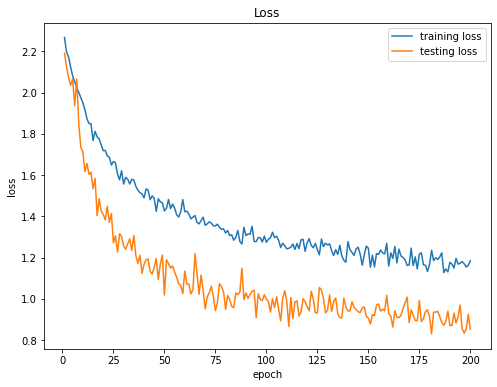

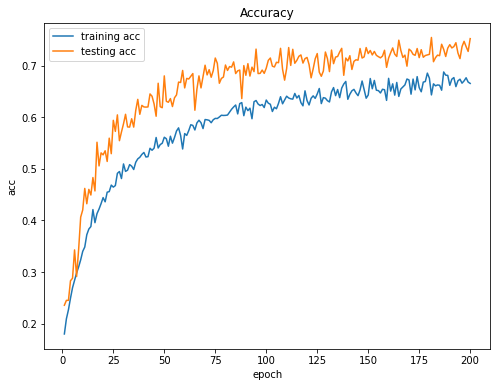

FOLD 2
--------------------------------
in_features: 1024
out_features: None
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=F

Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.32it/s]


Epoch:   1 / 200
	Training   Acc: 0.190106 | loss: 2.251238
	Validation Acc: 0.250846 | loss: 2.147490
[ Valid | 001/200 ] loss = 2.14749, acc = 0.25085 -> best
Saving model with acc 0.251


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.45it/s]


Epoch:   2 / 200
	Training   Acc: 0.221474 | loss: 2.176589
	Validation Acc: 0.230914 | loss: 2.189266
[ Valid | 002/200 ] loss = 2.18927, acc = 0.23091


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.14it/s]


Epoch:   3 / 200
	Training   Acc: 0.251293 | loss: 2.132969
	Validation Acc: 0.259120 | loss: 2.092781
[ Valid | 003/200 ] loss = 2.09278, acc = 0.25912 -> best
Saving model with acc 0.259


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.13it/s]


Epoch:   4 / 200
	Training   Acc: 0.266351 | loss: 2.095479
	Validation Acc: 0.281685 | loss: 2.047352
[ Valid | 004/200 ] loss = 2.04735, acc = 0.28168 -> best
Saving model with acc 0.282


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.27it/s]


Epoch:   5 / 200
	Training   Acc: 0.282603 | loss: 2.052300
	Validation Acc: 0.300865 | loss: 1.981010
[ Valid | 005/200 ] loss = 1.98101, acc = 0.30086 -> best
Saving model with acc 0.301


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.48it/s]


Epoch:   6 / 200
	Training   Acc: 0.291332 | loss: 2.045090
	Validation Acc: 0.315908 | loss: 2.003017
[ Valid | 006/200 ] loss = 2.00302, acc = 0.31591 -> best
Saving model with acc 0.316


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.36it/s]


Epoch:   7 / 200
	Training   Acc: 0.312141 | loss: 2.016105
	Validation Acc: 0.332080 | loss: 1.860269
[ Valid | 007/200 ] loss = 1.86027, acc = 0.33208 -> best
Saving model with acc 0.332


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.20it/s]


Epoch:   8 / 200
	Training   Acc: 0.309138 | loss: 2.002615
	Validation Acc: 0.359910 | loss: 1.820909
[ Valid | 008/200 ] loss = 1.82091, acc = 0.35991 -> best
Saving model with acc 0.360


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.40it/s]


Epoch:   9 / 200
	Training   Acc: 0.332879 | loss: 1.952044
	Validation Acc: 0.343362 | loss: 1.886249
[ Valid | 009/200 ] loss = 1.88625, acc = 0.34336


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.33it/s]


Epoch:  10 / 200
	Training   Acc: 0.329012 | loss: 1.962531
	Validation Acc: 0.339977 | loss: 1.867867
[ Valid | 010/200 ] loss = 1.86787, acc = 0.33998


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.80it/s]


Epoch:  11 / 200
	Training   Acc: 0.354048 | loss: 1.914041
	Validation Acc: 0.326439 | loss: 1.938794
[ Valid | 011/200 ] loss = 1.93879, acc = 0.32644


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.18it/s]


Epoch:  12 / 200
	Training   Acc: 0.366551 | loss: 1.876118
	Validation Acc: 0.450921 | loss: 1.627136
[ Valid | 012/200 ] loss = 1.62714, acc = 0.45092 -> best
Saving model with acc 0.451


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.59it/s]


Epoch:  13 / 200
	Training   Acc: 0.373639 | loss: 1.872617
	Validation Acc: 0.479880 | loss: 1.573366
[ Valid | 013/200 ] loss = 1.57337, acc = 0.47988 -> best
Saving model with acc 0.480


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.29it/s]


Epoch:  14 / 200
	Training   Acc: 0.386251 | loss: 1.845629
	Validation Acc: 0.444528 | loss: 1.615156
[ Valid | 014/200 ] loss = 1.61516, acc = 0.44453


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.44it/s]


Epoch:  15 / 200
	Training   Acc: 0.403146 | loss: 1.794970
	Validation Acc: 0.452050 | loss: 1.611077
[ Valid | 015/200 ] loss = 1.61108, acc = 0.45205


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.56it/s]


Epoch:  16 / 200
	Training   Acc: 0.395733 | loss: 1.819177
	Validation Acc: 0.479504 | loss: 1.571666
[ Valid | 016/200 ] loss = 1.57167, acc = 0.47950


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.59it/s]


Epoch:  17 / 200
	Training   Acc: 0.412562 | loss: 1.784989
	Validation Acc: 0.438511 | loss: 1.654017
[ Valid | 017/200 ] loss = 1.65402, acc = 0.43851


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.74it/s]


Epoch:  18 / 200
	Training   Acc: 0.418441 | loss: 1.777441
	Validation Acc: 0.537420 | loss: 1.437770
[ Valid | 018/200 ] loss = 1.43777, acc = 0.53742 -> best
Saving model with acc 0.537


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch:  19 / 200
	Training   Acc: 0.424951 | loss: 1.760935
	Validation Acc: 0.533283 | loss: 1.448852
[ Valid | 019/200 ] loss = 1.44885, acc = 0.53328


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.33it/s]


Epoch:  20 / 200
	Training   Acc: 0.423550 | loss: 1.763694
	Validation Acc: 0.512975 | loss: 1.464826
[ Valid | 020/200 ] loss = 1.46483, acc = 0.51297


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.32it/s]


Epoch:  21 / 200
	Training   Acc: 0.445428 | loss: 1.709130
	Validation Acc: 0.485145 | loss: 1.517872
[ Valid | 021/200 ] loss = 1.51787, acc = 0.48514


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.59it/s]


Epoch:  22 / 200
	Training   Acc: 0.441761 | loss: 1.725065
	Validation Acc: 0.544942 | loss: 1.371199
[ Valid | 022/200 ] loss = 1.37120, acc = 0.54494 -> best
Saving model with acc 0.545


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.71it/s]


Epoch:  23 / 200
	Training   Acc: 0.453531 | loss: 1.697800
	Validation Acc: 0.518992 | loss: 1.445701
[ Valid | 023/200 ] loss = 1.44570, acc = 0.51899


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.06it/s]


Epoch:  24 / 200
	Training   Acc: 0.452840 | loss: 1.699124
	Validation Acc: 0.520496 | loss: 1.431218
[ Valid | 024/200 ] loss = 1.43122, acc = 0.52050


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.21it/s]


Epoch:  25 / 200
	Training   Acc: 0.452662 | loss: 1.689723
	Validation Acc: 0.587063 | loss: 1.296133
[ Valid | 025/200 ] loss = 1.29613, acc = 0.58706 -> best
Saving model with acc 0.587


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.18it/s]


Epoch:  26 / 200
	Training   Acc: 0.488329 | loss: 1.603091
	Validation Acc: 0.564122 | loss: 1.306022
[ Valid | 026/200 ] loss = 1.30602, acc = 0.56412


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.24it/s]


Epoch:  27 / 200
	Training   Acc: 0.471224 | loss: 1.652081
	Validation Acc: 0.525385 | loss: 1.422622
[ Valid | 027/200 ] loss = 1.42262, acc = 0.52539


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.92it/s]


Epoch:  28 / 200
	Training   Acc: 0.468748 | loss: 1.648547
	Validation Acc: 0.554720 | loss: 1.348060
[ Valid | 028/200 ] loss = 1.34806, acc = 0.55472


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.74it/s]


Epoch:  29 / 200
	Training   Acc: 0.477855 | loss: 1.628331
	Validation Acc: 0.552463 | loss: 1.357207
[ Valid | 029/200 ] loss = 1.35721, acc = 0.55246


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.48it/s]


Epoch:  30 / 200
	Training   Acc: 0.497843 | loss: 1.586516
	Validation Acc: 0.590824 | loss: 1.261052
[ Valid | 030/200 ] loss = 1.26105, acc = 0.59082 -> best
Saving model with acc 0.591


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.06it/s]


Epoch:  31 / 200
	Training   Acc: 0.502599 | loss: 1.583304
	Validation Acc: 0.598721 | loss: 1.269804
[ Valid | 031/200 ] loss = 1.26980, acc = 0.59872 -> best
Saving model with acc 0.599


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.79it/s]


Epoch:  32 / 200
	Training   Acc: 0.514596 | loss: 1.542799
	Validation Acc: 0.578037 | loss: 1.288623
[ Valid | 032/200 ] loss = 1.28862, acc = 0.57804


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.39it/s]


Epoch:  33 / 200
	Training   Acc: 0.496797 | loss: 1.587334
	Validation Acc: 0.616021 | loss: 1.217643
[ Valid | 033/200 ] loss = 1.21764, acc = 0.61602 -> best
Saving model with acc 0.616


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.67it/s]


Epoch:  34 / 200
	Training   Acc: 0.498311 | loss: 1.576533
	Validation Acc: 0.633321 | loss: 1.166624
[ Valid | 034/200 ] loss = 1.16662, acc = 0.63332 -> best
Saving model with acc 0.633


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.46it/s]


Epoch:  35 / 200
	Training   Acc: 0.494150 | loss: 1.606230
	Validation Acc: 0.608499 | loss: 1.230332
[ Valid | 035/200 ] loss = 1.23033, acc = 0.60850


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.34it/s]


Epoch:  36 / 200
	Training   Acc: 0.519005 | loss: 1.525720
	Validation Acc: 0.600226 | loss: 1.233111
[ Valid | 036/200 ] loss = 1.23311, acc = 0.60023


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.10it/s]


Epoch:  37 / 200
	Training   Acc: 0.521746 | loss: 1.525513
	Validation Acc: 0.609252 | loss: 1.176230
[ Valid | 037/200 ] loss = 1.17623, acc = 0.60925


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.66it/s]


Epoch:  38 / 200
	Training   Acc: 0.525857 | loss: 1.519368
	Validation Acc: 0.647988 | loss: 1.121222
[ Valid | 038/200 ] loss = 1.12122, acc = 0.64799 -> best
Saving model with acc 0.648


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.55it/s]


Epoch:  39 / 200
	Training   Acc: 0.518271 | loss: 1.535608
	Validation Acc: 0.644227 | loss: 1.138271
[ Valid | 039/200 ] loss = 1.13827, acc = 0.64423


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.49it/s]


Epoch:  40 / 200
	Training   Acc: 0.529478 | loss: 1.503428
	Validation Acc: 0.625799 | loss: 1.141732
[ Valid | 040/200 ] loss = 1.14173, acc = 0.62580


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.07it/s]


Epoch:  41 / 200
	Training   Acc: 0.529485 | loss: 1.506141
	Validation Acc: 0.681083 | loss: 1.037500
[ Valid | 041/200 ] loss = 1.03750, acc = 0.68108 -> best
Saving model with acc 0.681


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.21it/s]


Epoch:  42 / 200
	Training   Acc: 0.530419 | loss: 1.501952
	Validation Acc: 0.605115 | loss: 1.231903
[ Valid | 042/200 ] loss = 1.23190, acc = 0.60511


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.16it/s]


Epoch:  43 / 200
	Training   Acc: 0.543120 | loss: 1.477785
	Validation Acc: 0.606243 | loss: 1.184089
[ Valid | 043/200 ] loss = 1.18409, acc = 0.60624


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.48it/s]


Epoch:  44 / 200
	Training   Acc: 0.538447 | loss: 1.476381
	Validation Acc: 0.635953 | loss: 1.151521
[ Valid | 044/200 ] loss = 1.15152, acc = 0.63595


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.64it/s]


Epoch:  45 / 200
	Training   Acc: 0.529486 | loss: 1.517673
	Validation Acc: 0.641971 | loss: 1.189866
[ Valid | 045/200 ] loss = 1.18987, acc = 0.64197


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.41it/s]


Epoch:  46 / 200
	Training   Acc: 0.550068 | loss: 1.459861
	Validation Acc: 0.639338 | loss: 1.153629
[ Valid | 046/200 ] loss = 1.15363, acc = 0.63934


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.44it/s]


Epoch:  47 / 200
	Training   Acc: 0.549638 | loss: 1.475819
	Validation Acc: 0.641971 | loss: 1.093701
[ Valid | 047/200 ] loss = 1.09370, acc = 0.64197


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.25it/s]


Epoch:  48 / 200
	Training   Acc: 0.542925 | loss: 1.486715
	Validation Acc: 0.618654 | loss: 1.219337
[ Valid | 048/200 ] loss = 1.21934, acc = 0.61865


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.31it/s]


Epoch:  49 / 200
	Training   Acc: 0.560300 | loss: 1.439841
	Validation Acc: 0.647612 | loss: 1.128575
[ Valid | 049/200 ] loss = 1.12857, acc = 0.64761


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.51it/s]


Epoch:  50 / 200
	Training   Acc: 0.553544 | loss: 1.459666
	Validation Acc: 0.687853 | loss: 1.058312
[ Valid | 050/200 ] loss = 1.05831, acc = 0.68785 -> best
Saving model with acc 0.688


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.33it/s]


Epoch:  51 / 200
	Training   Acc: 0.571573 | loss: 1.415935
	Validation Acc: 0.647988 | loss: 1.097357
[ Valid | 051/200 ] loss = 1.09736, acc = 0.64799


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.60it/s]


Epoch:  52 / 200
	Training   Acc: 0.549035 | loss: 1.467678
	Validation Acc: 0.637082 | loss: 1.151145
[ Valid | 052/200 ] loss = 1.15115, acc = 0.63708


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.95it/s]


Epoch:  53 / 200
	Training   Acc: 0.555014 | loss: 1.452158
	Validation Acc: 0.660399 | loss: 1.091310
[ Valid | 053/200 ] loss = 1.09131, acc = 0.66040


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.68it/s]


Epoch:  54 / 200
	Training   Acc: 0.573266 | loss: 1.405903
	Validation Acc: 0.634449 | loss: 1.165931
[ Valid | 054/200 ] loss = 1.16593, acc = 0.63445


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.61it/s]


Epoch:  55 / 200
	Training   Acc: 0.564898 | loss: 1.415943
	Validation Acc: 0.643475 | loss: 1.156155
[ Valid | 055/200 ] loss = 1.15615, acc = 0.64347


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.57it/s]


Epoch:  56 / 200
	Training   Acc: 0.558022 | loss: 1.460707
	Validation Acc: 0.675818 | loss: 1.067974
[ Valid | 056/200 ] loss = 1.06797, acc = 0.67582


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.14it/s]


Epoch:  57 / 200
	Training   Acc: 0.549773 | loss: 1.452821
	Validation Acc: 0.603234 | loss: 1.209597
[ Valid | 057/200 ] loss = 1.20960, acc = 0.60323


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.72it/s]


Epoch:  58 / 200
	Training   Acc: 0.563738 | loss: 1.443255
	Validation Acc: 0.654757 | loss: 1.095699
[ Valid | 058/200 ] loss = 1.09570, acc = 0.65476


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.58it/s]


Epoch:  59 / 200
	Training   Acc: 0.581603 | loss: 1.372614
	Validation Acc: 0.673938 | loss: 1.046730
[ Valid | 059/200 ] loss = 1.04673, acc = 0.67394


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.51it/s]


Epoch:  60 / 200
	Training   Acc: 0.576081 | loss: 1.405671
	Validation Acc: 0.673561 | loss: 1.058180
[ Valid | 060/200 ] loss = 1.05818, acc = 0.67356


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.46it/s]


Epoch:  61 / 200
	Training   Acc: 0.590955 | loss: 1.371143
	Validation Acc: 0.668296 | loss: 1.043959
[ Valid | 061/200 ] loss = 1.04396, acc = 0.66830


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.47it/s]


Epoch:  62 / 200
	Training   Acc: 0.594033 | loss: 1.363710
	Validation Acc: 0.663031 | loss: 1.088961
[ Valid | 062/200 ] loss = 1.08896, acc = 0.66303


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.50it/s]


Epoch:  63 / 200
	Training   Acc: 0.578096 | loss: 1.401449
	Validation Acc: 0.696126 | loss: 0.992423
[ Valid | 063/200 ] loss = 0.99242, acc = 0.69613 -> best
Saving model with acc 0.696


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.40it/s]


Epoch:  64 / 200
	Training   Acc: 0.556999 | loss: 1.446630
	Validation Acc: 0.628808 | loss: 1.146583
[ Valid | 064/200 ] loss = 1.14658, acc = 0.62881


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch:  65 / 200
	Training   Acc: 0.583571 | loss: 1.384790
	Validation Acc: 0.663407 | loss: 1.081045
[ Valid | 065/200 ] loss = 1.08104, acc = 0.66341


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.27it/s]


Epoch:  66 / 200
	Training   Acc: 0.570262 | loss: 1.426089
	Validation Acc: 0.668672 | loss: 1.048635
[ Valid | 066/200 ] loss = 1.04864, acc = 0.66867


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.60it/s]


Epoch:  67 / 200
	Training   Acc: 0.573967 | loss: 1.418393
	Validation Acc: 0.671681 | loss: 1.054199
[ Valid | 067/200 ] loss = 1.05420, acc = 0.67168


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.76it/s]


Epoch:  68 / 200
	Training   Acc: 0.586269 | loss: 1.373158
	Validation Acc: 0.640466 | loss: 1.158305
[ Valid | 068/200 ] loss = 1.15831, acc = 0.64047


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.92it/s]


Epoch:  69 / 200
	Training   Acc: 0.614359 | loss: 1.295441
	Validation Acc: 0.655886 | loss: 1.095739
[ Valid | 069/200 ] loss = 1.09574, acc = 0.65589


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.42it/s]


Epoch:  70 / 200
	Training   Acc: 0.605995 | loss: 1.329642
	Validation Acc: 0.599850 | loss: 1.218147
[ Valid | 070/200 ] loss = 1.21815, acc = 0.59985


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.29it/s]


Epoch:  71 / 200
	Training   Acc: 0.598120 | loss: 1.346308
	Validation Acc: 0.696502 | loss: 0.951961
[ Valid | 071/200 ] loss = 0.95196, acc = 0.69650 -> best
Saving model with acc 0.697


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.66it/s]


Epoch:  72 / 200
	Training   Acc: 0.581494 | loss: 1.394400
	Validation Acc: 0.701015 | loss: 1.000942
[ Valid | 072/200 ] loss = 1.00094, acc = 0.70102 -> best
Saving model with acc 0.701


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.51it/s]


Epoch:  73 / 200
	Training   Acc: 0.609654 | loss: 1.322141
	Validation Acc: 0.694246 | loss: 0.995692
[ Valid | 073/200 ] loss = 0.99569, acc = 0.69425


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.18it/s]


Epoch:  74 / 200
	Training   Acc: 0.583686 | loss: 1.376502
	Validation Acc: 0.690861 | loss: 0.976621
[ Valid | 074/200 ] loss = 0.97662, acc = 0.69086


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.68it/s]


Epoch:  75 / 200
	Training   Acc: 0.580942 | loss: 1.401171
	Validation Acc: 0.678451 | loss: 1.040389
[ Valid | 075/200 ] loss = 1.04039, acc = 0.67845


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.79it/s]


Epoch:  76 / 200
	Training   Acc: 0.604257 | loss: 1.336793
	Validation Acc: 0.704400 | loss: 0.950489
[ Valid | 076/200 ] loss = 0.95049, acc = 0.70440 -> best
Saving model with acc 0.704


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.55it/s]


Epoch:  77 / 200
	Training   Acc: 0.600374 | loss: 1.350431
	Validation Acc: 0.693494 | loss: 1.009383
[ Valid | 077/200 ] loss = 1.00938, acc = 0.69349


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.25it/s]


Epoch:  78 / 200
	Training   Acc: 0.589220 | loss: 1.371040
	Validation Acc: 0.688229 | loss: 1.006481
[ Valid | 078/200 ] loss = 1.00648, acc = 0.68823


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.72it/s]


Epoch:  79 / 200
	Training   Acc: 0.609125 | loss: 1.318863
	Validation Acc: 0.710417 | loss: 0.975136
[ Valid | 079/200 ] loss = 0.97514, acc = 0.71042 -> best
Saving model with acc 0.710


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.17it/s]


Epoch:  80 / 200
	Training   Acc: 0.596331 | loss: 1.355138
	Validation Acc: 0.690861 | loss: 1.012745
[ Valid | 080/200 ] loss = 1.01275, acc = 0.69086


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.72it/s]


Epoch:  81 / 200
	Training   Acc: 0.596689 | loss: 1.360013
	Validation Acc: 0.676570 | loss: 1.054501
[ Valid | 081/200 ] loss = 1.05450, acc = 0.67657


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.27it/s]


Epoch:  82 / 200
	Training   Acc: 0.592356 | loss: 1.362939
	Validation Acc: 0.664912 | loss: 1.062195
[ Valid | 082/200 ] loss = 1.06220, acc = 0.66491


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.23it/s]


Epoch:  83 / 200
	Training   Acc: 0.625126 | loss: 1.285591
	Validation Acc: 0.699135 | loss: 1.010252
[ Valid | 083/200 ] loss = 1.01025, acc = 0.69914


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.07it/s]


Epoch:  84 / 200
	Training   Acc: 0.603077 | loss: 1.330250
	Validation Acc: 0.682964 | loss: 1.048044
[ Valid | 084/200 ] loss = 1.04804, acc = 0.68296


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.07it/s]


Epoch:  85 / 200
	Training   Acc: 0.590144 | loss: 1.369734
	Validation Acc: 0.680331 | loss: 1.071154
[ Valid | 085/200 ] loss = 1.07115, acc = 0.68033


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.17it/s]


Epoch:  86 / 200
	Training   Acc: 0.604836 | loss: 1.344982
	Validation Acc: 0.699511 | loss: 0.959996
[ Valid | 086/200 ] loss = 0.96000, acc = 0.69951


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.16it/s]


Epoch:  87 / 200
	Training   Acc: 0.600165 | loss: 1.352170
	Validation Acc: 0.688605 | loss: 0.996259
[ Valid | 087/200 ] loss = 0.99626, acc = 0.68860


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.43it/s]


Epoch:  88 / 200
	Training   Acc: 0.592632 | loss: 1.356223
	Validation Acc: 0.700263 | loss: 0.998664
[ Valid | 088/200 ] loss = 0.99866, acc = 0.70026


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.38it/s]


Epoch:  89 / 200
	Training   Acc: 0.611054 | loss: 1.328200
	Validation Acc: 0.697255 | loss: 0.948291
[ Valid | 089/200 ] loss = 0.94829, acc = 0.69725


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.14it/s]


Epoch:  90 / 200
	Training   Acc: 0.612992 | loss: 1.313369
	Validation Acc: 0.706281 | loss: 0.983924
[ Valid | 090/200 ] loss = 0.98392, acc = 0.70628


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.19it/s]


Epoch:  91 / 200
	Training   Acc: 0.621337 | loss: 1.292653
	Validation Acc: 0.695374 | loss: 0.996579
[ Valid | 091/200 ] loss = 0.99658, acc = 0.69537


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.04it/s]


Epoch:  92 / 200
	Training   Acc: 0.615390 | loss: 1.302491
	Validation Acc: 0.720572 | loss: 0.927375
[ Valid | 092/200 ] loss = 0.92738, acc = 0.72057 -> best
Saving model with acc 0.721


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.32it/s]


Epoch:  93 / 200
	Training   Acc: 0.610096 | loss: 1.342710
	Validation Acc: 0.684092 | loss: 1.016298
[ Valid | 093/200 ] loss = 1.01630, acc = 0.68409


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.38it/s]


Epoch:  94 / 200
	Training   Acc: 0.622929 | loss: 1.289130
	Validation Acc: 0.707785 | loss: 0.968444
[ Valid | 094/200 ] loss = 0.96844, acc = 0.70778


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.44it/s]


Epoch:  95 / 200
	Training   Acc: 0.599414 | loss: 1.359570
	Validation Acc: 0.707785 | loss: 1.000200
[ Valid | 095/200 ] loss = 1.00020, acc = 0.70778


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.24it/s]


Epoch:  96 / 200
	Training   Acc: 0.634093 | loss: 1.256208
	Validation Acc: 0.713802 | loss: 0.956583
[ Valid | 096/200 ] loss = 0.95658, acc = 0.71380


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.49it/s]


Epoch:  97 / 200
	Training   Acc: 0.603364 | loss: 1.330684
	Validation Acc: 0.697255 | loss: 1.008684
[ Valid | 097/200 ] loss = 1.00868, acc = 0.69725


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.17it/s]


Epoch:  98 / 200
	Training   Acc: 0.613605 | loss: 1.315160
	Validation Acc: 0.664159 | loss: 1.029024
[ Valid | 098/200 ] loss = 1.02902, acc = 0.66416


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.42it/s]


Epoch:  99 / 200
	Training   Acc: 0.626612 | loss: 1.293831
	Validation Acc: 0.695750 | loss: 0.996028
[ Valid | 099/200 ] loss = 0.99603, acc = 0.69575


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.79it/s]


Epoch: 100 / 200
	Training   Acc: 0.635170 | loss: 1.261647
	Validation Acc: 0.701015 | loss: 0.951055
[ Valid | 100/200 ] loss = 0.95105, acc = 0.70102


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.46it/s]


Epoch: 101 / 200
	Training   Acc: 0.639775 | loss: 1.250951
	Validation Acc: 0.712674 | loss: 0.932996
[ Valid | 101/200 ] loss = 0.93300, acc = 0.71267


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.50it/s]


Epoch: 102 / 200
	Training   Acc: 0.599948 | loss: 1.348891
	Validation Acc: 0.701392 | loss: 1.039588
[ Valid | 102/200 ] loss = 1.03959, acc = 0.70139


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.37it/s]


Epoch: 103 / 200
	Training   Acc: 0.614411 | loss: 1.308579
	Validation Acc: 0.693494 | loss: 1.025836
[ Valid | 103/200 ] loss = 1.02584, acc = 0.69349


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.59it/s]


Epoch: 104 / 200
	Training   Acc: 0.627310 | loss: 1.284802
	Validation Acc: 0.705528 | loss: 0.961759
[ Valid | 104/200 ] loss = 0.96176, acc = 0.70553


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.61it/s]


Epoch: 105 / 200
	Training   Acc: 0.627141 | loss: 1.286315
	Validation Acc: 0.690109 | loss: 0.994449
[ Valid | 105/200 ] loss = 0.99445, acc = 0.69011


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.01it/s]


Epoch: 106 / 200
	Training   Acc: 0.631252 | loss: 1.283082
	Validation Acc: 0.700263 | loss: 1.020004
[ Valid | 106/200 ] loss = 1.02000, acc = 0.70026


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.73it/s]


Epoch: 107 / 200
	Training   Acc: 0.629409 | loss: 1.267673
	Validation Acc: 0.685972 | loss: 1.002401
[ Valid | 107/200 ] loss = 1.00240, acc = 0.68597


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.21it/s]


Epoch: 108 / 200
	Training   Acc: 0.643571 | loss: 1.231099
	Validation Acc: 0.672433 | loss: 1.039464
[ Valid | 108/200 ] loss = 1.03946, acc = 0.67243


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.64it/s]


Epoch: 109 / 200
	Training   Acc: 0.631732 | loss: 1.268306
	Validation Acc: 0.725837 | loss: 0.908924
[ Valid | 109/200 ] loss = 0.90892, acc = 0.72584 -> best
Saving model with acc 0.726


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.06it/s]


Epoch: 110 / 200
	Training   Acc: 0.642321 | loss: 1.237689
	Validation Acc: 0.702520 | loss: 0.956371
[ Valid | 110/200 ] loss = 0.95637, acc = 0.70252


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.43it/s]


Epoch: 111 / 200
	Training   Acc: 0.641338 | loss: 1.238755
	Validation Acc: 0.704400 | loss: 0.922916
[ Valid | 111/200 ] loss = 0.92292, acc = 0.70440


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.25it/s]


Epoch: 112 / 200
	Training   Acc: 0.630034 | loss: 1.284763
	Validation Acc: 0.693118 | loss: 1.041370
[ Valid | 112/200 ] loss = 1.04137, acc = 0.69312


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.30it/s]


Epoch: 113 / 200
	Training   Acc: 0.632014 | loss: 1.264404
	Validation Acc: 0.712298 | loss: 0.969712
[ Valid | 113/200 ] loss = 0.96971, acc = 0.71230


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.31it/s]


Epoch: 114 / 200
	Training   Acc: 0.629048 | loss: 1.278027
	Validation Acc: 0.711546 | loss: 0.966537
[ Valid | 114/200 ] loss = 0.96654, acc = 0.71155


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.16it/s]


Epoch: 115 / 200
	Training   Acc: 0.645938 | loss: 1.237846
	Validation Acc: 0.674314 | loss: 1.040134
[ Valid | 115/200 ] loss = 1.04013, acc = 0.67431


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.54it/s]


Epoch: 116 / 200
	Training   Acc: 0.628978 | loss: 1.275218
	Validation Acc: 0.704024 | loss: 0.944556
[ Valid | 116/200 ] loss = 0.94456, acc = 0.70402


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.86it/s]


Epoch: 117 / 200
	Training   Acc: 0.630710 | loss: 1.274765
	Validation Acc: 0.690485 | loss: 0.997667
[ Valid | 117/200 ] loss = 0.99767, acc = 0.69049


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch: 118 / 200
	Training   Acc: 0.652120 | loss: 1.215565
	Validation Acc: 0.687476 | loss: 0.987420
[ Valid | 118/200 ] loss = 0.98742, acc = 0.68748


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch: 119 / 200
	Training   Acc: 0.635598 | loss: 1.244998
	Validation Acc: 0.702144 | loss: 0.995487
[ Valid | 119/200 ] loss = 0.99549, acc = 0.70214


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.75it/s]


Epoch: 120 / 200
	Training   Acc: 0.646842 | loss: 1.235955
	Validation Acc: 0.711922 | loss: 0.950089
[ Valid | 120/200 ] loss = 0.95009, acc = 0.71192


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.74it/s]


Epoch: 121 / 200
	Training   Acc: 0.658192 | loss: 1.206141
	Validation Acc: 0.705152 | loss: 0.939841
[ Valid | 121/200 ] loss = 0.93984, acc = 0.70515


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch: 122 / 200
	Training   Acc: 0.651744 | loss: 1.221943
	Validation Acc: 0.705904 | loss: 0.985210
[ Valid | 122/200 ] loss = 0.98521, acc = 0.70590


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.34it/s]


Epoch: 123 / 200
	Training   Acc: 0.648534 | loss: 1.214846
	Validation Acc: 0.717939 | loss: 0.904391
[ Valid | 123/200 ] loss = 0.90439, acc = 0.71794


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.45it/s]


Epoch: 124 / 200
	Training   Acc: 0.638616 | loss: 1.262516
	Validation Acc: 0.728469 | loss: 0.926138
[ Valid | 124/200 ] loss = 0.92614, acc = 0.72847 -> best
Saving model with acc 0.728


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.08it/s]


Epoch: 125 / 200
	Training   Acc: 0.640373 | loss: 1.235956
	Validation Acc: 0.690109 | loss: 1.003974
[ Valid | 125/200 ] loss = 1.00397, acc = 0.69011


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.28it/s]


Epoch: 126 / 200
	Training   Acc: 0.662215 | loss: 1.184853
	Validation Acc: 0.705152 | loss: 0.937549
[ Valid | 126/200 ] loss = 0.93755, acc = 0.70515


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.61it/s]


Epoch: 127 / 200
	Training   Acc: 0.649637 | loss: 1.217433
	Validation Acc: 0.720948 | loss: 0.929981
[ Valid | 127/200 ] loss = 0.92998, acc = 0.72095


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.35it/s]


Epoch: 128 / 200
	Training   Acc: 0.640479 | loss: 1.254613
	Validation Acc: 0.704776 | loss: 0.985400
[ Valid | 128/200 ] loss = 0.98540, acc = 0.70478


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.35it/s]


Epoch: 129 / 200
	Training   Acc: 0.664912 | loss: 1.182508
	Validation Acc: 0.703648 | loss: 0.925870
[ Valid | 129/200 ] loss = 0.92587, acc = 0.70365


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.18it/s]


Epoch: 130 / 200
	Training   Acc: 0.642543 | loss: 1.231968
	Validation Acc: 0.723204 | loss: 0.902476
[ Valid | 130/200 ] loss = 0.90248, acc = 0.72320


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch: 131 / 200
	Training   Acc: 0.635011 | loss: 1.261606
	Validation Acc: 0.722452 | loss: 0.929429
[ Valid | 131/200 ] loss = 0.92943, acc = 0.72245


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.67it/s]


Epoch: 132 / 200
	Training   Acc: 0.650677 | loss: 1.215141
	Validation Acc: 0.696879 | loss: 0.978891
[ Valid | 132/200 ] loss = 0.97889, acc = 0.69688


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.32it/s]


Epoch: 133 / 200
	Training   Acc: 0.647467 | loss: 1.241233
	Validation Acc: 0.709289 | loss: 0.941165
[ Valid | 133/200 ] loss = 0.94116, acc = 0.70929


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.35it/s]


Epoch: 134 / 200
	Training   Acc: 0.650954 | loss: 1.220673
	Validation Acc: 0.717187 | loss: 0.918083
[ Valid | 134/200 ] loss = 0.91808, acc = 0.71719


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.55it/s]


Epoch: 135 / 200
	Training   Acc: 0.627968 | loss: 1.284254
	Validation Acc: 0.679955 | loss: 1.025337
[ Valid | 135/200 ] loss = 1.02534, acc = 0.67995


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.70it/s]


Epoch: 136 / 200
	Training   Acc: 0.658829 | loss: 1.198157
	Validation Acc: 0.698759 | loss: 1.036202
[ Valid | 136/200 ] loss = 1.03620, acc = 0.69876


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.61it/s]


Epoch: 137 / 200
	Training   Acc: 0.670534 | loss: 1.173797
	Validation Acc: 0.712674 | loss: 0.915786
[ Valid | 137/200 ] loss = 0.91579, acc = 0.71267


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.41it/s]


Epoch: 138 / 200
	Training   Acc: 0.666537 | loss: 1.167253
	Validation Acc: 0.719443 | loss: 0.936946
[ Valid | 138/200 ] loss = 0.93695, acc = 0.71944


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.15it/s]


Epoch: 139 / 200
	Training   Acc: 0.647656 | loss: 1.229638
	Validation Acc: 0.739376 | loss: 0.886915
[ Valid | 139/200 ] loss = 0.88692, acc = 0.73938 -> best
Saving model with acc 0.739


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.64it/s]


Epoch: 140 / 200
	Training   Acc: 0.668297 | loss: 1.187331
	Validation Acc: 0.732606 | loss: 0.890774
[ Valid | 140/200 ] loss = 0.89077, acc = 0.73261


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.20it/s]


Epoch: 141 / 200
	Training   Acc: 0.641783 | loss: 1.241594
	Validation Acc: 0.704024 | loss: 0.980064
[ Valid | 141/200 ] loss = 0.98006, acc = 0.70402


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.12it/s]


Epoch: 142 / 200
	Training   Acc: 0.626877 | loss: 1.277787
	Validation Acc: 0.722452 | loss: 0.930370
[ Valid | 142/200 ] loss = 0.93037, acc = 0.72245


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.42it/s]


Epoch: 143 / 200
	Training   Acc: 0.659452 | loss: 1.200169
	Validation Acc: 0.713050 | loss: 0.937341
[ Valid | 143/200 ] loss = 0.93734, acc = 0.71305


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.09it/s]


Epoch: 144 / 200
	Training   Acc: 0.663466 | loss: 1.188659
	Validation Acc: 0.718691 | loss: 0.944829
[ Valid | 144/200 ] loss = 0.94483, acc = 0.71869


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.62it/s]


Epoch: 145 / 200
	Training   Acc: 0.671840 | loss: 1.163051
	Validation Acc: 0.711922 | loss: 0.910230
[ Valid | 145/200 ] loss = 0.91023, acc = 0.71192


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.63it/s]


Epoch: 146 / 200
	Training   Acc: 0.660121 | loss: 1.198388
	Validation Acc: 0.723956 | loss: 0.920624
[ Valid | 146/200 ] loss = 0.92062, acc = 0.72396


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.60it/s]


Epoch: 147 / 200
	Training   Acc: 0.665274 | loss: 1.187022
	Validation Acc: 0.716435 | loss: 0.918034
[ Valid | 147/200 ] loss = 0.91803, acc = 0.71643


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.41it/s]


Epoch: 148 / 200
	Training   Acc: 0.650266 | loss: 1.226835
	Validation Acc: 0.718691 | loss: 0.951615
[ Valid | 148/200 ] loss = 0.95162, acc = 0.71869


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.50it/s]


Epoch: 149 / 200
	Training   Acc: 0.656474 | loss: 1.201118
	Validation Acc: 0.719819 | loss: 0.922690
[ Valid | 149/200 ] loss = 0.92269, acc = 0.71982


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.74it/s]


Epoch: 150 / 200
	Training   Acc: 0.629354 | loss: 1.269975
	Validation Acc: 0.694246 | loss: 1.009396
[ Valid | 150/200 ] loss = 1.00940, acc = 0.69425


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.27it/s]


Epoch: 151 / 200
	Training   Acc: 0.650234 | loss: 1.218900
	Validation Acc: 0.709665 | loss: 0.965217
[ Valid | 151/200 ] loss = 0.96522, acc = 0.70967


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.46it/s]


Epoch: 152 / 200
	Training   Acc: 0.660967 | loss: 1.187219
	Validation Acc: 0.725085 | loss: 0.925837
[ Valid | 152/200 ] loss = 0.92584, acc = 0.72508


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.60it/s]


Epoch: 153 / 200
	Training   Acc: 0.644469 | loss: 1.231483
	Validation Acc: 0.703648 | loss: 1.013204
[ Valid | 153/200 ] loss = 1.01320, acc = 0.70365


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.60it/s]


Epoch: 154 / 200
	Training   Acc: 0.636731 | loss: 1.263790
	Validation Acc: 0.704776 | loss: 1.023949
[ Valid | 154/200 ] loss = 1.02395, acc = 0.70478


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.62it/s]


Epoch: 155 / 200
	Training   Acc: 0.666405 | loss: 1.185106
	Validation Acc: 0.723956 | loss: 0.918551
[ Valid | 155/200 ] loss = 0.91855, acc = 0.72396


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.23it/s]


Epoch: 156 / 200
	Training   Acc: 0.653171 | loss: 1.216102
	Validation Acc: 0.728469 | loss: 0.940741
[ Valid | 156/200 ] loss = 0.94074, acc = 0.72847


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.77it/s]


Epoch: 157 / 200
	Training   Acc: 0.649779 | loss: 1.221805
	Validation Acc: 0.714178 | loss: 0.985175
[ Valid | 157/200 ] loss = 0.98518, acc = 0.71418


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.51it/s]


Epoch: 158 / 200
	Training   Acc: 0.660015 | loss: 1.190457
	Validation Acc: 0.724332 | loss: 0.943273
[ Valid | 158/200 ] loss = 0.94327, acc = 0.72433


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.48it/s]


Epoch: 159 / 200
	Training   Acc: 0.656608 | loss: 1.208707
	Validation Acc: 0.731478 | loss: 0.886312
[ Valid | 159/200 ] loss = 0.88631, acc = 0.73148


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.46it/s]


Epoch: 160 / 200
	Training   Acc: 0.643353 | loss: 1.239951
	Validation Acc: 0.717187 | loss: 0.957438
[ Valid | 160/200 ] loss = 0.95744, acc = 0.71719


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.40it/s]


Epoch: 161 / 200
	Training   Acc: 0.655274 | loss: 1.213910
	Validation Acc: 0.716435 | loss: 0.935963
[ Valid | 161/200 ] loss = 0.93596, acc = 0.71643


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.46it/s]


Epoch: 162 / 200
	Training   Acc: 0.677306 | loss: 1.147973
	Validation Acc: 0.721700 | loss: 0.886731
[ Valid | 162/200 ] loss = 0.88673, acc = 0.72170


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.62it/s]


Epoch: 163 / 200
	Training   Acc: 0.645789 | loss: 1.235269
	Validation Acc: 0.720196 | loss: 0.953111
[ Valid | 163/200 ] loss = 0.95311, acc = 0.72020


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.61it/s]


Epoch: 164 / 200
	Training   Acc: 0.669426 | loss: 1.176615
	Validation Acc: 0.712298 | loss: 0.938357
[ Valid | 164/200 ] loss = 0.93836, acc = 0.71230


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.72it/s]


Epoch: 165 / 200
	Training   Acc: 0.663400 | loss: 1.185211
	Validation Acc: 0.724709 | loss: 0.907982
[ Valid | 165/200 ] loss = 0.90798, acc = 0.72471


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.74it/s]


Epoch: 166 / 200
	Training   Acc: 0.678525 | loss: 1.159275
	Validation Acc: 0.714178 | loss: 0.956363
[ Valid | 166/200 ] loss = 0.95636, acc = 0.71418


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.55it/s]


Epoch: 167 / 200
	Training   Acc: 0.675002 | loss: 1.156562
	Validation Acc: 0.716811 | loss: 0.928979
[ Valid | 167/200 ] loss = 0.92898, acc = 0.71681


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.59it/s]


Epoch: 168 / 200
	Training   Acc: 0.653255 | loss: 1.224834
	Validation Acc: 0.716059 | loss: 0.966476
[ Valid | 168/200 ] loss = 0.96648, acc = 0.71606


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.11it/s]


Epoch: 169 / 200
	Training   Acc: 0.662802 | loss: 1.200898
	Validation Acc: 0.731854 | loss: 0.878831
[ Valid | 169/200 ] loss = 0.87883, acc = 0.73185


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.09it/s]


Epoch: 170 / 200
	Training   Acc: 0.654578 | loss: 1.220426
	Validation Acc: 0.704400 | loss: 0.982814
[ Valid | 170/200 ] loss = 0.98281, acc = 0.70440


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.16it/s]


Epoch: 171 / 200
	Training   Acc: 0.645806 | loss: 1.242200
	Validation Acc: 0.705528 | loss: 0.967168
[ Valid | 171/200 ] loss = 0.96717, acc = 0.70553


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.32it/s]


Epoch: 172 / 200
	Training   Acc: 0.651143 | loss: 1.224810
	Validation Acc: 0.739376 | loss: 0.927808
[ Valid | 172/200 ] loss = 0.92781, acc = 0.73938


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.37it/s]


Epoch: 173 / 200
	Training   Acc: 0.664929 | loss: 1.181894
	Validation Acc: 0.730726 | loss: 0.911946
[ Valid | 173/200 ] loss = 0.91195, acc = 0.73073


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.28it/s]


Epoch: 174 / 200
	Training   Acc: 0.656423 | loss: 1.210669
	Validation Acc: 0.714554 | loss: 0.929004
[ Valid | 174/200 ] loss = 0.92900, acc = 0.71455


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.49it/s]


Epoch: 175 / 200
	Training   Acc: 0.658788 | loss: 1.198983
	Validation Acc: 0.690109 | loss: 1.021995
[ Valid | 175/200 ] loss = 1.02200, acc = 0.69011


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.07it/s]


Epoch: 176 / 200
	Training   Acc: 0.662477 | loss: 1.194220
	Validation Acc: 0.705528 | loss: 0.976952
[ Valid | 176/200 ] loss = 0.97695, acc = 0.70553


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.78it/s]


Epoch: 177 / 200
	Training   Acc: 0.670704 | loss: 1.160790
	Validation Acc: 0.729974 | loss: 0.904933
[ Valid | 177/200 ] loss = 0.90493, acc = 0.72997


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.38it/s]


Epoch: 178 / 200
	Training   Acc: 0.665705 | loss: 1.198958
	Validation Acc: 0.721700 | loss: 0.958199
[ Valid | 178/200 ] loss = 0.95820, acc = 0.72170


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.32it/s]


Epoch: 179 / 200
	Training   Acc: 0.659467 | loss: 1.201256
	Validation Acc: 0.725461 | loss: 0.941378
[ Valid | 179/200 ] loss = 0.94138, acc = 0.72546


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.27it/s]


Epoch: 180 / 200
	Training   Acc: 0.656693 | loss: 1.205620
	Validation Acc: 0.721700 | loss: 0.903172
[ Valid | 180/200 ] loss = 0.90317, acc = 0.72170


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.45it/s]


Epoch: 181 / 200
	Training   Acc: 0.669547 | loss: 1.162484
	Validation Acc: 0.717563 | loss: 0.930537
[ Valid | 181/200 ] loss = 0.93054, acc = 0.71756


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.77it/s]


Epoch: 182 / 200
	Training   Acc: 0.669549 | loss: 1.174619
	Validation Acc: 0.684092 | loss: 1.043827
[ Valid | 182/200 ] loss = 1.04383, acc = 0.68409


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.67it/s]


Epoch: 183 / 200
	Training   Acc: 0.670864 | loss: 1.167130
	Validation Acc: 0.743889 | loss: 0.881199
[ Valid | 183/200 ] loss = 0.88120, acc = 0.74389 -> best
Saving model with acc 0.744


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.47it/s]


Epoch: 184 / 200
	Training   Acc: 0.689676 | loss: 1.110084
	Validation Acc: 0.746145 | loss: 0.879549
[ Valid | 184/200 ] loss = 0.87955, acc = 0.74615 -> best
Saving model with acc 0.746


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.37it/s]


Epoch: 185 / 200
	Training   Acc: 0.642711 | loss: 1.259851
	Validation Acc: 0.723204 | loss: 0.944986
[ Valid | 185/200 ] loss = 0.94499, acc = 0.72320


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.77it/s]


Epoch: 186 / 200
	Training   Acc: 0.642176 | loss: 1.246595
	Validation Acc: 0.720196 | loss: 0.952916
[ Valid | 186/200 ] loss = 0.95292, acc = 0.72020


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.25it/s]


Epoch: 187 / 200
	Training   Acc: 0.666488 | loss: 1.165525
	Validation Acc: 0.714930 | loss: 0.960178
[ Valid | 187/200 ] loss = 0.96018, acc = 0.71493


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.97it/s]


Epoch: 188 / 200
	Training   Acc: 0.683183 | loss: 1.126327
	Validation Acc: 0.725461 | loss: 0.895878
[ Valid | 188/200 ] loss = 0.89588, acc = 0.72546


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.44it/s]


Epoch: 189 / 200
	Training   Acc: 0.648753 | loss: 1.233805
	Validation Acc: 0.694246 | loss: 0.990061
[ Valid | 189/200 ] loss = 0.99006, acc = 0.69425


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.57it/s]


Epoch: 190 / 200
	Training   Acc: 0.675459 | loss: 1.146786
	Validation Acc: 0.721700 | loss: 0.911581
[ Valid | 190/200 ] loss = 0.91158, acc = 0.72170


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.33it/s]


Epoch: 191 / 200
	Training   Acc: 0.673677 | loss: 1.154833
	Validation Acc: 0.718691 | loss: 0.915160
[ Valid | 191/200 ] loss = 0.91516, acc = 0.71869


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.40it/s]


Epoch: 192 / 200
	Training   Acc: 0.663718 | loss: 1.187133
	Validation Acc: 0.747273 | loss: 0.867881
[ Valid | 192/200 ] loss = 0.86788, acc = 0.74727 -> best
Saving model with acc 0.747


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.68it/s]


Epoch: 193 / 200
	Training   Acc: 0.685821 | loss: 1.138745
	Validation Acc: 0.711170 | loss: 0.952624
[ Valid | 193/200 ] loss = 0.95262, acc = 0.71117


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.49it/s]


Epoch: 194 / 200
	Training   Acc: 0.677745 | loss: 1.156416
	Validation Acc: 0.748778 | loss: 0.885305
[ Valid | 194/200 ] loss = 0.88531, acc = 0.74878 -> best
Saving model with acc 0.749


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.39it/s]


Epoch: 195 / 200
	Training   Acc: 0.671872 | loss: 1.162584
	Validation Acc: 0.747649 | loss: 0.878739
[ Valid | 195/200 ] loss = 0.87874, acc = 0.74765


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.66it/s]


Epoch: 196 / 200
	Training   Acc: 0.665304 | loss: 1.177058
	Validation Acc: 0.723580 | loss: 0.925241
[ Valid | 196/200 ] loss = 0.92524, acc = 0.72358


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.39it/s]


Epoch: 197 / 200
	Training   Acc: 0.685103 | loss: 1.124467
	Validation Acc: 0.731854 | loss: 0.879094
[ Valid | 197/200 ] loss = 0.87909, acc = 0.73185


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.69it/s]


Epoch: 198 / 200
	Training   Acc: 0.665645 | loss: 1.191453
	Validation Acc: 0.694622 | loss: 1.004569
[ Valid | 198/200 ] loss = 1.00457, acc = 0.69462


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.45it/s]


Epoch: 199 / 200
	Training   Acc: 0.683498 | loss: 1.146906
	Validation Acc: 0.727341 | loss: 0.911446
[ Valid | 199/200 ] loss = 0.91145, acc = 0.72734


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.21it/s]


Epoch: 200 / 200
	Training   Acc: 0.666766 | loss: 1.179090
	Validation Acc: 0.751786 | loss: 0.862233
[ Valid | 200/200 ] loss = 0.86223, acc = 0.75179 -> best
Saving model with acc 0.752


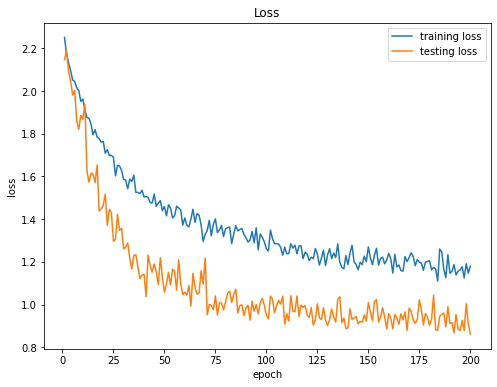

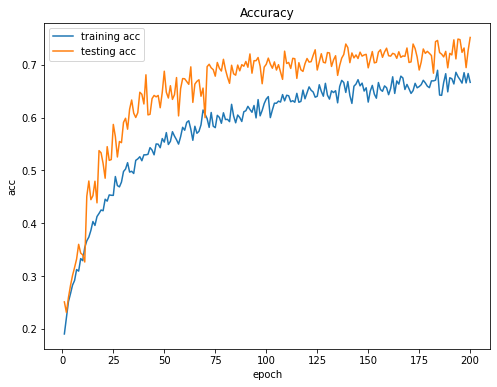

FOLD 3
--------------------------------
in_features: 1024
out_features: None
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=F

Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.32it/s]


Epoch:   1 / 200
	Training   Acc: 0.174153 | loss: 2.273873
	Validation Acc: 0.203836 | loss: 2.320013
[ Valid | 001/200 ] loss = 2.32001, acc = 0.20384 -> best
Saving model with acc 0.204


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.03it/s]


Epoch:   2 / 200
	Training   Acc: 0.213886 | loss: 2.192298
	Validation Acc: 0.222264 | loss: 2.165800
[ Valid | 002/200 ] loss = 2.16580, acc = 0.22226 -> best
Saving model with acc 0.222


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.06it/s]


Epoch:   3 / 200
	Training   Acc: 0.232412 | loss: 2.163556
	Validation Acc: 0.194434 | loss: 2.475979
[ Valid | 003/200 ] loss = 2.47598, acc = 0.19443


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.69it/s]


Epoch:   4 / 200
	Training   Acc: 0.259076 | loss: 2.111008
	Validation Acc: 0.325310 | loss: 1.948983
[ Valid | 004/200 ] loss = 1.94898, acc = 0.32531 -> best
Saving model with acc 0.325


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.35it/s]


Epoch:   5 / 200
	Training   Acc: 0.282261 | loss: 2.063467
	Validation Acc: 0.270402 | loss: 2.032683
[ Valid | 005/200 ] loss = 2.03268, acc = 0.27040


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.24it/s]


Epoch:   6 / 200
	Training   Acc: 0.301652 | loss: 2.022776
	Validation Acc: 0.353140 | loss: 1.920807
[ Valid | 006/200 ] loss = 1.92081, acc = 0.35314 -> best
Saving model with acc 0.353


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.99it/s]


Epoch:   7 / 200
	Training   Acc: 0.308395 | loss: 2.015501
	Validation Acc: 0.309515 | loss: 1.957774
[ Valid | 007/200 ] loss = 1.95777, acc = 0.30951


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.97it/s]


Epoch:   8 / 200
	Training   Acc: 0.320541 | loss: 1.979514
	Validation Acc: 0.376081 | loss: 1.833440
[ Valid | 008/200 ] loss = 1.83344, acc = 0.37608 -> best
Saving model with acc 0.376


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.48it/s]


Epoch:   9 / 200
	Training   Acc: 0.342510 | loss: 1.950062
	Validation Acc: 0.383603 | loss: 1.804986
[ Valid | 009/200 ] loss = 1.80499, acc = 0.38360 -> best
Saving model with acc 0.384


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.45it/s]


Epoch:  10 / 200
	Training   Acc: 0.363987 | loss: 1.904333
	Validation Acc: 0.442272 | loss: 1.654151
[ Valid | 010/200 ] loss = 1.65415, acc = 0.44227 -> best
Saving model with acc 0.442


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.32it/s]


Epoch:  11 / 200
	Training   Acc: 0.370670 | loss: 1.867676
	Validation Acc: 0.447161 | loss: 1.611331
[ Valid | 011/200 ] loss = 1.61133, acc = 0.44716 -> best
Saving model with acc 0.447


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.51it/s]


Epoch:  12 / 200
	Training   Acc: 0.378110 | loss: 1.866978
	Validation Acc: 0.428733 | loss: 1.664609
[ Valid | 012/200 ] loss = 1.66461, acc = 0.42873


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.76it/s]


Epoch:  13 / 200
	Training   Acc: 0.395950 | loss: 1.814825
	Validation Acc: 0.479127 | loss: 1.490369
[ Valid | 013/200 ] loss = 1.49037, acc = 0.47913 -> best
Saving model with acc 0.479


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.33it/s]


Epoch:  14 / 200
	Training   Acc: 0.392235 | loss: 1.829753
	Validation Acc: 0.445656 | loss: 1.606066
[ Valid | 014/200 ] loss = 1.60607, acc = 0.44566


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.19it/s]


Epoch:  15 / 200
	Training   Acc: 0.403565 | loss: 1.802246
	Validation Acc: 0.498684 | loss: 1.483194
[ Valid | 015/200 ] loss = 1.48319, acc = 0.49868 -> best
Saving model with acc 0.499


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.26it/s]


Epoch:  16 / 200
	Training   Acc: 0.415974 | loss: 1.775663
	Validation Acc: 0.519744 | loss: 1.449853
[ Valid | 016/200 ] loss = 1.44985, acc = 0.51974 -> best
Saving model with acc 0.520


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.42it/s]


Epoch:  17 / 200
	Training   Acc: 0.429482 | loss: 1.749800
	Validation Acc: 0.508086 | loss: 1.475069
[ Valid | 017/200 ] loss = 1.47507, acc = 0.50809


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.94it/s]


Epoch:  18 / 200
	Training   Acc: 0.423796 | loss: 1.754537
	Validation Acc: 0.497932 | loss: 1.493904
[ Valid | 018/200 ] loss = 1.49390, acc = 0.49793


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.23it/s]


Epoch:  19 / 200
	Training   Acc: 0.427261 | loss: 1.751739
	Validation Acc: 0.544942 | loss: 1.389853
[ Valid | 019/200 ] loss = 1.38985, acc = 0.54494 -> best
Saving model with acc 0.545


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.29it/s]


Epoch:  20 / 200
	Training   Acc: 0.448731 | loss: 1.706066
	Validation Acc: 0.541181 | loss: 1.379860
[ Valid | 020/200 ] loss = 1.37986, acc = 0.54118


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.26it/s]


Epoch:  21 / 200
	Training   Acc: 0.455701 | loss: 1.672661
	Validation Acc: 0.502821 | loss: 1.488131
[ Valid | 021/200 ] loss = 1.48813, acc = 0.50282


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.10it/s]


Epoch:  22 / 200
	Training   Acc: 0.458638 | loss: 1.670657
	Validation Acc: 0.566378 | loss: 1.292426
[ Valid | 022/200 ] loss = 1.29243, acc = 0.56638 -> best
Saving model with acc 0.566


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch:  23 / 200
	Training   Acc: 0.473189 | loss: 1.647698
	Validation Acc: 0.536668 | loss: 1.503560
[ Valid | 023/200 ] loss = 1.50356, acc = 0.53667


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.83it/s]


Epoch:  24 / 200
	Training   Acc: 0.453638 | loss: 1.681543
	Validation Acc: 0.559985 | loss: 1.367640
[ Valid | 024/200 ] loss = 1.36764, acc = 0.55998


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.17it/s]


Epoch:  25 / 200
	Training   Acc: 0.473159 | loss: 1.635997
	Validation Acc: 0.575780 | loss: 1.302610
[ Valid | 025/200 ] loss = 1.30261, acc = 0.57578 -> best
Saving model with acc 0.576


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.90it/s]


Epoch:  26 / 200
	Training   Acc: 0.484270 | loss: 1.611646
	Validation Acc: 0.572020 | loss: 1.310449
[ Valid | 026/200 ] loss = 1.31045, acc = 0.57202


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.89it/s]


Epoch:  27 / 200
	Training   Acc: 0.488305 | loss: 1.605201
	Validation Acc: 0.581422 | loss: 1.292307
[ Valid | 027/200 ] loss = 1.29231, acc = 0.58142 -> best
Saving model with acc 0.581


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.88it/s]


Epoch:  28 / 200
	Training   Acc: 0.503647 | loss: 1.571975
	Validation Acc: 0.609628 | loss: 1.221008
[ Valid | 028/200 ] loss = 1.22101, acc = 0.60963 -> best
Saving model with acc 0.610


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.25it/s]


Epoch:  29 / 200
	Training   Acc: 0.502589 | loss: 1.561000
	Validation Acc: 0.562618 | loss: 1.296403
[ Valid | 029/200 ] loss = 1.29640, acc = 0.56262


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.59it/s]


Epoch:  30 / 200
	Training   Acc: 0.484371 | loss: 1.617086
	Validation Acc: 0.575028 | loss: 1.323547
[ Valid | 030/200 ] loss = 1.32355, acc = 0.57503


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.35it/s]


Epoch:  31 / 200
	Training   Acc: 0.492588 | loss: 1.595440
	Validation Acc: 0.614893 | loss: 1.231513
[ Valid | 031/200 ] loss = 1.23151, acc = 0.61489 -> best
Saving model with acc 0.615


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.91it/s]


Epoch:  32 / 200
	Training   Acc: 0.505327 | loss: 1.556955
	Validation Acc: 0.585935 | loss: 1.286228
[ Valid | 032/200 ] loss = 1.28623, acc = 0.58593


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.21it/s]


Epoch:  33 / 200
	Training   Acc: 0.524139 | loss: 1.541734
	Validation Acc: 0.584054 | loss: 1.247394
[ Valid | 033/200 ] loss = 1.24739, acc = 0.58405


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch:  34 / 200
	Training   Acc: 0.511042 | loss: 1.552436
	Validation Acc: 0.570139 | loss: 1.299417
[ Valid | 034/200 ] loss = 1.29942, acc = 0.57014


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.31it/s]


Epoch:  35 / 200
	Training   Acc: 0.514807 | loss: 1.530787
	Validation Acc: 0.614893 | loss: 1.194106
[ Valid | 035/200 ] loss = 1.19411, acc = 0.61489


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.20it/s]


Epoch:  36 / 200
	Training   Acc: 0.508179 | loss: 1.563261
	Validation Acc: 0.598721 | loss: 1.283607
[ Valid | 036/200 ] loss = 1.28361, acc = 0.59872


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.43it/s]


Epoch:  37 / 200
	Training   Acc: 0.512359 | loss: 1.546179
	Validation Acc: 0.620910 | loss: 1.232316
[ Valid | 037/200 ] loss = 1.23232, acc = 0.62091 -> best
Saving model with acc 0.621


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.33it/s]


Epoch:  38 / 200
	Training   Acc: 0.523843 | loss: 1.524189
	Validation Acc: 0.611132 | loss: 1.206806
[ Valid | 038/200 ] loss = 1.20681, acc = 0.61113


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.43it/s]


Epoch:  39 / 200
	Training   Acc: 0.529898 | loss: 1.506826
	Validation Acc: 0.631440 | loss: 1.188247
[ Valid | 039/200 ] loss = 1.18825, acc = 0.63144 -> best
Saving model with acc 0.631


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.13it/s]


Epoch:  40 / 200
	Training   Acc: 0.536197 | loss: 1.498389
	Validation Acc: 0.640466 | loss: 1.141743
[ Valid | 040/200 ] loss = 1.14174, acc = 0.64047 -> best
Saving model with acc 0.640


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.64it/s]


Epoch:  41 / 200
	Training   Acc: 0.530582 | loss: 1.512833
	Validation Acc: 0.611508 | loss: 1.251047
[ Valid | 041/200 ] loss = 1.25105, acc = 0.61151


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.12it/s]


Epoch:  42 / 200
	Training   Acc: 0.535220 | loss: 1.499376
	Validation Acc: 0.625423 | loss: 1.181262
[ Valid | 042/200 ] loss = 1.18126, acc = 0.62542


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.38it/s]


Epoch:  43 / 200
	Training   Acc: 0.526115 | loss: 1.512643
	Validation Acc: 0.566002 | loss: 1.331924
[ Valid | 043/200 ] loss = 1.33192, acc = 0.56600


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.56it/s]


Epoch:  44 / 200
	Training   Acc: 0.534345 | loss: 1.497856
	Validation Acc: 0.608123 | loss: 1.241673
[ Valid | 044/200 ] loss = 1.24167, acc = 0.60812


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.17it/s]


Epoch:  45 / 200
	Training   Acc: 0.535597 | loss: 1.489831
	Validation Acc: 0.657390 | loss: 1.098140
[ Valid | 045/200 ] loss = 1.09814, acc = 0.65739 -> best
Saving model with acc 0.657


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.09it/s]


Epoch:  46 / 200
	Training   Acc: 0.542234 | loss: 1.491912
	Validation Acc: 0.649492 | loss: 1.101486
[ Valid | 046/200 ] loss = 1.10149, acc = 0.64949


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.46it/s]


Epoch:  47 / 200
	Training   Acc: 0.551834 | loss: 1.445451
	Validation Acc: 0.621662 | loss: 1.223806
[ Valid | 047/200 ] loss = 1.22381, acc = 0.62166


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.27it/s]


Epoch:  48 / 200
	Training   Acc: 0.529362 | loss: 1.507303
	Validation Acc: 0.636706 | loss: 1.186457
[ Valid | 048/200 ] loss = 1.18646, acc = 0.63671


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.31it/s]


Epoch:  49 / 200
	Training   Acc: 0.565656 | loss: 1.422716
	Validation Acc: 0.616397 | loss: 1.159893
[ Valid | 049/200 ] loss = 1.15989, acc = 0.61640


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.56it/s]


Epoch:  50 / 200
	Training   Acc: 0.555380 | loss: 1.461450
	Validation Acc: 0.660023 | loss: 1.088249
[ Valid | 050/200 ] loss = 1.08825, acc = 0.66002 -> best
Saving model with acc 0.660


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.22it/s]


Epoch:  51 / 200
	Training   Acc: 0.558241 | loss: 1.440247
	Validation Acc: 0.581798 | loss: 1.276603
[ Valid | 051/200 ] loss = 1.27660, acc = 0.58180


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.18it/s]


Epoch:  52 / 200
	Training   Acc: 0.560682 | loss: 1.436733
	Validation Acc: 0.661527 | loss: 1.084165
[ Valid | 052/200 ] loss = 1.08417, acc = 0.66153 -> best
Saving model with acc 0.662


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.63it/s]


Epoch:  53 / 200
	Training   Acc: 0.549869 | loss: 1.457746
	Validation Acc: 0.634073 | loss: 1.184107
[ Valid | 053/200 ] loss = 1.18411, acc = 0.63407


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.37it/s]


Epoch:  54 / 200
	Training   Acc: 0.540126 | loss: 1.488062
	Validation Acc: 0.655510 | loss: 1.074646
[ Valid | 054/200 ] loss = 1.07465, acc = 0.65551


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.59it/s]


Epoch:  55 / 200
	Training   Acc: 0.559707 | loss: 1.437902
	Validation Acc: 0.653629 | loss: 1.102247
[ Valid | 055/200 ] loss = 1.10225, acc = 0.65363


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.12it/s]


Epoch:  56 / 200
	Training   Acc: 0.565354 | loss: 1.448049
	Validation Acc: 0.674314 | loss: 1.085331
[ Valid | 056/200 ] loss = 1.08533, acc = 0.67431 -> best
Saving model with acc 0.674


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.89it/s]


Epoch:  57 / 200
	Training   Acc: 0.565640 | loss: 1.429046
	Validation Acc: 0.614141 | loss: 1.183175
[ Valid | 057/200 ] loss = 1.18318, acc = 0.61414


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.34it/s]


Epoch:  58 / 200
	Training   Acc: 0.568639 | loss: 1.415618
	Validation Acc: 0.644979 | loss: 1.131528
[ Valid | 058/200 ] loss = 1.13153, acc = 0.64498


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.21it/s]


Epoch:  59 / 200
	Training   Acc: 0.571183 | loss: 1.435479
	Validation Acc: 0.684092 | loss: 1.038020
[ Valid | 059/200 ] loss = 1.03802, acc = 0.68409 -> best
Saving model with acc 0.684


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.47it/s]


Epoch:  60 / 200
	Training   Acc: 0.569119 | loss: 1.417661
	Validation Acc: 0.663031 | loss: 1.088876
[ Valid | 060/200 ] loss = 1.08888, acc = 0.66303


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.18it/s]


Epoch:  61 / 200
	Training   Acc: 0.556806 | loss: 1.445479
	Validation Acc: 0.673185 | loss: 1.057624
[ Valid | 061/200 ] loss = 1.05762, acc = 0.67319


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.32it/s]


Epoch:  62 / 200
	Training   Acc: 0.582398 | loss: 1.384910
	Validation Acc: 0.643851 | loss: 1.097606
[ Valid | 062/200 ] loss = 1.09761, acc = 0.64385


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch:  63 / 200
	Training   Acc: 0.583421 | loss: 1.381655
	Validation Acc: 0.670177 | loss: 1.066940
[ Valid | 063/200 ] loss = 1.06694, acc = 0.67018


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.34it/s]


Epoch:  64 / 200
	Training   Acc: 0.571763 | loss: 1.424956
	Validation Acc: 0.638962 | loss: 1.099706
[ Valid | 064/200 ] loss = 1.09971, acc = 0.63896


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.63it/s]


Epoch:  65 / 200
	Training   Acc: 0.576606 | loss: 1.407258
	Validation Acc: 0.665288 | loss: 1.093951
[ Valid | 065/200 ] loss = 1.09395, acc = 0.66529


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.10it/s]


Epoch:  66 / 200
	Training   Acc: 0.578215 | loss: 1.389656
	Validation Acc: 0.690485 | loss: 1.014077
[ Valid | 066/200 ] loss = 1.01408, acc = 0.69049 -> best
Saving model with acc 0.690


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.13it/s]


Epoch:  67 / 200
	Training   Acc: 0.586556 | loss: 1.371009
	Validation Acc: 0.660399 | loss: 1.103952
[ Valid | 067/200 ] loss = 1.10395, acc = 0.66040


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.18it/s]


Epoch:  68 / 200
	Training   Acc: 0.596952 | loss: 1.347000
	Validation Acc: 0.681835 | loss: 1.060024
[ Valid | 068/200 ] loss = 1.06002, acc = 0.68184


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.29it/s]


Epoch:  69 / 200
	Training   Acc: 0.597702 | loss: 1.345514
	Validation Acc: 0.690109 | loss: 1.031389
[ Valid | 069/200 ] loss = 1.03139, acc = 0.69011


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.64it/s]


Epoch:  70 / 200
	Training   Acc: 0.604705 | loss: 1.340294
	Validation Acc: 0.659270 | loss: 1.081996
[ Valid | 070/200 ] loss = 1.08200, acc = 0.65927


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.40it/s]


Epoch:  71 / 200
	Training   Acc: 0.587852 | loss: 1.380368
	Validation Acc: 0.636706 | loss: 1.175920
[ Valid | 071/200 ] loss = 1.17592, acc = 0.63671


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.47it/s]


Epoch:  72 / 200
	Training   Acc: 0.598350 | loss: 1.340398
	Validation Acc: 0.677322 | loss: 1.072845
[ Valid | 072/200 ] loss = 1.07284, acc = 0.67732


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.21it/s]


Epoch:  73 / 200
	Training   Acc: 0.596155 | loss: 1.360282
	Validation Acc: 0.682587 | loss: 1.048929
[ Valid | 073/200 ] loss = 1.04893, acc = 0.68259


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.81it/s]


Epoch:  74 / 200
	Training   Acc: 0.590767 | loss: 1.362428
	Validation Acc: 0.688605 | loss: 1.009149
[ Valid | 074/200 ] loss = 1.00915, acc = 0.68860


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.39it/s]


Epoch:  75 / 200
	Training   Acc: 0.588357 | loss: 1.384450
	Validation Acc: 0.660399 | loss: 1.107816
[ Valid | 075/200 ] loss = 1.10782, acc = 0.66040


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.02it/s]


Epoch:  76 / 200
	Training   Acc: 0.605895 | loss: 1.330613
	Validation Acc: 0.698759 | loss: 1.020647
[ Valid | 076/200 ] loss = 1.02065, acc = 0.69876 -> best
Saving model with acc 0.699


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.63it/s]


Epoch:  77 / 200
	Training   Acc: 0.575812 | loss: 1.419554
	Validation Acc: 0.682964 | loss: 1.038161
[ Valid | 077/200 ] loss = 1.03816, acc = 0.68296


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.82it/s]


Epoch:  78 / 200
	Training   Acc: 0.588822 | loss: 1.361851
	Validation Acc: 0.697631 | loss: 0.997462
[ Valid | 078/200 ] loss = 0.99746, acc = 0.69763


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.04it/s]


Epoch:  79 / 200
	Training   Acc: 0.618663 | loss: 1.300622
	Validation Acc: 0.679203 | loss: 1.031061
[ Valid | 079/200 ] loss = 1.03106, acc = 0.67920


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.40it/s]


Epoch:  80 / 200
	Training   Acc: 0.607727 | loss: 1.318568
	Validation Acc: 0.670929 | loss: 1.044733
[ Valid | 080/200 ] loss = 1.04473, acc = 0.67093


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.18it/s]


Epoch:  81 / 200
	Training   Acc: 0.595369 | loss: 1.368008
	Validation Acc: 0.687476 | loss: 1.010851
[ Valid | 081/200 ] loss = 1.01085, acc = 0.68748


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.32it/s]


Epoch:  82 / 200
	Training   Acc: 0.611003 | loss: 1.319635
	Validation Acc: 0.705528 | loss: 0.984409
[ Valid | 082/200 ] loss = 0.98441, acc = 0.70553 -> best
Saving model with acc 0.706


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.37it/s]


Epoch:  83 / 200
	Training   Acc: 0.608840 | loss: 1.328545
	Validation Acc: 0.677698 | loss: 1.045369
[ Valid | 083/200 ] loss = 1.04537, acc = 0.67770


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.75it/s]


Epoch:  84 / 200
	Training   Acc: 0.608997 | loss: 1.328192
	Validation Acc: 0.661151 | loss: 1.056433
[ Valid | 084/200 ] loss = 1.05643, acc = 0.66115


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.59it/s]


Epoch:  85 / 200
	Training   Acc: 0.593408 | loss: 1.358438
	Validation Acc: 0.704776 | loss: 1.027217
[ Valid | 085/200 ] loss = 1.02722, acc = 0.70478


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.25it/s]


Epoch:  86 / 200
	Training   Acc: 0.609310 | loss: 1.327021
	Validation Acc: 0.670177 | loss: 1.044186
[ Valid | 086/200 ] loss = 1.04419, acc = 0.67018


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.68it/s]


Epoch:  87 / 200
	Training   Acc: 0.624492 | loss: 1.291076
	Validation Acc: 0.702520 | loss: 1.002905
[ Valid | 087/200 ] loss = 1.00291, acc = 0.70252


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.47it/s]


Epoch:  88 / 200
	Training   Acc: 0.603208 | loss: 1.343774
	Validation Acc: 0.636329 | loss: 1.106708
[ Valid | 088/200 ] loss = 1.10671, acc = 0.63633


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.83it/s]


Epoch:  89 / 200
	Training   Acc: 0.621677 | loss: 1.289661
	Validation Acc: 0.689357 | loss: 1.028934
[ Valid | 089/200 ] loss = 1.02893, acc = 0.68936


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.45it/s]


Epoch:  90 / 200
	Training   Acc: 0.624225 | loss: 1.283307
	Validation Acc: 0.700263 | loss: 0.992037
[ Valid | 090/200 ] loss = 0.99204, acc = 0.70026


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.50it/s]


Epoch:  91 / 200
	Training   Acc: 0.629444 | loss: 1.278320
	Validation Acc: 0.666792 | loss: 1.073848
[ Valid | 091/200 ] loss = 1.07385, acc = 0.66679


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.96it/s]


Epoch:  92 / 200
	Training   Acc: 0.630962 | loss: 1.276374
	Validation Acc: 0.681083 | loss: 1.048080
[ Valid | 092/200 ] loss = 1.04808, acc = 0.68108


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.06it/s]


Epoch:  93 / 200
	Training   Acc: 0.616486 | loss: 1.311809
	Validation Acc: 0.689357 | loss: 1.021507
[ Valid | 093/200 ] loss = 1.02151, acc = 0.68936


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.14it/s]


Epoch:  94 / 200
	Training   Acc: 0.604041 | loss: 1.335270
	Validation Acc: 0.693870 | loss: 1.050912
[ Valid | 094/200 ] loss = 1.05091, acc = 0.69387


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.11it/s]


Epoch:  95 / 200
	Training   Acc: 0.620187 | loss: 1.303640
	Validation Acc: 0.670177 | loss: 1.053575
[ Valid | 095/200 ] loss = 1.05358, acc = 0.67018


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.27it/s]


Epoch:  96 / 200
	Training   Acc: 0.620321 | loss: 1.301964
	Validation Acc: 0.707785 | loss: 1.007568
[ Valid | 096/200 ] loss = 1.00757, acc = 0.70778 -> best
Saving model with acc 0.708


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.32it/s]


Epoch:  97 / 200
	Training   Acc: 0.608952 | loss: 1.328142
	Validation Acc: 0.666416 | loss: 1.059970
[ Valid | 097/200 ] loss = 1.05997, acc = 0.66642


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.38it/s]


Epoch:  98 / 200
	Training   Acc: 0.619200 | loss: 1.301450
	Validation Acc: 0.703272 | loss: 0.974407
[ Valid | 098/200 ] loss = 0.97441, acc = 0.70327


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.35it/s]


Epoch:  99 / 200
	Training   Acc: 0.609839 | loss: 1.331493
	Validation Acc: 0.675818 | loss: 1.084297
[ Valid | 099/200 ] loss = 1.08430, acc = 0.67582


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.22it/s]


Epoch: 100 / 200
	Training   Acc: 0.635535 | loss: 1.246576
	Validation Acc: 0.668672 | loss: 1.068362
[ Valid | 100/200 ] loss = 1.06836, acc = 0.66867


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.39it/s]


Epoch: 101 / 200
	Training   Acc: 0.612379 | loss: 1.327572
	Validation Acc: 0.635953 | loss: 1.108145
[ Valid | 101/200 ] loss = 1.10815, acc = 0.63595


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.39it/s]


Epoch: 102 / 200
	Training   Acc: 0.630940 | loss: 1.270338
	Validation Acc: 0.700639 | loss: 0.949844
[ Valid | 102/200 ] loss = 0.94984, acc = 0.70064


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.16it/s]


Epoch: 103 / 200
	Training   Acc: 0.621170 | loss: 1.302432
	Validation Acc: 0.704400 | loss: 1.004292
[ Valid | 103/200 ] loss = 1.00429, acc = 0.70440


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.23it/s]


Epoch: 104 / 200
	Training   Acc: 0.643329 | loss: 1.229583
	Validation Acc: 0.703272 | loss: 0.959931
[ Valid | 104/200 ] loss = 0.95993, acc = 0.70327


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.21it/s]


Epoch: 105 / 200
	Training   Acc: 0.634098 | loss: 1.269917
	Validation Acc: 0.687853 | loss: 1.021687
[ Valid | 105/200 ] loss = 1.02169, acc = 0.68785


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.49it/s]


Epoch: 106 / 200
	Training   Acc: 0.636478 | loss: 1.255878
	Validation Acc: 0.704024 | loss: 0.974172
[ Valid | 106/200 ] loss = 0.97417, acc = 0.70402


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.10it/s]


Epoch: 107 / 200
	Training   Acc: 0.642686 | loss: 1.243023
	Validation Acc: 0.684844 | loss: 1.011213
[ Valid | 107/200 ] loss = 1.01121, acc = 0.68484


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.23it/s]


Epoch: 108 / 200
	Training   Acc: 0.634032 | loss: 1.254190
	Validation Acc: 0.674314 | loss: 1.051406
[ Valid | 108/200 ] loss = 1.05141, acc = 0.67431


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.33it/s]


Epoch: 109 / 200
	Training   Acc: 0.619537 | loss: 1.308281
	Validation Acc: 0.672433 | loss: 1.045986
[ Valid | 109/200 ] loss = 1.04599, acc = 0.67243


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.15it/s]


Epoch: 110 / 200
	Training   Acc: 0.624926 | loss: 1.296743
	Validation Acc: 0.678451 | loss: 1.076768
[ Valid | 110/200 ] loss = 1.07677, acc = 0.67845


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.56it/s]


Epoch: 111 / 200
	Training   Acc: 0.652250 | loss: 1.228223
	Validation Acc: 0.703272 | loss: 1.015443
[ Valid | 111/200 ] loss = 1.01544, acc = 0.70327


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.62it/s]


Epoch: 112 / 200
	Training   Acc: 0.644673 | loss: 1.241848
	Validation Acc: 0.700639 | loss: 0.974452
[ Valid | 112/200 ] loss = 0.97445, acc = 0.70064


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.58it/s]


Epoch: 113 / 200
	Training   Acc: 0.630389 | loss: 1.274480
	Validation Acc: 0.699887 | loss: 0.990153
[ Valid | 113/200 ] loss = 0.99015, acc = 0.69989


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.28it/s]


Epoch: 114 / 200
	Training   Acc: 0.626529 | loss: 1.289216
	Validation Acc: 0.709289 | loss: 0.947220
[ Valid | 114/200 ] loss = 0.94722, acc = 0.70929 -> best
Saving model with acc 0.709


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.35it/s]


Epoch: 115 / 200
	Training   Acc: 0.641757 | loss: 1.248540
	Validation Acc: 0.699887 | loss: 0.976637
[ Valid | 115/200 ] loss = 0.97664, acc = 0.69989


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.16it/s]


Epoch: 116 / 200
	Training   Acc: 0.627449 | loss: 1.280627
	Validation Acc: 0.725461 | loss: 0.946926
[ Valid | 116/200 ] loss = 0.94693, acc = 0.72546 -> best
Saving model with acc 0.725


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch: 117 / 200
	Training   Acc: 0.638853 | loss: 1.262303
	Validation Acc: 0.710417 | loss: 1.008678
[ Valid | 117/200 ] loss = 1.00868, acc = 0.71042


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  6.00it/s]


Epoch: 118 / 200
	Training   Acc: 0.632224 | loss: 1.264412
	Validation Acc: 0.722828 | loss: 0.902602
[ Valid | 118/200 ] loss = 0.90260, acc = 0.72283


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.98it/s]


Epoch: 119 / 200
	Training   Acc: 0.631092 | loss: 1.283898
	Validation Acc: 0.697631 | loss: 1.012709
[ Valid | 119/200 ] loss = 1.01271, acc = 0.69763


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch: 120 / 200
	Training   Acc: 0.618552 | loss: 1.308693
	Validation Acc: 0.689357 | loss: 1.001817
[ Valid | 120/200 ] loss = 1.00182, acc = 0.68936


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.43it/s]


Epoch: 121 / 200
	Training   Acc: 0.635831 | loss: 1.262607
	Validation Acc: 0.670929 | loss: 1.049315
[ Valid | 121/200 ] loss = 1.04932, acc = 0.67093


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.45it/s]


Epoch: 122 / 200
	Training   Acc: 0.633941 | loss: 1.270543
	Validation Acc: 0.694998 | loss: 0.985266
[ Valid | 122/200 ] loss = 0.98527, acc = 0.69500


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.92it/s]


Epoch: 123 / 200
	Training   Acc: 0.612652 | loss: 1.323429
	Validation Acc: 0.722828 | loss: 0.953191
[ Valid | 123/200 ] loss = 0.95319, acc = 0.72283


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.19it/s]


Epoch: 124 / 200
	Training   Acc: 0.637573 | loss: 1.255886
	Validation Acc: 0.711170 | loss: 0.941310
[ Valid | 124/200 ] loss = 0.94131, acc = 0.71117


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.13it/s]


Epoch: 125 / 200
	Training   Acc: 0.638984 | loss: 1.259292
	Validation Acc: 0.697255 | loss: 1.016853
[ Valid | 125/200 ] loss = 1.01685, acc = 0.69725


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.90it/s]


Epoch: 126 / 200
	Training   Acc: 0.631866 | loss: 1.281142
	Validation Acc: 0.691989 | loss: 1.024920
[ Valid | 126/200 ] loss = 1.02492, acc = 0.69199


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.11it/s]


Epoch: 127 / 200
	Training   Acc: 0.637826 | loss: 1.255656
	Validation Acc: 0.705152 | loss: 0.960080
[ Valid | 127/200 ] loss = 0.96008, acc = 0.70515


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.56it/s]


Epoch: 128 / 200
	Training   Acc: 0.663940 | loss: 1.187730
	Validation Acc: 0.689733 | loss: 1.013830
[ Valid | 128/200 ] loss = 1.01383, acc = 0.68973


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.11it/s]


Epoch: 129 / 200
	Training   Acc: 0.649898 | loss: 1.222096
	Validation Acc: 0.696879 | loss: 1.012736
[ Valid | 129/200 ] loss = 1.01274, acc = 0.69688


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.86it/s]


Epoch: 130 / 200
	Training   Acc: 0.644062 | loss: 1.238528
	Validation Acc: 0.717939 | loss: 0.932582
[ Valid | 130/200 ] loss = 0.93258, acc = 0.71794


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.59it/s]


Epoch: 131 / 200
	Training   Acc: 0.635287 | loss: 1.259829
	Validation Acc: 0.691613 | loss: 1.012240
[ Valid | 131/200 ] loss = 1.01224, acc = 0.69161


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.41it/s]


Epoch: 132 / 200
	Training   Acc: 0.644640 | loss: 1.240574
	Validation Acc: 0.697255 | loss: 1.007250
[ Valid | 132/200 ] loss = 1.00725, acc = 0.69725


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.01it/s]


Epoch: 133 / 200
	Training   Acc: 0.645811 | loss: 1.244063
	Validation Acc: 0.692366 | loss: 0.995893
[ Valid | 133/200 ] loss = 0.99589, acc = 0.69237


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.08it/s]


Epoch: 134 / 200
	Training   Acc: 0.657991 | loss: 1.199040
	Validation Acc: 0.678827 | loss: 1.002315
[ Valid | 134/200 ] loss = 1.00232, acc = 0.67883


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.19it/s]


Epoch: 135 / 200
	Training   Acc: 0.638738 | loss: 1.250171
	Validation Acc: 0.697255 | loss: 0.977928
[ Valid | 135/200 ] loss = 0.97793, acc = 0.69725


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.47it/s]


Epoch: 136 / 200
	Training   Acc: 0.662394 | loss: 1.192918
	Validation Acc: 0.667544 | loss: 1.090329
[ Valid | 136/200 ] loss = 1.09033, acc = 0.66754


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.53it/s]


Epoch: 137 / 200
	Training   Acc: 0.636027 | loss: 1.262450
	Validation Acc: 0.706281 | loss: 0.949903
[ Valid | 137/200 ] loss = 0.94990, acc = 0.70628


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.07it/s]


Epoch: 138 / 200
	Training   Acc: 0.641132 | loss: 1.248650
	Validation Acc: 0.731102 | loss: 0.871129
[ Valid | 138/200 ] loss = 0.87113, acc = 0.73110 -> best
Saving model with acc 0.731


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.01it/s]


Epoch: 139 / 200
	Training   Acc: 0.678332 | loss: 1.148112
	Validation Acc: 0.694998 | loss: 0.977085
[ Valid | 139/200 ] loss = 0.97708, acc = 0.69500


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.22it/s]


Epoch: 140 / 200
	Training   Acc: 0.655923 | loss: 1.196092
	Validation Acc: 0.702896 | loss: 0.976128
[ Valid | 140/200 ] loss = 0.97613, acc = 0.70290


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.76it/s]


Epoch: 141 / 200
	Training   Acc: 0.647808 | loss: 1.232584
	Validation Acc: 0.701015 | loss: 0.982975
[ Valid | 141/200 ] loss = 0.98297, acc = 0.70102


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.21it/s]


Epoch: 142 / 200
	Training   Acc: 0.644646 | loss: 1.241581
	Validation Acc: 0.702520 | loss: 1.009985
[ Valid | 142/200 ] loss = 1.00998, acc = 0.70252


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.03it/s]


Epoch: 143 / 200
	Training   Acc: 0.627780 | loss: 1.288828
	Validation Acc: 0.748026 | loss: 0.922009
[ Valid | 143/200 ] loss = 0.92201, acc = 0.74803 -> best
Saving model with acc 0.748


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.14it/s]


Epoch: 144 / 200
	Training   Acc: 0.650797 | loss: 1.225458
	Validation Acc: 0.663783 | loss: 1.047246
[ Valid | 144/200 ] loss = 1.04725, acc = 0.66378


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.46it/s]


Epoch: 145 / 200
	Training   Acc: 0.665118 | loss: 1.186593
	Validation Acc: 0.737119 | loss: 0.920629
[ Valid | 145/200 ] loss = 0.92063, acc = 0.73712


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.41it/s]


Epoch: 146 / 200
	Training   Acc: 0.637420 | loss: 1.254421
	Validation Acc: 0.715683 | loss: 0.946899
[ Valid | 146/200 ] loss = 0.94690, acc = 0.71568


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.30it/s]


Epoch: 147 / 200
	Training   Acc: 0.663973 | loss: 1.190251
	Validation Acc: 0.675066 | loss: 1.006295
[ Valid | 147/200 ] loss = 1.00629, acc = 0.67507


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.17it/s]


Epoch: 148 / 200
	Training   Acc: 0.648650 | loss: 1.236509
	Validation Acc: 0.692742 | loss: 0.981806
[ Valid | 148/200 ] loss = 0.98181, acc = 0.69274


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.14it/s]


Epoch: 149 / 200
	Training   Acc: 0.654565 | loss: 1.213392
	Validation Acc: 0.701392 | loss: 0.976509
[ Valid | 149/200 ] loss = 0.97651, acc = 0.70139


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.34it/s]


Epoch: 150 / 200
	Training   Acc: 0.653729 | loss: 1.217215
	Validation Acc: 0.713050 | loss: 0.971063
[ Valid | 150/200 ] loss = 0.97106, acc = 0.71305


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.61it/s]


Epoch: 151 / 200
	Training   Acc: 0.656521 | loss: 1.208720
	Validation Acc: 0.717563 | loss: 0.966396
[ Valid | 151/200 ] loss = 0.96640, acc = 0.71756


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.21it/s]


Epoch: 152 / 200
	Training   Acc: 0.663520 | loss: 1.200275
	Validation Acc: 0.719443 | loss: 0.936654
[ Valid | 152/200 ] loss = 0.93665, acc = 0.71944


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.75it/s]


Epoch: 153 / 200
	Training   Acc: 0.658407 | loss: 1.200365
	Validation Acc: 0.715307 | loss: 0.961884
[ Valid | 153/200 ] loss = 0.96188, acc = 0.71531


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.59it/s]


Epoch: 154 / 200
	Training   Acc: 0.660282 | loss: 1.209642
	Validation Acc: 0.739000 | loss: 0.903255
[ Valid | 154/200 ] loss = 0.90325, acc = 0.73900


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.08it/s]


Epoch: 155 / 200
	Training   Acc: 0.659090 | loss: 1.194908
	Validation Acc: 0.725085 | loss: 0.938183
[ Valid | 155/200 ] loss = 0.93818, acc = 0.72508


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.43it/s]


Epoch: 156 / 200
	Training   Acc: 0.661055 | loss: 1.199281
	Validation Acc: 0.710041 | loss: 0.969712
[ Valid | 156/200 ] loss = 0.96971, acc = 0.71004


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.29it/s]


Epoch: 157 / 200
	Training   Acc: 0.658860 | loss: 1.195759
	Validation Acc: 0.711170 | loss: 0.959005
[ Valid | 157/200 ] loss = 0.95901, acc = 0.71117


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.45it/s]


Epoch: 158 / 200
	Training   Acc: 0.674608 | loss: 1.156120
	Validation Acc: 0.696879 | loss: 1.019581
[ Valid | 158/200 ] loss = 1.01958, acc = 0.69688


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.70it/s]


Epoch: 159 / 200
	Training   Acc: 0.654029 | loss: 1.224851
	Validation Acc: 0.693118 | loss: 0.997631
[ Valid | 159/200 ] loss = 0.99763, acc = 0.69312


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.64it/s]


Epoch: 160 / 200
	Training   Acc: 0.675929 | loss: 1.143324
	Validation Acc: 0.730726 | loss: 0.916058
[ Valid | 160/200 ] loss = 0.91606, acc = 0.73073


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.38it/s]


Epoch: 161 / 200
	Training   Acc: 0.670421 | loss: 1.164623
	Validation Acc: 0.731854 | loss: 0.913437
[ Valid | 161/200 ] loss = 0.91344, acc = 0.73185


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.35it/s]


Epoch: 162 / 200
	Training   Acc: 0.654958 | loss: 1.221978
	Validation Acc: 0.722828 | loss: 0.965323
[ Valid | 162/200 ] loss = 0.96532, acc = 0.72283


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.47it/s]


Epoch: 163 / 200
	Training   Acc: 0.663338 | loss: 1.202749
	Validation Acc: 0.726589 | loss: 0.977347
[ Valid | 163/200 ] loss = 0.97735, acc = 0.72659


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.67it/s]


Epoch: 164 / 200
	Training   Acc: 0.664781 | loss: 1.194103
	Validation Acc: 0.731102 | loss: 0.907673
[ Valid | 164/200 ] loss = 0.90767, acc = 0.73110


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.27it/s]


Epoch: 165 / 200
	Training   Acc: 0.667153 | loss: 1.175209
	Validation Acc: 0.734863 | loss: 0.899834
[ Valid | 165/200 ] loss = 0.89983, acc = 0.73486


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.55it/s]


Epoch: 166 / 200
	Training   Acc: 0.661740 | loss: 1.195607
	Validation Acc: 0.717563 | loss: 0.920463
[ Valid | 166/200 ] loss = 0.92046, acc = 0.71756


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.91it/s]


Epoch: 167 / 200
	Training   Acc: 0.658638 | loss: 1.209720
	Validation Acc: 0.716059 | loss: 0.927387
[ Valid | 167/200 ] loss = 0.92739, acc = 0.71606


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.11it/s]


Epoch: 168 / 200
	Training   Acc: 0.652867 | loss: 1.217092
	Validation Acc: 0.669425 | loss: 1.066228
[ Valid | 168/200 ] loss = 1.06623, acc = 0.66942


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.44it/s]


Epoch: 169 / 200
	Training   Acc: 0.641111 | loss: 1.272364
	Validation Acc: 0.716811 | loss: 0.949058
[ Valid | 169/200 ] loss = 0.94906, acc = 0.71681


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.42it/s]


Epoch: 170 / 200
	Training   Acc: 0.668097 | loss: 1.186633
	Validation Acc: 0.727717 | loss: 0.961073
[ Valid | 170/200 ] loss = 0.96107, acc = 0.72772


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.15it/s]


Epoch: 171 / 200
	Training   Acc: 0.659634 | loss: 1.188915
	Validation Acc: 0.724709 | loss: 0.957733
[ Valid | 171/200 ] loss = 0.95773, acc = 0.72471


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.73it/s]


Epoch: 172 / 200
	Training   Acc: 0.674378 | loss: 1.153459
	Validation Acc: 0.720572 | loss: 0.923537
[ Valid | 172/200 ] loss = 0.92354, acc = 0.72057


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.19it/s]


Epoch: 173 / 200
	Training   Acc: 0.665843 | loss: 1.185877
	Validation Acc: 0.714178 | loss: 0.916882
[ Valid | 173/200 ] loss = 0.91688, acc = 0.71418


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.76it/s]


Epoch: 174 / 200
	Training   Acc: 0.654260 | loss: 1.213995
	Validation Acc: 0.690861 | loss: 1.030959
[ Valid | 174/200 ] loss = 1.03096, acc = 0.69086


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.73it/s]


Epoch: 175 / 200
	Training   Acc: 0.673372 | loss: 1.166048
	Validation Acc: 0.738247 | loss: 0.934924
[ Valid | 175/200 ] loss = 0.93492, acc = 0.73825


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.79it/s]


Epoch: 176 / 200
	Training   Acc: 0.640394 | loss: 1.258108
	Validation Acc: 0.673938 | loss: 1.064565
[ Valid | 176/200 ] loss = 1.06456, acc = 0.67394


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.27it/s]


Epoch: 177 / 200
	Training   Acc: 0.658931 | loss: 1.194958
	Validation Acc: 0.722076 | loss: 0.896607
[ Valid | 177/200 ] loss = 0.89661, acc = 0.72208


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.07it/s]


Epoch: 178 / 200
	Training   Acc: 0.646653 | loss: 1.237726
	Validation Acc: 0.731854 | loss: 0.912614
[ Valid | 178/200 ] loss = 0.91261, acc = 0.73185


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.24it/s]


Epoch: 179 / 200
	Training   Acc: 0.668864 | loss: 1.168777
	Validation Acc: 0.739752 | loss: 0.841686
[ Valid | 179/200 ] loss = 0.84169, acc = 0.73975


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.76it/s]


Epoch: 180 / 200
	Training   Acc: 0.674506 | loss: 1.158162
	Validation Acc: 0.717939 | loss: 0.957577
[ Valid | 180/200 ] loss = 0.95758, acc = 0.71794


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.26it/s]


Epoch: 181 / 200
	Training   Acc: 0.684397 | loss: 1.134307
	Validation Acc: 0.719819 | loss: 0.935585
[ Valid | 181/200 ] loss = 0.93559, acc = 0.71982


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.68it/s]


Epoch: 182 / 200
	Training   Acc: 0.660254 | loss: 1.208640
	Validation Acc: 0.739376 | loss: 0.910467
[ Valid | 182/200 ] loss = 0.91047, acc = 0.73938


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.29it/s]


Epoch: 183 / 200
	Training   Acc: 0.676587 | loss: 1.131999
	Validation Acc: 0.699887 | loss: 0.999179
[ Valid | 183/200 ] loss = 0.99918, acc = 0.69989


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.05it/s]


Epoch: 184 / 200
	Training   Acc: 0.672369 | loss: 1.164225
	Validation Acc: 0.721700 | loss: 0.901470
[ Valid | 184/200 ] loss = 0.90147, acc = 0.72170


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.01it/s]


Epoch: 185 / 200
	Training   Acc: 0.663286 | loss: 1.188044
	Validation Acc: 0.725461 | loss: 0.926978
[ Valid | 185/200 ] loss = 0.92698, acc = 0.72546


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.35it/s]


Epoch: 186 / 200
	Training   Acc: 0.654556 | loss: 1.218103
	Validation Acc: 0.716059 | loss: 0.939055
[ Valid | 186/200 ] loss = 0.93905, acc = 0.71606


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.24it/s]


Epoch: 187 / 200
	Training   Acc: 0.637167 | loss: 1.274314
	Validation Acc: 0.727717 | loss: 0.949293
[ Valid | 187/200 ] loss = 0.94929, acc = 0.72772


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.23it/s]


Epoch: 188 / 200
	Training   Acc: 0.663410 | loss: 1.208190
	Validation Acc: 0.716059 | loss: 0.984501
[ Valid | 188/200 ] loss = 0.98450, acc = 0.71606


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.35it/s]


Epoch: 189 / 200
	Training   Acc: 0.658777 | loss: 1.204854
	Validation Acc: 0.741632 | loss: 0.925558
[ Valid | 189/200 ] loss = 0.92556, acc = 0.74163


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.35it/s]


Epoch: 190 / 200
	Training   Acc: 0.666789 | loss: 1.171678
	Validation Acc: 0.733734 | loss: 0.935919
[ Valid | 190/200 ] loss = 0.93592, acc = 0.73373


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.66it/s]


Epoch: 191 / 200
	Training   Acc: 0.672558 | loss: 1.155632
	Validation Acc: 0.748778 | loss: 0.863382
[ Valid | 191/200 ] loss = 0.86338, acc = 0.74878 -> best
Saving model with acc 0.749


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.87it/s]


Epoch: 192 / 200
	Training   Acc: 0.671164 | loss: 1.164024
	Validation Acc: 0.752162 | loss: 0.839204
[ Valid | 192/200 ] loss = 0.83920, acc = 0.75216 -> best
Saving model with acc 0.752


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.28it/s]


Epoch: 193 / 200
	Training   Acc: 0.690155 | loss: 1.123875
	Validation Acc: 0.740128 | loss: 0.905425
[ Valid | 193/200 ] loss = 0.90543, acc = 0.74013


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.22it/s]


Epoch: 194 / 200
	Training   Acc: 0.679332 | loss: 1.142979
	Validation Acc: 0.714930 | loss: 1.017907
[ Valid | 194/200 ] loss = 1.01791, acc = 0.71493


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.42it/s]


Epoch: 195 / 200
	Training   Acc: 0.678171 | loss: 1.147586
	Validation Acc: 0.729222 | loss: 0.886609
[ Valid | 195/200 ] loss = 0.88661, acc = 0.72922


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.23it/s]


Epoch: 196 / 200
	Training   Acc: 0.675242 | loss: 1.152772
	Validation Acc: 0.737871 | loss: 0.870570
[ Valid | 196/200 ] loss = 0.87057, acc = 0.73787


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.36it/s]


Epoch: 197 / 200
	Training   Acc: 0.682535 | loss: 1.135911
	Validation Acc: 0.717187 | loss: 0.960801
[ Valid | 197/200 ] loss = 0.96080, acc = 0.71719


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.70it/s]


Epoch: 198 / 200
	Training   Acc: 0.665602 | loss: 1.174158
	Validation Acc: 0.697631 | loss: 0.990842
[ Valid | 198/200 ] loss = 0.99084, acc = 0.69763


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.62it/s]


Epoch: 199 / 200
	Training   Acc: 0.668998 | loss: 1.171804
	Validation Acc: 0.724709 | loss: 0.924537
[ Valid | 199/200 ] loss = 0.92454, acc = 0.72471


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.37it/s]


Epoch: 200 / 200
	Training   Acc: 0.670895 | loss: 1.172090
	Validation Acc: 0.710041 | loss: 0.957647
[ Valid | 200/200 ] loss = 0.95765, acc = 0.71004


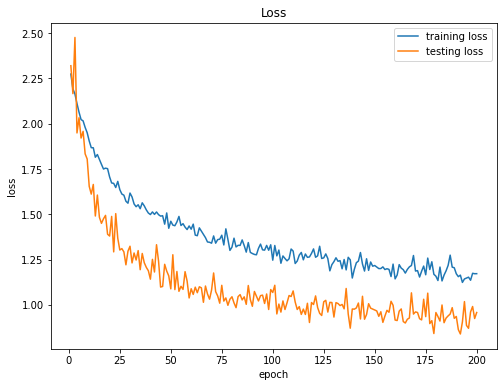

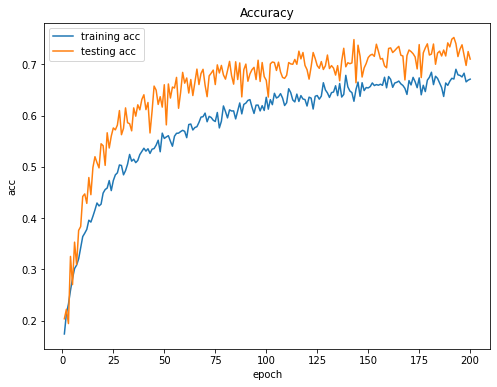

FOLD 4
--------------------------------
in_features: 1024
out_features: None
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=F

Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.42it/s]


Epoch:   1 / 200
	Training   Acc: 0.178866 | loss: 2.268154
	Validation Acc: 0.233923 | loss: 2.172767
[ Valid | 001/200 ] loss = 2.17277, acc = 0.23392 -> best
Saving model with acc 0.234


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.36it/s]


Epoch:   2 / 200
	Training   Acc: 0.215910 | loss: 2.195654
	Validation Acc: 0.264761 | loss: 2.096762
[ Valid | 002/200 ] loss = 2.09676, acc = 0.26476 -> best
Saving model with acc 0.265


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.31it/s]


Epoch:   3 / 200
	Training   Acc: 0.229670 | loss: 2.165615
	Validation Acc: 0.256863 | loss: 2.180260
[ Valid | 003/200 ] loss = 2.18026, acc = 0.25686


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.53it/s]


Epoch:   4 / 200
	Training   Acc: 0.250640 | loss: 2.123621
	Validation Acc: 0.295224 | loss: 2.020566
[ Valid | 004/200 ] loss = 2.02057, acc = 0.29522 -> best
Saving model with acc 0.295


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.66it/s]


Epoch:   5 / 200
	Training   Acc: 0.267207 | loss: 2.092973
	Validation Acc: 0.324558 | loss: 1.963832
[ Valid | 005/200 ] loss = 1.96383, acc = 0.32456 -> best
Saving model with acc 0.325


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.49it/s]


Epoch:   6 / 200
	Training   Acc: 0.290530 | loss: 2.046410
	Validation Acc: 0.342986 | loss: 1.868943
[ Valid | 006/200 ] loss = 1.86894, acc = 0.34299 -> best
Saving model with acc 0.343


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.13it/s]


Epoch:   7 / 200
	Training   Acc: 0.303064 | loss: 2.022685
	Validation Acc: 0.335088 | loss: 1.893580
[ Valid | 007/200 ] loss = 1.89358, acc = 0.33509


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.00it/s]


Epoch:   8 / 200
	Training   Acc: 0.318487 | loss: 1.991294
	Validation Acc: 0.391124 | loss: 1.762163
[ Valid | 008/200 ] loss = 1.76216, acc = 0.39112 -> best
Saving model with acc 0.391


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.15it/s]


Epoch:   9 / 200
	Training   Acc: 0.336178 | loss: 1.942494
	Validation Acc: 0.402031 | loss: 1.759898
[ Valid | 009/200 ] loss = 1.75990, acc = 0.40203 -> best
Saving model with acc 0.402


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.15it/s]


Epoch:  10 / 200
	Training   Acc: 0.338019 | loss: 1.948942
	Validation Acc: 0.420835 | loss: 1.736211
[ Valid | 010/200 ] loss = 1.73621, acc = 0.42083 -> best
Saving model with acc 0.421


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.96it/s]


Epoch:  11 / 200
	Training   Acc: 0.357964 | loss: 1.895470
	Validation Acc: 0.351636 | loss: 1.861482
[ Valid | 011/200 ] loss = 1.86148, acc = 0.35164


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.56it/s]


Epoch:  12 / 200
	Training   Acc: 0.375714 | loss: 1.875041
	Validation Acc: 0.459195 | loss: 1.629346
[ Valid | 012/200 ] loss = 1.62935, acc = 0.45920 -> best
Saving model with acc 0.459


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.32it/s]


Epoch:  13 / 200
	Training   Acc: 0.379405 | loss: 1.857695
	Validation Acc: 0.458067 | loss: 1.600763
[ Valid | 013/200 ] loss = 1.60076, acc = 0.45807


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.35it/s]


Epoch:  14 / 200
	Training   Acc: 0.396537 | loss: 1.820182
	Validation Acc: 0.445656 | loss: 1.664743
[ Valid | 014/200 ] loss = 1.66474, acc = 0.44566


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.34it/s]


Epoch:  15 / 200
	Training   Acc: 0.409358 | loss: 1.792955
	Validation Acc: 0.485521 | loss: 1.512998
[ Valid | 015/200 ] loss = 1.51300, acc = 0.48552 -> best
Saving model with acc 0.486


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.90it/s]


Epoch:  16 / 200
	Training   Acc: 0.412390 | loss: 1.788996
	Validation Acc: 0.468973 | loss: 1.539571
[ Valid | 016/200 ] loss = 1.53957, acc = 0.46897


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.41it/s]


Epoch:  17 / 200
	Training   Acc: 0.430861 | loss: 1.743236
	Validation Acc: 0.514479 | loss: 1.422074
[ Valid | 017/200 ] loss = 1.42207, acc = 0.51448 -> best
Saving model with acc 0.514


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.47it/s]


Epoch:  18 / 200
	Training   Acc: 0.435154 | loss: 1.735057
	Validation Acc: 0.528018 | loss: 1.429826
[ Valid | 018/200 ] loss = 1.42983, acc = 0.52802 -> best
Saving model with acc 0.528


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.13it/s]


Epoch:  19 / 200
	Training   Acc: 0.438305 | loss: 1.730664
	Validation Acc: 0.490034 | loss: 1.482926
[ Valid | 019/200 ] loss = 1.48293, acc = 0.49003


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.47it/s]


Epoch:  20 / 200
	Training   Acc: 0.450504 | loss: 1.702180
	Validation Acc: 0.522753 | loss: 1.424502
[ Valid | 020/200 ] loss = 1.42450, acc = 0.52275


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.25it/s]


Epoch:  21 / 200
	Training   Acc: 0.463470 | loss: 1.662186
	Validation Acc: 0.541557 | loss: 1.383240
[ Valid | 021/200 ] loss = 1.38324, acc = 0.54156 -> best
Saving model with acc 0.542


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.20it/s]


Epoch:  22 / 200
	Training   Acc: 0.449101 | loss: 1.712015
	Validation Acc: 0.566754 | loss: 1.315795
[ Valid | 022/200 ] loss = 1.31580, acc = 0.56675 -> best
Saving model with acc 0.567


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.18it/s]


Epoch:  23 / 200
	Training   Acc: 0.466279 | loss: 1.658727
	Validation Acc: 0.590071 | loss: 1.254530
[ Valid | 023/200 ] loss = 1.25453, acc = 0.59007 -> best
Saving model with acc 0.590


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.59it/s]


Epoch:  24 / 200
	Training   Acc: 0.482448 | loss: 1.620488
	Validation Acc: 0.537044 | loss: 1.389092
[ Valid | 024/200 ] loss = 1.38909, acc = 0.53704


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.57it/s]


Epoch:  25 / 200
	Training   Acc: 0.474587 | loss: 1.641960
	Validation Acc: 0.556976 | loss: 1.316391
[ Valid | 025/200 ] loss = 1.31639, acc = 0.55698


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.66it/s]


Epoch:  26 / 200
	Training   Acc: 0.470172 | loss: 1.648067
	Validation Acc: 0.623919 | loss: 1.245284
[ Valid | 026/200 ] loss = 1.24528, acc = 0.62392 -> best
Saving model with acc 0.624


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.20it/s]


Epoch:  27 / 200
	Training   Acc: 0.488080 | loss: 1.614704
	Validation Acc: 0.592328 | loss: 1.243969
[ Valid | 027/200 ] loss = 1.24397, acc = 0.59233


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.40it/s]


Epoch:  28 / 200
	Training   Acc: 0.491235 | loss: 1.577400
	Validation Acc: 0.592704 | loss: 1.269583
[ Valid | 028/200 ] loss = 1.26958, acc = 0.59270


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.32it/s]


Epoch:  29 / 200
	Training   Acc: 0.471816 | loss: 1.646396
	Validation Acc: 0.618654 | loss: 1.225188
[ Valid | 029/200 ] loss = 1.22519, acc = 0.61865


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.72it/s]


Epoch:  30 / 200
	Training   Acc: 0.489477 | loss: 1.617753
	Validation Acc: 0.606619 | loss: 1.224311
[ Valid | 030/200 ] loss = 1.22431, acc = 0.60662


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.70it/s]


Epoch:  31 / 200
	Training   Acc: 0.487231 | loss: 1.612077
	Validation Acc: 0.599097 | loss: 1.269946
[ Valid | 031/200 ] loss = 1.26995, acc = 0.59910


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.25it/s]


Epoch:  32 / 200
	Training   Acc: 0.495945 | loss: 1.595660
	Validation Acc: 0.613765 | loss: 1.158581
[ Valid | 032/200 ] loss = 1.15858, acc = 0.61376


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.16it/s]


Epoch:  33 / 200
	Training   Acc: 0.516984 | loss: 1.544284
	Validation Acc: 0.555472 | loss: 1.321964
[ Valid | 033/200 ] loss = 1.32196, acc = 0.55547


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.15it/s]


Epoch:  34 / 200
	Training   Acc: 0.525195 | loss: 1.521236
	Validation Acc: 0.600978 | loss: 1.218246
[ Valid | 034/200 ] loss = 1.21825, acc = 0.60098


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.54it/s]


Epoch:  35 / 200
	Training   Acc: 0.522518 | loss: 1.512026
	Validation Acc: 0.655510 | loss: 1.106127
[ Valid | 035/200 ] loss = 1.10613, acc = 0.65551 -> best
Saving model with acc 0.656


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.33it/s]


Epoch:  36 / 200
	Training   Acc: 0.516240 | loss: 1.538472
	Validation Acc: 0.643475 | loss: 1.155273
[ Valid | 036/200 ] loss = 1.15527, acc = 0.64347


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.32it/s]


Epoch:  37 / 200
	Training   Acc: 0.517859 | loss: 1.540113
	Validation Acc: 0.603234 | loss: 1.237910
[ Valid | 037/200 ] loss = 1.23791, acc = 0.60323


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.31it/s]


Epoch:  38 / 200
	Training   Acc: 0.527317 | loss: 1.502307
	Validation Acc: 0.661527 | loss: 1.103561
[ Valid | 038/200 ] loss = 1.10356, acc = 0.66153 -> best
Saving model with acc 0.662


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.40it/s]


Epoch:  39 / 200
	Training   Acc: 0.547479 | loss: 1.468504
	Validation Acc: 0.635577 | loss: 1.125048
[ Valid | 039/200 ] loss = 1.12505, acc = 0.63558


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.04it/s]


Epoch:  40 / 200
	Training   Acc: 0.527626 | loss: 1.516744
	Validation Acc: 0.637082 | loss: 1.136054
[ Valid | 040/200 ] loss = 1.13605, acc = 0.63708


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.43it/s]


Epoch:  41 / 200
	Training   Acc: 0.528513 | loss: 1.511046
	Validation Acc: 0.628056 | loss: 1.125676
[ Valid | 041/200 ] loss = 1.12568, acc = 0.62806


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.42it/s]


Epoch:  42 / 200
	Training   Acc: 0.532683 | loss: 1.501116
	Validation Acc: 0.638210 | loss: 1.127952
[ Valid | 042/200 ] loss = 1.12795, acc = 0.63821


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.34it/s]


Epoch:  43 / 200
	Training   Acc: 0.542436 | loss: 1.481892
	Validation Acc: 0.650244 | loss: 1.088352
[ Valid | 043/200 ] loss = 1.08835, acc = 0.65024


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.14it/s]


Epoch:  44 / 200
	Training   Acc: 0.519163 | loss: 1.546415
	Validation Acc: 0.682587 | loss: 1.090368
[ Valid | 044/200 ] loss = 1.09037, acc = 0.68259 -> best
Saving model with acc 0.683


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.39it/s]


Epoch:  45 / 200
	Training   Acc: 0.533929 | loss: 1.504436
	Validation Acc: 0.643851 | loss: 1.112507
[ Valid | 045/200 ] loss = 1.11251, acc = 0.64385


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.09it/s]


Epoch:  46 / 200
	Training   Acc: 0.539284 | loss: 1.484118
	Validation Acc: 0.658518 | loss: 1.041061
[ Valid | 046/200 ] loss = 1.04106, acc = 0.65852


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.20it/s]


Epoch:  47 / 200
	Training   Acc: 0.544148 | loss: 1.475362
	Validation Acc: 0.619782 | loss: 1.200196
[ Valid | 047/200 ] loss = 1.20020, acc = 0.61978


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.29it/s]


Epoch:  48 / 200
	Training   Acc: 0.556851 | loss: 1.451279
	Validation Acc: 0.626551 | loss: 1.172518
[ Valid | 048/200 ] loss = 1.17252, acc = 0.62655


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.03it/s]


Epoch:  49 / 200
	Training   Acc: 0.570242 | loss: 1.407252
	Validation Acc: 0.637082 | loss: 1.106120
[ Valid | 049/200 ] loss = 1.10612, acc = 0.63708


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.31it/s]


Epoch:  50 / 200
	Training   Acc: 0.533677 | loss: 1.501815
	Validation Acc: 0.650244 | loss: 1.154399
[ Valid | 050/200 ] loss = 1.15440, acc = 0.65024


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.45it/s]


Epoch:  51 / 200
	Training   Acc: 0.576404 | loss: 1.401480
	Validation Acc: 0.656638 | loss: 1.098564
[ Valid | 051/200 ] loss = 1.09856, acc = 0.65664


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.92it/s]


Epoch:  52 / 200
	Training   Acc: 0.566669 | loss: 1.415441
	Validation Acc: 0.597969 | loss: 1.187340
[ Valid | 052/200 ] loss = 1.18734, acc = 0.59797


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.26it/s]


Epoch:  53 / 200
	Training   Acc: 0.550094 | loss: 1.467030
	Validation Acc: 0.651373 | loss: 1.110188
[ Valid | 053/200 ] loss = 1.11019, acc = 0.65137


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.14it/s]


Epoch:  54 / 200
	Training   Acc: 0.550887 | loss: 1.465845
	Validation Acc: 0.595337 | loss: 1.220383
[ Valid | 054/200 ] loss = 1.22038, acc = 0.59534


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.58it/s]


Epoch:  55 / 200
	Training   Acc: 0.556408 | loss: 1.447987
	Validation Acc: 0.694622 | loss: 0.992653
[ Valid | 055/200 ] loss = 0.99265, acc = 0.69462 -> best
Saving model with acc 0.695


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.40it/s]


Epoch:  56 / 200
	Training   Acc: 0.560858 | loss: 1.447136
	Validation Acc: 0.655510 | loss: 1.032006
[ Valid | 056/200 ] loss = 1.03201, acc = 0.65551


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.18it/s]


Epoch:  57 / 200
	Training   Acc: 0.557456 | loss: 1.447957
	Validation Acc: 0.677698 | loss: 1.044236
[ Valid | 057/200 ] loss = 1.04424, acc = 0.67770


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.59it/s]


Epoch:  58 / 200
	Training   Acc: 0.553622 | loss: 1.471502
	Validation Acc: 0.680331 | loss: 1.005656
[ Valid | 058/200 ] loss = 1.00566, acc = 0.68033


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.56it/s]


Epoch:  59 / 200
	Training   Acc: 0.554350 | loss: 1.459433
	Validation Acc: 0.673185 | loss: 1.047071
[ Valid | 059/200 ] loss = 1.04707, acc = 0.67319


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.26it/s]


Epoch:  60 / 200
	Training   Acc: 0.588797 | loss: 1.376602
	Validation Acc: 0.681083 | loss: 1.027849
[ Valid | 060/200 ] loss = 1.02785, acc = 0.68108


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.34it/s]


Epoch:  61 / 200
	Training   Acc: 0.585423 | loss: 1.371139
	Validation Acc: 0.686724 | loss: 1.016004
[ Valid | 061/200 ] loss = 1.01600, acc = 0.68672


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.36it/s]


Epoch:  62 / 200
	Training   Acc: 0.574703 | loss: 1.404198
	Validation Acc: 0.675066 | loss: 1.013267
[ Valid | 062/200 ] loss = 1.01327, acc = 0.67507


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch:  63 / 200
	Training   Acc: 0.577401 | loss: 1.401210
	Validation Acc: 0.684844 | loss: 1.059034
[ Valid | 063/200 ] loss = 1.05903, acc = 0.68484


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.60it/s]


Epoch:  64 / 200
	Training   Acc: 0.581787 | loss: 1.382049
	Validation Acc: 0.679203 | loss: 1.047707
[ Valid | 064/200 ] loss = 1.04771, acc = 0.67920


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.93it/s]


Epoch:  65 / 200
	Training   Acc: 0.582321 | loss: 1.399095
	Validation Acc: 0.640842 | loss: 1.140187
[ Valid | 065/200 ] loss = 1.14019, acc = 0.64084


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.67it/s]


Epoch:  66 / 200
	Training   Acc: 0.573363 | loss: 1.416226
	Validation Acc: 0.672433 | loss: 1.001839
[ Valid | 066/200 ] loss = 1.00184, acc = 0.67243


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.53it/s]


Epoch:  67 / 200
	Training   Acc: 0.595256 | loss: 1.363162
	Validation Acc: 0.676194 | loss: 1.060520
[ Valid | 067/200 ] loss = 1.06052, acc = 0.67619


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.17it/s]


Epoch:  68 / 200
	Training   Acc: 0.576394 | loss: 1.401287
	Validation Acc: 0.687100 | loss: 0.962211
[ Valid | 068/200 ] loss = 0.96221, acc = 0.68710


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.47it/s]


Epoch:  69 / 200
	Training   Acc: 0.565836 | loss: 1.432488
	Validation Acc: 0.651749 | loss: 1.113322
[ Valid | 069/200 ] loss = 1.11332, acc = 0.65175


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.58it/s]


Epoch:  70 / 200
	Training   Acc: 0.593741 | loss: 1.362986
	Validation Acc: 0.689357 | loss: 0.986391
[ Valid | 070/200 ] loss = 0.98639, acc = 0.68936


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.94it/s]


Epoch:  71 / 200
	Training   Acc: 0.592330 | loss: 1.359402
	Validation Acc: 0.655510 | loss: 1.106654
[ Valid | 071/200 ] loss = 1.10665, acc = 0.65551


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.17it/s]


Epoch:  72 / 200
	Training   Acc: 0.582593 | loss: 1.388433
	Validation Acc: 0.681459 | loss: 1.014124
[ Valid | 072/200 ] loss = 1.01412, acc = 0.68146


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch:  73 / 200
	Training   Acc: 0.607203 | loss: 1.329283
	Validation Acc: 0.619782 | loss: 1.168645
[ Valid | 073/200 ] loss = 1.16865, acc = 0.61978


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.42it/s]


Epoch:  74 / 200
	Training   Acc: 0.594739 | loss: 1.369538
	Validation Acc: 0.690861 | loss: 1.025891
[ Valid | 074/200 ] loss = 1.02589, acc = 0.69086


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.26it/s]


Epoch:  75 / 200
	Training   Acc: 0.600864 | loss: 1.333243
	Validation Acc: 0.668672 | loss: 1.100636
[ Valid | 075/200 ] loss = 1.10064, acc = 0.66867


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.29it/s]


Epoch:  76 / 200
	Training   Acc: 0.587592 | loss: 1.377624
	Validation Acc: 0.681835 | loss: 1.026369
[ Valid | 076/200 ] loss = 1.02637, acc = 0.68184


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.61it/s]


Epoch:  77 / 200
	Training   Acc: 0.596767 | loss: 1.357646
	Validation Acc: 0.696126 | loss: 1.007857
[ Valid | 077/200 ] loss = 1.00786, acc = 0.69613 -> best
Saving model with acc 0.696


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.18it/s]


Epoch:  78 / 200
	Training   Acc: 0.587484 | loss: 1.371239
	Validation Acc: 0.685972 | loss: 1.027788
[ Valid | 078/200 ] loss = 1.02779, acc = 0.68597


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.55it/s]


Epoch:  79 / 200
	Training   Acc: 0.606567 | loss: 1.329800
	Validation Acc: 0.701768 | loss: 0.994511
[ Valid | 079/200 ] loss = 0.99451, acc = 0.70177 -> best
Saving model with acc 0.702


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.62it/s]


Epoch:  80 / 200
	Training   Acc: 0.609589 | loss: 1.313552
	Validation Acc: 0.651749 | loss: 1.108322
[ Valid | 080/200 ] loss = 1.10832, acc = 0.65175


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.26it/s]


Epoch:  81 / 200
	Training   Acc: 0.595083 | loss: 1.369788
	Validation Acc: 0.684092 | loss: 1.020356
[ Valid | 081/200 ] loss = 1.02036, acc = 0.68409


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.27it/s]


Epoch:  82 / 200
	Training   Acc: 0.601612 | loss: 1.346405
	Validation Acc: 0.701015 | loss: 0.988971
[ Valid | 082/200 ] loss = 0.98897, acc = 0.70102


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.56it/s]


Epoch:  83 / 200
	Training   Acc: 0.603378 | loss: 1.335375
	Validation Acc: 0.713426 | loss: 0.941872
[ Valid | 083/200 ] loss = 0.94187, acc = 0.71343 -> best
Saving model with acc 0.713


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.18it/s]


Epoch:  84 / 200
	Training   Acc: 0.591407 | loss: 1.383891
	Validation Acc: 0.714930 | loss: 0.972284
[ Valid | 084/200 ] loss = 0.97228, acc = 0.71493 -> best
Saving model with acc 0.715


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.42it/s]


Epoch:  85 / 200
	Training   Acc: 0.596570 | loss: 1.361038
	Validation Acc: 0.693870 | loss: 1.036482
[ Valid | 085/200 ] loss = 1.03648, acc = 0.69387


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.18it/s]


Epoch:  86 / 200
	Training   Acc: 0.618184 | loss: 1.291936
	Validation Acc: 0.699511 | loss: 0.974823
[ Valid | 086/200 ] loss = 0.97482, acc = 0.69951


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch:  87 / 200
	Training   Acc: 0.605000 | loss: 1.332728
	Validation Acc: 0.692366 | loss: 1.004792
[ Valid | 087/200 ] loss = 1.00479, acc = 0.69237


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.03it/s]


Epoch:  88 / 200
	Training   Acc: 0.597876 | loss: 1.347352
	Validation Acc: 0.715307 | loss: 0.983436
[ Valid | 088/200 ] loss = 0.98344, acc = 0.71531 -> best
Saving model with acc 0.715


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.50it/s]


Epoch:  89 / 200
	Training   Acc: 0.627342 | loss: 1.278422
	Validation Acc: 0.699887 | loss: 0.993797
[ Valid | 089/200 ] loss = 0.99380, acc = 0.69989


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.59it/s]


Epoch:  90 / 200
	Training   Acc: 0.623305 | loss: 1.280908
	Validation Acc: 0.684092 | loss: 1.004832
[ Valid | 090/200 ] loss = 1.00483, acc = 0.68409


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.47it/s]


Epoch:  91 / 200
	Training   Acc: 0.621824 | loss: 1.283539
	Validation Acc: 0.685596 | loss: 0.998497
[ Valid | 091/200 ] loss = 0.99850, acc = 0.68560


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.01it/s]


Epoch:  92 / 200
	Training   Acc: 0.619439 | loss: 1.298704
	Validation Acc: 0.657766 | loss: 1.049807
[ Valid | 092/200 ] loss = 1.04981, acc = 0.65777


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.29it/s]


Epoch:  93 / 200
	Training   Acc: 0.629107 | loss: 1.282830
	Validation Acc: 0.704024 | loss: 0.962818
[ Valid | 093/200 ] loss = 0.96282, acc = 0.70402


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.07it/s]


Epoch:  94 / 200
	Training   Acc: 0.602122 | loss: 1.350231
	Validation Acc: 0.696126 | loss: 0.980709
[ Valid | 094/200 ] loss = 0.98071, acc = 0.69613


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.40it/s]


Epoch:  95 / 200
	Training   Acc: 0.607222 | loss: 1.342961
	Validation Acc: 0.719443 | loss: 0.940105
[ Valid | 095/200 ] loss = 0.94011, acc = 0.71944 -> best
Saving model with acc 0.719


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.25it/s]


Epoch:  96 / 200
	Training   Acc: 0.610999 | loss: 1.329040
	Validation Acc: 0.716811 | loss: 0.939649
[ Valid | 096/200 ] loss = 0.93965, acc = 0.71681


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.22it/s]


Epoch:  97 / 200
	Training   Acc: 0.634700 | loss: 1.251575
	Validation Acc: 0.723580 | loss: 0.916502
[ Valid | 097/200 ] loss = 0.91650, acc = 0.72358 -> best
Saving model with acc 0.724


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.14it/s]


Epoch:  98 / 200
	Training   Acc: 0.636082 | loss: 1.256629
	Validation Acc: 0.717939 | loss: 0.934465
[ Valid | 098/200 ] loss = 0.93447, acc = 0.71794


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.56it/s]


Epoch:  99 / 200
	Training   Acc: 0.635195 | loss: 1.258644
	Validation Acc: 0.698759 | loss: 0.949886
[ Valid | 099/200 ] loss = 0.94989, acc = 0.69876


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.25it/s]


Epoch: 100 / 200
	Training   Acc: 0.621024 | loss: 1.299645
	Validation Acc: 0.708161 | loss: 0.909610
[ Valid | 100/200 ] loss = 0.90961, acc = 0.70816


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.26it/s]


Epoch: 101 / 200
	Training   Acc: 0.598769 | loss: 1.355590
	Validation Acc: 0.714554 | loss: 0.976664
[ Valid | 101/200 ] loss = 0.97666, acc = 0.71455


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.59it/s]


Epoch: 102 / 200
	Training   Acc: 0.611601 | loss: 1.323970
	Validation Acc: 0.704776 | loss: 0.950593
[ Valid | 102/200 ] loss = 0.95059, acc = 0.70478


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.37it/s]


Epoch: 103 / 200
	Training   Acc: 0.636288 | loss: 1.270011
	Validation Acc: 0.703272 | loss: 0.966884
[ Valid | 103/200 ] loss = 0.96688, acc = 0.70327


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.94it/s]


Epoch: 104 / 200
	Training   Acc: 0.611454 | loss: 1.314532
	Validation Acc: 0.719819 | loss: 0.958125
[ Valid | 104/200 ] loss = 0.95813, acc = 0.71982


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.19it/s]


Epoch: 105 / 200
	Training   Acc: 0.648906 | loss: 1.225480
	Validation Acc: 0.703272 | loss: 0.967812
[ Valid | 105/200 ] loss = 0.96781, acc = 0.70327


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.32it/s]


Epoch: 106 / 200
	Training   Acc: 0.628621 | loss: 1.284328
	Validation Acc: 0.731478 | loss: 0.905469
[ Valid | 106/200 ] loss = 0.90547, acc = 0.73148 -> best
Saving model with acc 0.731


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.21it/s]


Epoch: 107 / 200
	Training   Acc: 0.636585 | loss: 1.275603
	Validation Acc: 0.706657 | loss: 0.978549
[ Valid | 107/200 ] loss = 0.97855, acc = 0.70666


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.28it/s]


Epoch: 108 / 200
	Training   Acc: 0.634925 | loss: 1.249946
	Validation Acc: 0.697255 | loss: 0.935470
[ Valid | 108/200 ] loss = 0.93547, acc = 0.69725


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.15it/s]


Epoch: 109 / 200
	Training   Acc: 0.642652 | loss: 1.248710
	Validation Acc: 0.709289 | loss: 0.957968
[ Valid | 109/200 ] loss = 0.95797, acc = 0.70929


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.45it/s]


Epoch: 110 / 200
	Training   Acc: 0.626780 | loss: 1.278731
	Validation Acc: 0.709665 | loss: 0.959329
[ Valid | 110/200 ] loss = 0.95933, acc = 0.70967


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.39it/s]


Epoch: 111 / 200
	Training   Acc: 0.622193 | loss: 1.304883
	Validation Acc: 0.713802 | loss: 0.942333
[ Valid | 111/200 ] loss = 0.94233, acc = 0.71380


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.22it/s]


Epoch: 112 / 200
	Training   Acc: 0.640809 | loss: 1.259821
	Validation Acc: 0.726589 | loss: 0.865652
[ Valid | 112/200 ] loss = 0.86565, acc = 0.72659


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.41it/s]


Epoch: 113 / 200
	Training   Acc: 0.645469 | loss: 1.238280
	Validation Acc: 0.701392 | loss: 0.970616
[ Valid | 113/200 ] loss = 0.97062, acc = 0.70139


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.43it/s]


Epoch: 114 / 200
	Training   Acc: 0.652601 | loss: 1.211145
	Validation Acc: 0.691613 | loss: 0.989514
[ Valid | 114/200 ] loss = 0.98951, acc = 0.69161


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.98it/s]


Epoch: 115 / 200
	Training   Acc: 0.633839 | loss: 1.275971
	Validation Acc: 0.691613 | loss: 1.023444
[ Valid | 115/200 ] loss = 1.02344, acc = 0.69161


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.57it/s]


Epoch: 116 / 200
	Training   Acc: 0.648710 | loss: 1.228827
	Validation Acc: 0.736367 | loss: 0.894137
[ Valid | 116/200 ] loss = 0.89414, acc = 0.73637 -> best
Saving model with acc 0.736


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.18it/s]


Epoch: 117 / 200
	Training   Acc: 0.640710 | loss: 1.235747
	Validation Acc: 0.721324 | loss: 0.923833
[ Valid | 117/200 ] loss = 0.92383, acc = 0.72132


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.36it/s]


Epoch: 118 / 200
	Training   Acc: 0.657646 | loss: 1.183462
	Validation Acc: 0.697631 | loss: 0.983646
[ Valid | 118/200 ] loss = 0.98365, acc = 0.69763


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.32it/s]


Epoch: 119 / 200
	Training   Acc: 0.618829 | loss: 1.327895
	Validation Acc: 0.722828 | loss: 0.951272
[ Valid | 119/200 ] loss = 0.95127, acc = 0.72283


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.38it/s]


Epoch: 120 / 200
	Training   Acc: 0.638223 | loss: 1.251118
	Validation Acc: 0.693494 | loss: 0.978137
[ Valid | 120/200 ] loss = 0.97814, acc = 0.69349


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.42it/s]


Epoch: 121 / 200
	Training   Acc: 0.633374 | loss: 1.265492
	Validation Acc: 0.714178 | loss: 0.946168
[ Valid | 121/200 ] loss = 0.94617, acc = 0.71418


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.44it/s]


Epoch: 122 / 200
	Training   Acc: 0.638907 | loss: 1.252676
	Validation Acc: 0.671681 | loss: 1.061161
[ Valid | 122/200 ] loss = 1.06116, acc = 0.67168


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.63it/s]


Epoch: 123 / 200
	Training   Acc: 0.634638 | loss: 1.260551
	Validation Acc: 0.701015 | loss: 0.937337
[ Valid | 123/200 ] loss = 0.93734, acc = 0.70102


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.78it/s]


Epoch: 124 / 200
	Training   Acc: 0.648843 | loss: 1.238365
	Validation Acc: 0.689357 | loss: 1.008426
[ Valid | 124/200 ] loss = 1.00843, acc = 0.68936


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.14it/s]


Epoch: 125 / 200
	Training   Acc: 0.635826 | loss: 1.266755
	Validation Acc: 0.693494 | loss: 0.987477
[ Valid | 125/200 ] loss = 0.98748, acc = 0.69349


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.21it/s]


Epoch: 126 / 200
	Training   Acc: 0.649170 | loss: 1.228083
	Validation Acc: 0.714178 | loss: 0.925080
[ Valid | 126/200 ] loss = 0.92508, acc = 0.71418


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.35it/s]


Epoch: 127 / 200
	Training   Acc: 0.643467 | loss: 1.254491
	Validation Acc: 0.714178 | loss: 0.932944
[ Valid | 127/200 ] loss = 0.93294, acc = 0.71418


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.28it/s]


Epoch: 128 / 200
	Training   Acc: 0.664465 | loss: 1.187761
	Validation Acc: 0.719067 | loss: 0.936924
[ Valid | 128/200 ] loss = 0.93692, acc = 0.71907


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.57it/s]


Epoch: 129 / 200
	Training   Acc: 0.636122 | loss: 1.260893
	Validation Acc: 0.733358 | loss: 0.870859
[ Valid | 129/200 ] loss = 0.87086, acc = 0.73336


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.88it/s]


Epoch: 130 / 200
	Training   Acc: 0.633221 | loss: 1.272542
	Validation Acc: 0.708537 | loss: 0.925809
[ Valid | 130/200 ] loss = 0.92581, acc = 0.70854


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.31it/s]


Epoch: 131 / 200
	Training   Acc: 0.653656 | loss: 1.217862
	Validation Acc: 0.702520 | loss: 0.950657
[ Valid | 131/200 ] loss = 0.95066, acc = 0.70252


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.40it/s]


Epoch: 132 / 200
	Training   Acc: 0.638861 | loss: 1.272284
	Validation Acc: 0.738247 | loss: 0.879980
[ Valid | 132/200 ] loss = 0.87998, acc = 0.73825 -> best
Saving model with acc 0.738


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.37it/s]


Epoch: 133 / 200
	Training   Acc: 0.661402 | loss: 1.195066
	Validation Acc: 0.732230 | loss: 0.896999
[ Valid | 133/200 ] loss = 0.89700, acc = 0.73223


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.43it/s]


Epoch: 134 / 200
	Training   Acc: 0.646484 | loss: 1.224715
	Validation Acc: 0.717939 | loss: 0.897371
[ Valid | 134/200 ] loss = 0.89737, acc = 0.71794


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch: 135 / 200
	Training   Acc: 0.635607 | loss: 1.261861
	Validation Acc: 0.710417 | loss: 0.943220
[ Valid | 135/200 ] loss = 0.94322, acc = 0.71042


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.27it/s]


Epoch: 136 / 200
	Training   Acc: 0.662819 | loss: 1.191579
	Validation Acc: 0.710417 | loss: 0.899423
[ Valid | 136/200 ] loss = 0.89942, acc = 0.71042


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.17it/s]


Epoch: 137 / 200
	Training   Acc: 0.653910 | loss: 1.224059
	Validation Acc: 0.702896 | loss: 0.942676
[ Valid | 137/200 ] loss = 0.94268, acc = 0.70290


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.09it/s]


Epoch: 138 / 200
	Training   Acc: 0.654579 | loss: 1.212063
	Validation Acc: 0.723204 | loss: 0.897096
[ Valid | 138/200 ] loss = 0.89710, acc = 0.72320


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.35it/s]


Epoch: 139 / 200
	Training   Acc: 0.642930 | loss: 1.237557
	Validation Acc: 0.729222 | loss: 0.941184
[ Valid | 139/200 ] loss = 0.94118, acc = 0.72922


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.72it/s]


Epoch: 140 / 200
	Training   Acc: 0.651262 | loss: 1.225303
	Validation Acc: 0.701015 | loss: 0.951130
[ Valid | 140/200 ] loss = 0.95113, acc = 0.70102


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.14it/s]


Epoch: 141 / 200
	Training   Acc: 0.612387 | loss: 1.331914
	Validation Acc: 0.695750 | loss: 0.987444
[ Valid | 141/200 ] loss = 0.98744, acc = 0.69575


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.35it/s]


Epoch: 142 / 200
	Training   Acc: 0.639055 | loss: 1.250967
	Validation Acc: 0.717939 | loss: 0.952688
[ Valid | 142/200 ] loss = 0.95269, acc = 0.71794


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.98it/s]


Epoch: 143 / 200
	Training   Acc: 0.656571 | loss: 1.195704
	Validation Acc: 0.715307 | loss: 0.946911
[ Valid | 143/200 ] loss = 0.94691, acc = 0.71531


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.54it/s]


Epoch: 144 / 200
	Training   Acc: 0.641212 | loss: 1.241167
	Validation Acc: 0.730726 | loss: 0.872153
[ Valid | 144/200 ] loss = 0.87215, acc = 0.73073


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.34it/s]


Epoch: 145 / 200
	Training   Acc: 0.649885 | loss: 1.218763
	Validation Acc: 0.710794 | loss: 0.933355
[ Valid | 145/200 ] loss = 0.93336, acc = 0.71079


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.29it/s]


Epoch: 146 / 200
	Training   Acc: 0.650567 | loss: 1.224953
	Validation Acc: 0.742384 | loss: 0.895372
[ Valid | 146/200 ] loss = 0.89537, acc = 0.74238 -> best
Saving model with acc 0.742


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch: 147 / 200
	Training   Acc: 0.662710 | loss: 1.192397
	Validation Acc: 0.735991 | loss: 0.897044
[ Valid | 147/200 ] loss = 0.89704, acc = 0.73599


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.56it/s]


Epoch: 148 / 200
	Training   Acc: 0.658380 | loss: 1.206071
	Validation Acc: 0.692366 | loss: 0.961340
[ Valid | 148/200 ] loss = 0.96134, acc = 0.69237


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.80it/s]


Epoch: 149 / 200
	Training   Acc: 0.642673 | loss: 1.239230
	Validation Acc: 0.714930 | loss: 0.915233
[ Valid | 149/200 ] loss = 0.91523, acc = 0.71493


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.78it/s]


Epoch: 150 / 200
	Training   Acc: 0.651659 | loss: 1.211685
	Validation Acc: 0.724709 | loss: 0.882460
[ Valid | 150/200 ] loss = 0.88246, acc = 0.72471


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.43it/s]


Epoch: 151 / 200
	Training   Acc: 0.651742 | loss: 1.216392
	Validation Acc: 0.723956 | loss: 0.908446
[ Valid | 151/200 ] loss = 0.90845, acc = 0.72396


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.31it/s]


Epoch: 152 / 200
	Training   Acc: 0.661122 | loss: 1.197760
	Validation Acc: 0.733734 | loss: 0.861405
[ Valid | 152/200 ] loss = 0.86140, acc = 0.73373


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.07it/s]


Epoch: 153 / 200
	Training   Acc: 0.650768 | loss: 1.218759
	Validation Acc: 0.729598 | loss: 0.895175
[ Valid | 153/200 ] loss = 0.89517, acc = 0.72960


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.94it/s]


Epoch: 154 / 200
	Training   Acc: 0.653560 | loss: 1.210846
	Validation Acc: 0.733734 | loss: 0.918290
[ Valid | 154/200 ] loss = 0.91829, acc = 0.73373


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch: 155 / 200
	Training   Acc: 0.658954 | loss: 1.222003
	Validation Acc: 0.731854 | loss: 0.919581
[ Valid | 155/200 ] loss = 0.91958, acc = 0.73185


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.04it/s]


Epoch: 156 / 200
	Training   Acc: 0.664929 | loss: 1.180390
	Validation Acc: 0.736743 | loss: 0.899847
[ Valid | 156/200 ] loss = 0.89985, acc = 0.73674


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.88it/s]


Epoch: 157 / 200
	Training   Acc: 0.650162 | loss: 1.237549
	Validation Acc: 0.750282 | loss: 0.913329
[ Valid | 157/200 ] loss = 0.91333, acc = 0.75028 -> best
Saving model with acc 0.750


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.57it/s]


Epoch: 158 / 200
	Training   Acc: 0.669444 | loss: 1.182386
	Validation Acc: 0.731478 | loss: 0.930746
[ Valid | 158/200 ] loss = 0.93075, acc = 0.73148


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch: 159 / 200
	Training   Acc: 0.667052 | loss: 1.184927
	Validation Acc: 0.743513 | loss: 0.859013
[ Valid | 159/200 ] loss = 0.85901, acc = 0.74351


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.20it/s]


Epoch: 160 / 200
	Training   Acc: 0.649133 | loss: 1.234755
	Validation Acc: 0.655886 | loss: 1.082557
[ Valid | 160/200 ] loss = 1.08256, acc = 0.65589


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.27it/s]


Epoch: 161 / 200
	Training   Acc: 0.667578 | loss: 1.185359
	Validation Acc: 0.725461 | loss: 0.932904
[ Valid | 161/200 ] loss = 0.93290, acc = 0.72546


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.67it/s]


Epoch: 162 / 200
	Training   Acc: 0.666224 | loss: 1.183989
	Validation Acc: 0.717563 | loss: 0.953699
[ Valid | 162/200 ] loss = 0.95370, acc = 0.71756


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.41it/s]


Epoch: 163 / 200
	Training   Acc: 0.660432 | loss: 1.200225
	Validation Acc: 0.714178 | loss: 0.921818
[ Valid | 163/200 ] loss = 0.92182, acc = 0.71418


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.23it/s]


Epoch: 164 / 200
	Training   Acc: 0.659142 | loss: 1.197291
	Validation Acc: 0.741256 | loss: 0.869629
[ Valid | 164/200 ] loss = 0.86963, acc = 0.74126


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.59it/s]


Epoch: 165 / 200
	Training   Acc: 0.658890 | loss: 1.200071
	Validation Acc: 0.751786 | loss: 0.860662
[ Valid | 165/200 ] loss = 0.86066, acc = 0.75179 -> best
Saving model with acc 0.752


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.42it/s]


Epoch: 166 / 200
	Training   Acc: 0.660858 | loss: 1.184178
	Validation Acc: 0.701392 | loss: 0.991039
[ Valid | 166/200 ] loss = 0.99104, acc = 0.70139


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.45it/s]


Epoch: 167 / 200
	Training   Acc: 0.680474 | loss: 1.142990
	Validation Acc: 0.675066 | loss: 1.013950
[ Valid | 167/200 ] loss = 1.01395, acc = 0.67507


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.00it/s]


Epoch: 168 / 200
	Training   Acc: 0.648584 | loss: 1.246036
	Validation Acc: 0.737119 | loss: 0.895160
[ Valid | 168/200 ] loss = 0.89516, acc = 0.73712


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.23it/s]


Epoch: 169 / 200
	Training   Acc: 0.647098 | loss: 1.225802
	Validation Acc: 0.736367 | loss: 0.901351
[ Valid | 169/200 ] loss = 0.90135, acc = 0.73637


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.08it/s]


Epoch: 170 / 200
	Training   Acc: 0.669844 | loss: 1.182316
	Validation Acc: 0.715683 | loss: 0.921138
[ Valid | 170/200 ] loss = 0.92114, acc = 0.71568


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.44it/s]


Epoch: 171 / 200
	Training   Acc: 0.654780 | loss: 1.204927
	Validation Acc: 0.735991 | loss: 0.917543
[ Valid | 171/200 ] loss = 0.91754, acc = 0.73599


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.58it/s]


Epoch: 172 / 200
	Training   Acc: 0.678130 | loss: 1.147740
	Validation Acc: 0.736367 | loss: 0.886944
[ Valid | 172/200 ] loss = 0.88694, acc = 0.73637


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.61it/s]


Epoch: 173 / 200
	Training   Acc: 0.659106 | loss: 1.201681
	Validation Acc: 0.692742 | loss: 1.015735
[ Valid | 173/200 ] loss = 1.01574, acc = 0.69274


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.10it/s]


Epoch: 174 / 200
	Training   Acc: 0.666361 | loss: 1.188776
	Validation Acc: 0.748778 | loss: 0.825788
[ Valid | 174/200 ] loss = 0.82579, acc = 0.74878


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.88it/s]


Epoch: 175 / 200
	Training   Acc: 0.662771 | loss: 1.194549
	Validation Acc: 0.732606 | loss: 0.928149
[ Valid | 175/200 ] loss = 0.92815, acc = 0.73261


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.26it/s]


Epoch: 176 / 200
	Training   Acc: 0.662273 | loss: 1.195713
	Validation Acc: 0.734487 | loss: 0.917061
[ Valid | 176/200 ] loss = 0.91706, acc = 0.73449


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.83it/s]


Epoch: 177 / 200
	Training   Acc: 0.652550 | loss: 1.219111
	Validation Acc: 0.735239 | loss: 0.906182
[ Valid | 177/200 ] loss = 0.90618, acc = 0.73524


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.14it/s]


Epoch: 178 / 200
	Training   Acc: 0.670915 | loss: 1.172730
	Validation Acc: 0.682211 | loss: 1.009476
[ Valid | 178/200 ] loss = 1.00948, acc = 0.68221


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.07it/s]


Epoch: 179 / 200
	Training   Acc: 0.659114 | loss: 1.205826
	Validation Acc: 0.734111 | loss: 0.862466
[ Valid | 179/200 ] loss = 0.86247, acc = 0.73411


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.23it/s]


Epoch: 180 / 200
	Training   Acc: 0.673469 | loss: 1.167822
	Validation Acc: 0.740504 | loss: 0.889890
[ Valid | 180/200 ] loss = 0.88989, acc = 0.74050


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.55it/s]


Epoch: 181 / 200
	Training   Acc: 0.668310 | loss: 1.184330
	Validation Acc: 0.735615 | loss: 0.899053
[ Valid | 181/200 ] loss = 0.89905, acc = 0.73561


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.56it/s]


Epoch: 182 / 200
	Training   Acc: 0.677528 | loss: 1.163894
	Validation Acc: 0.725837 | loss: 0.930857
[ Valid | 182/200 ] loss = 0.93086, acc = 0.72584


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.35it/s]


Epoch: 183 / 200
	Training   Acc: 0.658807 | loss: 1.197363
	Validation Acc: 0.732606 | loss: 0.901104
[ Valid | 183/200 ] loss = 0.90110, acc = 0.73261


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.11it/s]


Epoch: 184 / 200
	Training   Acc: 0.676464 | loss: 1.147481
	Validation Acc: 0.730350 | loss: 0.897244
[ Valid | 184/200 ] loss = 0.89724, acc = 0.73035


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.25it/s]


Epoch: 185 / 200
	Training   Acc: 0.679093 | loss: 1.141115
	Validation Acc: 0.743513 | loss: 0.844355
[ Valid | 185/200 ] loss = 0.84435, acc = 0.74351


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.42it/s]


Epoch: 186 / 200
	Training   Acc: 0.649560 | loss: 1.231005
	Validation Acc: 0.712298 | loss: 0.946363
[ Valid | 186/200 ] loss = 0.94636, acc = 0.71230


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.33it/s]


Epoch: 187 / 200
	Training   Acc: 0.668658 | loss: 1.180856
	Validation Acc: 0.711922 | loss: 0.984271
[ Valid | 187/200 ] loss = 0.98427, acc = 0.71192


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.95it/s]


Epoch: 188 / 200
	Training   Acc: 0.659910 | loss: 1.209264
	Validation Acc: 0.739000 | loss: 0.905653
[ Valid | 188/200 ] loss = 0.90565, acc = 0.73900


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.15it/s]


Epoch: 189 / 200
	Training   Acc: 0.677415 | loss: 1.146309
	Validation Acc: 0.741632 | loss: 0.875781
[ Valid | 189/200 ] loss = 0.87578, acc = 0.74163


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.98it/s]


Epoch: 190 / 200
	Training   Acc: 0.678604 | loss: 1.142516
	Validation Acc: 0.726589 | loss: 0.921610
[ Valid | 190/200 ] loss = 0.92161, acc = 0.72659


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.50it/s]


Epoch: 191 / 200
	Training   Acc: 0.677158 | loss: 1.150742
	Validation Acc: 0.757804 | loss: 0.827258
[ Valid | 191/200 ] loss = 0.82726, acc = 0.75780 -> best
Saving model with acc 0.758


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.39it/s]


Epoch: 192 / 200
	Training   Acc: 0.674221 | loss: 1.158136
	Validation Acc: 0.734487 | loss: 0.860693
[ Valid | 192/200 ] loss = 0.86069, acc = 0.73449


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.87it/s]


Epoch: 193 / 200
	Training   Acc: 0.680807 | loss: 1.154544
	Validation Acc: 0.736367 | loss: 0.866123
[ Valid | 193/200 ] loss = 0.86612, acc = 0.73637


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch: 194 / 200
	Training   Acc: 0.669437 | loss: 1.165764
	Validation Acc: 0.741632 | loss: 0.883359
[ Valid | 194/200 ] loss = 0.88336, acc = 0.74163


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.33it/s]


Epoch: 195 / 200
	Training   Acc: 0.663762 | loss: 1.179972
	Validation Acc: 0.742008 | loss: 0.873190
[ Valid | 195/200 ] loss = 0.87319, acc = 0.74201


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.38it/s]


Epoch: 196 / 200
	Training   Acc: 0.660990 | loss: 1.193747
	Validation Acc: 0.731102 | loss: 0.898681
[ Valid | 196/200 ] loss = 0.89868, acc = 0.73110


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.86it/s]


Epoch: 197 / 200
	Training   Acc: 0.693781 | loss: 1.100385
	Validation Acc: 0.754043 | loss: 0.831518
[ Valid | 197/200 ] loss = 0.83152, acc = 0.75404


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.48it/s]


Epoch: 198 / 200
	Training   Acc: 0.669439 | loss: 1.173090
	Validation Acc: 0.740128 | loss: 0.875533
[ Valid | 198/200 ] loss = 0.87553, acc = 0.74013


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.51it/s]


Epoch: 199 / 200
	Training   Acc: 0.670847 | loss: 1.162241
	Validation Acc: 0.725085 | loss: 0.925060
[ Valid | 199/200 ] loss = 0.92506, acc = 0.72508


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.05it/s]


Epoch: 200 / 200
	Training   Acc: 0.685447 | loss: 1.109854
	Validation Acc: 0.716435 | loss: 0.934822
[ Valid | 200/200 ] loss = 0.93482, acc = 0.71643


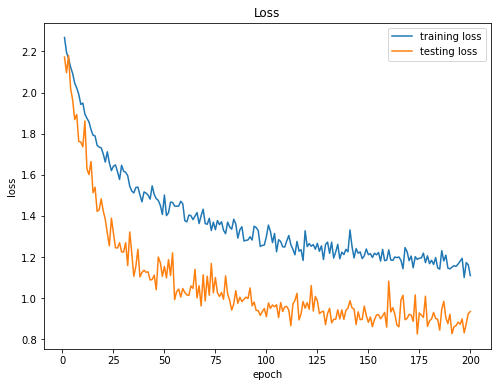

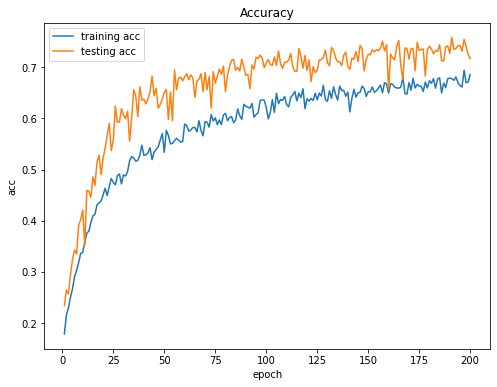

FOLD 5
--------------------------------
in_features: 1024
out_features: None
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=F

Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.15it/s]


Epoch:   1 / 200
	Training   Acc: 0.182696 | loss: 2.267479
	Validation Acc: 0.217375 | loss: 2.215010
[ Valid | 001/200 ] loss = 2.21501, acc = 0.21737 -> best
Saving model with acc 0.217


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.17it/s]


Epoch:   2 / 200
	Training   Acc: 0.214338 | loss: 2.203926
	Validation Acc: 0.220008 | loss: 2.193700
[ Valid | 002/200 ] loss = 2.19370, acc = 0.22001 -> best
Saving model with acc 0.220


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.01it/s]


Epoch:   3 / 200
	Training   Acc: 0.241062 | loss: 2.151090
	Validation Acc: 0.253855 | loss: 2.161996
[ Valid | 003/200 ] loss = 2.16200, acc = 0.25385 -> best
Saving model with acc 0.254


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.25it/s]


Epoch:   4 / 200
	Training   Acc: 0.261346 | loss: 2.104807
	Validation Acc: 0.332832 | loss: 1.923809
[ Valid | 004/200 ] loss = 1.92381, acc = 0.33283 -> best
Saving model with acc 0.333


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.34it/s]


Epoch:   5 / 200
	Training   Acc: 0.270830 | loss: 2.081075
	Validation Acc: 0.338097 | loss: 1.907188
[ Valid | 005/200 ] loss = 1.90719, acc = 0.33810 -> best
Saving model with acc 0.338


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.28it/s]


Epoch:   6 / 200
	Training   Acc: 0.298653 | loss: 2.030322
	Validation Acc: 0.341858 | loss: 1.857291
[ Valid | 006/200 ] loss = 1.85729, acc = 0.34186 -> best
Saving model with acc 0.342


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.03it/s]


Epoch:   7 / 200
	Training   Acc: 0.314831 | loss: 1.990753
	Validation Acc: 0.380970 | loss: 1.776696
[ Valid | 007/200 ] loss = 1.77670, acc = 0.38097 -> best
Saving model with acc 0.381


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.59it/s]


Epoch:   8 / 200
	Training   Acc: 0.335472 | loss: 1.949216
	Validation Acc: 0.432869 | loss: 1.708572
[ Valid | 008/200 ] loss = 1.70857, acc = 0.43287 -> best
Saving model with acc 0.433


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.18it/s]


Epoch:   9 / 200
	Training   Acc: 0.340853 | loss: 1.938083
	Validation Acc: 0.426476 | loss: 1.693479
[ Valid | 009/200 ] loss = 1.69348, acc = 0.42648


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.51it/s]


Epoch:  10 / 200
	Training   Acc: 0.345812 | loss: 1.938923
	Validation Acc: 0.395261 | loss: 1.762283
[ Valid | 010/200 ] loss = 1.76228, acc = 0.39526


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.46it/s]


Epoch:  11 / 200
	Training   Acc: 0.367870 | loss: 1.896523
	Validation Acc: 0.410305 | loss: 1.712528
[ Valid | 011/200 ] loss = 1.71253, acc = 0.41030


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.44it/s]


Epoch:  12 / 200
	Training   Acc: 0.377276 | loss: 1.871415
	Validation Acc: 0.496051 | loss: 1.537571
[ Valid | 012/200 ] loss = 1.53757, acc = 0.49605 -> best
Saving model with acc 0.496


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.44it/s]


Epoch:  13 / 200
	Training   Acc: 0.377530 | loss: 1.857710
	Validation Acc: 0.456187 | loss: 1.630682
[ Valid | 013/200 ] loss = 1.63068, acc = 0.45619


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.20it/s]


Epoch:  14 / 200
	Training   Acc: 0.397972 | loss: 1.811418
	Validation Acc: 0.459195 | loss: 1.576912
[ Valid | 014/200 ] loss = 1.57691, acc = 0.45920


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.47it/s]


Epoch:  15 / 200
	Training   Acc: 0.406257 | loss: 1.804237
	Validation Acc: 0.502068 | loss: 1.496189
[ Valid | 015/200 ] loss = 1.49619, acc = 0.50207 -> best
Saving model with acc 0.502


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.18it/s]


Epoch:  16 / 200
	Training   Acc: 0.418505 | loss: 1.779999
	Validation Acc: 0.453178 | loss: 1.597225
[ Valid | 016/200 ] loss = 1.59723, acc = 0.45318


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.55it/s]


Epoch:  17 / 200
	Training   Acc: 0.426762 | loss: 1.756714
	Validation Acc: 0.518616 | loss: 1.469232
[ Valid | 017/200 ] loss = 1.46923, acc = 0.51862 -> best
Saving model with acc 0.519


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.58it/s]


Epoch:  18 / 200
	Training   Acc: 0.433439 | loss: 1.736871
	Validation Acc: 0.516360 | loss: 1.447052
[ Valid | 018/200 ] loss = 1.44705, acc = 0.51636


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.33it/s]


Epoch:  19 / 200
	Training   Acc: 0.437658 | loss: 1.743767
	Validation Acc: 0.522377 | loss: 1.453850
[ Valid | 019/200 ] loss = 1.45385, acc = 0.52238 -> best
Saving model with acc 0.522


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.98it/s]


Epoch:  20 / 200
	Training   Acc: 0.452079 | loss: 1.701081
	Validation Acc: 0.543437 | loss: 1.366622
[ Valid | 020/200 ] loss = 1.36662, acc = 0.54344 -> best
Saving model with acc 0.543


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.96it/s]


Epoch:  21 / 200
	Training   Acc: 0.445914 | loss: 1.711962
	Validation Acc: 0.533659 | loss: 1.416109
[ Valid | 021/200 ] loss = 1.41611, acc = 0.53366


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.44it/s]


Epoch:  22 / 200
	Training   Acc: 0.446493 | loss: 1.712852
	Validation Acc: 0.567131 | loss: 1.331258
[ Valid | 022/200 ] loss = 1.33126, acc = 0.56713 -> best
Saving model with acc 0.567


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.24it/s]


Epoch:  23 / 200
	Training   Acc: 0.457330 | loss: 1.681603
	Validation Acc: 0.588191 | loss: 1.269422
[ Valid | 023/200 ] loss = 1.26942, acc = 0.58819 -> best
Saving model with acc 0.588


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.11it/s]


Epoch:  24 / 200
	Training   Acc: 0.468527 | loss: 1.651958
	Validation Acc: 0.511470 | loss: 1.440114
[ Valid | 024/200 ] loss = 1.44011, acc = 0.51147


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.44it/s]


Epoch:  25 / 200
	Training   Acc: 0.463678 | loss: 1.675306
	Validation Acc: 0.579541 | loss: 1.288382
[ Valid | 025/200 ] loss = 1.28838, acc = 0.57954


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.25it/s]


Epoch:  26 / 200
	Training   Acc: 0.467893 | loss: 1.647500
	Validation Acc: 0.577661 | loss: 1.293206
[ Valid | 026/200 ] loss = 1.29321, acc = 0.57766


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.25it/s]


Epoch:  27 / 200
	Training   Acc: 0.475323 | loss: 1.631418
	Validation Acc: 0.555848 | loss: 1.374274
[ Valid | 027/200 ] loss = 1.37427, acc = 0.55585


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.21it/s]


Epoch:  28 / 200
	Training   Acc: 0.481981 | loss: 1.621899
	Validation Acc: 0.579917 | loss: 1.288900
[ Valid | 028/200 ] loss = 1.28890, acc = 0.57992


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.19it/s]


Epoch:  29 / 200
	Training   Acc: 0.472479 | loss: 1.643686
	Validation Acc: 0.584806 | loss: 1.291325
[ Valid | 029/200 ] loss = 1.29133, acc = 0.58481


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.73it/s]


Epoch:  30 / 200
	Training   Acc: 0.487503 | loss: 1.616835
	Validation Acc: 0.593456 | loss: 1.258517
[ Valid | 030/200 ] loss = 1.25852, acc = 0.59346 -> best
Saving model with acc 0.593


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.10it/s]


Epoch:  31 / 200
	Training   Acc: 0.505941 | loss: 1.572054
	Validation Acc: 0.607747 | loss: 1.190632
[ Valid | 031/200 ] loss = 1.19063, acc = 0.60775 -> best
Saving model with acc 0.608


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.48it/s]


Epoch:  32 / 200
	Training   Acc: 0.502363 | loss: 1.570231
	Validation Acc: 0.612636 | loss: 1.193268
[ Valid | 032/200 ] loss = 1.19327, acc = 0.61264 -> best
Saving model with acc 0.613


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.19it/s]


Epoch:  33 / 200
	Training   Acc: 0.505908 | loss: 1.564238
	Validation Acc: 0.616397 | loss: 1.207211
[ Valid | 033/200 ] loss = 1.20721, acc = 0.61640 -> best
Saving model with acc 0.616


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.01it/s]


Epoch:  34 / 200
	Training   Acc: 0.515687 | loss: 1.545470
	Validation Acc: 0.576909 | loss: 1.279795
[ Valid | 034/200 ] loss = 1.27979, acc = 0.57691


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.40it/s]


Epoch:  35 / 200
	Training   Acc: 0.516106 | loss: 1.536777
	Validation Acc: 0.613765 | loss: 1.191559
[ Valid | 035/200 ] loss = 1.19156, acc = 0.61376


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.45it/s]


Epoch:  36 / 200
	Training   Acc: 0.499613 | loss: 1.580934
	Validation Acc: 0.614517 | loss: 1.218865
[ Valid | 036/200 ] loss = 1.21886, acc = 0.61452


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.30it/s]


Epoch:  37 / 200
	Training   Acc: 0.530310 | loss: 1.515843
	Validation Acc: 0.638586 | loss: 1.131375
[ Valid | 037/200 ] loss = 1.13137, acc = 0.63859 -> best
Saving model with acc 0.639


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.44it/s]


Epoch:  38 / 200
	Training   Acc: 0.524495 | loss: 1.529911
	Validation Acc: 0.620534 | loss: 1.177448
[ Valid | 038/200 ] loss = 1.17745, acc = 0.62053


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.21it/s]


Epoch:  39 / 200
	Training   Acc: 0.522439 | loss: 1.525395
	Validation Acc: 0.648740 | loss: 1.141151
[ Valid | 039/200 ] loss = 1.14115, acc = 0.64874 -> best
Saving model with acc 0.649


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.45it/s]


Epoch:  40 / 200
	Training   Acc: 0.533935 | loss: 1.507288
	Validation Acc: 0.638210 | loss: 1.153147
[ Valid | 040/200 ] loss = 1.15315, acc = 0.63821


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.28it/s]


Epoch:  41 / 200
	Training   Acc: 0.544702 | loss: 1.479319
	Validation Acc: 0.657390 | loss: 1.098614
[ Valid | 041/200 ] loss = 1.09861, acc = 0.65739 -> best
Saving model with acc 0.657


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.64it/s]


Epoch:  42 / 200
	Training   Acc: 0.559175 | loss: 1.425208
	Validation Acc: 0.656638 | loss: 1.078418
[ Valid | 042/200 ] loss = 1.07842, acc = 0.65664


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.39it/s]


Epoch:  43 / 200
	Training   Acc: 0.544158 | loss: 1.481989
	Validation Acc: 0.660775 | loss: 1.097716
[ Valid | 043/200 ] loss = 1.09772, acc = 0.66077 -> best
Saving model with acc 0.661


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.40it/s]


Epoch:  44 / 200
	Training   Acc: 0.534400 | loss: 1.501015
	Validation Acc: 0.654757 | loss: 1.134328
[ Valid | 044/200 ] loss = 1.13433, acc = 0.65476


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.43it/s]


Epoch:  45 / 200
	Training   Acc: 0.548304 | loss: 1.453610
	Validation Acc: 0.626175 | loss: 1.144778
[ Valid | 045/200 ] loss = 1.14478, acc = 0.62618


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.48it/s]


Epoch:  46 / 200
	Training   Acc: 0.546573 | loss: 1.475469
	Validation Acc: 0.649116 | loss: 1.148539
[ Valid | 046/200 ] loss = 1.14854, acc = 0.64912


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.98it/s]


Epoch:  47 / 200
	Training   Acc: 0.545074 | loss: 1.476136
	Validation Acc: 0.641971 | loss: 1.119479
[ Valid | 047/200 ] loss = 1.11948, acc = 0.64197


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.24it/s]


Epoch:  48 / 200
	Training   Acc: 0.544838 | loss: 1.482234
	Validation Acc: 0.625423 | loss: 1.172379
[ Valid | 048/200 ] loss = 1.17238, acc = 0.62542


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.27it/s]


Epoch:  49 / 200
	Training   Acc: 0.537905 | loss: 1.501299
	Validation Acc: 0.675442 | loss: 1.077714
[ Valid | 049/200 ] loss = 1.07771, acc = 0.67544 -> best
Saving model with acc 0.675


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.44it/s]


Epoch:  50 / 200
	Training   Acc: 0.560229 | loss: 1.442960
	Validation Acc: 0.663407 | loss: 1.076355
[ Valid | 050/200 ] loss = 1.07636, acc = 0.66341


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.24it/s]


Epoch:  51 / 200
	Training   Acc: 0.567160 | loss: 1.427967
	Validation Acc: 0.670177 | loss: 1.053629
[ Valid | 051/200 ] loss = 1.05363, acc = 0.67018


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.43it/s]


Epoch:  52 / 200
	Training   Acc: 0.571101 | loss: 1.408534
	Validation Acc: 0.659270 | loss: 1.115826
[ Valid | 052/200 ] loss = 1.11583, acc = 0.65927


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.40it/s]


Epoch:  53 / 200
	Training   Acc: 0.554043 | loss: 1.451828
	Validation Acc: 0.661151 | loss: 1.121017
[ Valid | 053/200 ] loss = 1.12102, acc = 0.66115


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.85it/s]


Epoch:  54 / 200
	Training   Acc: 0.548156 | loss: 1.472358
	Validation Acc: 0.662279 | loss: 1.090316
[ Valid | 054/200 ] loss = 1.09032, acc = 0.66228


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.11it/s]


Epoch:  55 / 200
	Training   Acc: 0.565820 | loss: 1.441340
	Validation Acc: 0.675442 | loss: 1.077340
[ Valid | 055/200 ] loss = 1.07734, acc = 0.67544


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.05it/s]


Epoch:  56 / 200
	Training   Acc: 0.571555 | loss: 1.414257
	Validation Acc: 0.679203 | loss: 1.035125
[ Valid | 056/200 ] loss = 1.03513, acc = 0.67920 -> best
Saving model with acc 0.679


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.10it/s]


Epoch:  57 / 200
	Training   Acc: 0.568637 | loss: 1.434590
	Validation Acc: 0.659270 | loss: 1.077407
[ Valid | 057/200 ] loss = 1.07741, acc = 0.65927


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.49it/s]


Epoch:  58 / 200
	Training   Acc: 0.574631 | loss: 1.406729
	Validation Acc: 0.654005 | loss: 1.131989
[ Valid | 058/200 ] loss = 1.13199, acc = 0.65401


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.27it/s]


Epoch:  59 / 200
	Training   Acc: 0.577583 | loss: 1.389460
	Validation Acc: 0.681083 | loss: 1.049868
[ Valid | 059/200 ] loss = 1.04987, acc = 0.68108 -> best
Saving model with acc 0.681


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.21it/s]


Epoch:  60 / 200
	Training   Acc: 0.571886 | loss: 1.413085
	Validation Acc: 0.664912 | loss: 1.081394
[ Valid | 060/200 ] loss = 1.08139, acc = 0.66491


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.29it/s]


Epoch:  61 / 200
	Training   Acc: 0.571618 | loss: 1.426907
	Validation Acc: 0.677698 | loss: 1.070994
[ Valid | 061/200 ] loss = 1.07099, acc = 0.67770


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.75it/s]


Epoch:  62 / 200
	Training   Acc: 0.598700 | loss: 1.341736
	Validation Acc: 0.619782 | loss: 1.150108
[ Valid | 062/200 ] loss = 1.15011, acc = 0.61978


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.84it/s]


Epoch:  63 / 200
	Training   Acc: 0.582797 | loss: 1.393180
	Validation Acc: 0.689357 | loss: 1.007796
[ Valid | 063/200 ] loss = 1.00780, acc = 0.68936 -> best
Saving model with acc 0.689


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.46it/s]


Epoch:  64 / 200
	Training   Acc: 0.597689 | loss: 1.338167
	Validation Acc: 0.639338 | loss: 1.164855
[ Valid | 064/200 ] loss = 1.16485, acc = 0.63934


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.47it/s]


Epoch:  65 / 200
	Training   Acc: 0.599121 | loss: 1.346234
	Validation Acc: 0.668296 | loss: 1.044227
[ Valid | 065/200 ] loss = 1.04423, acc = 0.66830


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.01it/s]


Epoch:  66 / 200
	Training   Acc: 0.595893 | loss: 1.348394
	Validation Acc: 0.644227 | loss: 1.112294
[ Valid | 066/200 ] loss = 1.11229, acc = 0.64423


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.19it/s]


Epoch:  67 / 200
	Training   Acc: 0.596370 | loss: 1.338980
	Validation Acc: 0.674314 | loss: 1.051309
[ Valid | 067/200 ] loss = 1.05131, acc = 0.67431


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.34it/s]


Epoch:  68 / 200
	Training   Acc: 0.593678 | loss: 1.368672
	Validation Acc: 0.684468 | loss: 1.044529
[ Valid | 068/200 ] loss = 1.04453, acc = 0.68447


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.60it/s]


Epoch:  69 / 200
	Training   Acc: 0.602009 | loss: 1.343525
	Validation Acc: 0.657766 | loss: 1.064706
[ Valid | 069/200 ] loss = 1.06471, acc = 0.65777


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.15it/s]


Epoch:  70 / 200
	Training   Acc: 0.591987 | loss: 1.359104
	Validation Acc: 0.707785 | loss: 0.981526
[ Valid | 070/200 ] loss = 0.98153, acc = 0.70778 -> best
Saving model with acc 0.708


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.14it/s]


Epoch:  71 / 200
	Training   Acc: 0.602617 | loss: 1.335612
	Validation Acc: 0.694998 | loss: 0.960055
[ Valid | 071/200 ] loss = 0.96005, acc = 0.69500


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.39it/s]


Epoch:  72 / 200
	Training   Acc: 0.585974 | loss: 1.385602
	Validation Acc: 0.682964 | loss: 1.023124
[ Valid | 072/200 ] loss = 1.02312, acc = 0.68296


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.21it/s]


Epoch:  73 / 200
	Training   Acc: 0.596818 | loss: 1.350165
	Validation Acc: 0.697255 | loss: 0.989280
[ Valid | 073/200 ] loss = 0.98928, acc = 0.69725


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:07<00:00,  5.67it/s]


Epoch:  74 / 200
	Training   Acc: 0.594218 | loss: 1.354604
	Validation Acc: 0.673561 | loss: 1.057975
[ Valid | 074/200 ] loss = 1.05797, acc = 0.67356


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.39it/s]


Epoch:  75 / 200
	Training   Acc: 0.619611 | loss: 1.300483
	Validation Acc: 0.686348 | loss: 1.042658
[ Valid | 075/200 ] loss = 1.04266, acc = 0.68635


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.38it/s]


Epoch:  76 / 200
	Training   Acc: 0.598235 | loss: 1.344241
	Validation Acc: 0.673185 | loss: 1.056668
[ Valid | 076/200 ] loss = 1.05667, acc = 0.67319


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.44it/s]


Epoch:  77 / 200
	Training   Acc: 0.596624 | loss: 1.358057
	Validation Acc: 0.665664 | loss: 1.042342
[ Valid | 077/200 ] loss = 1.04234, acc = 0.66566


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.54it/s]


Epoch:  78 / 200
	Training   Acc: 0.616366 | loss: 1.319408
	Validation Acc: 0.698007 | loss: 0.973560
[ Valid | 078/200 ] loss = 0.97356, acc = 0.69801


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch:  79 / 200
	Training   Acc: 0.615603 | loss: 1.309004
	Validation Acc: 0.693494 | loss: 1.056562
[ Valid | 079/200 ] loss = 1.05656, acc = 0.69349


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.15it/s]


Epoch:  80 / 200
	Training   Acc: 0.600508 | loss: 1.332020
	Validation Acc: 0.695750 | loss: 0.984630
[ Valid | 080/200 ] loss = 0.98463, acc = 0.69575


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.51it/s]


Epoch:  81 / 200
	Training   Acc: 0.623978 | loss: 1.285619
	Validation Acc: 0.685972 | loss: 0.997167
[ Valid | 081/200 ] loss = 0.99717, acc = 0.68597


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.64it/s]


Epoch:  82 / 200
	Training   Acc: 0.617527 | loss: 1.300486
	Validation Acc: 0.699511 | loss: 0.978540
[ Valid | 082/200 ] loss = 0.97854, acc = 0.69951


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.79it/s]


Epoch:  83 / 200
	Training   Acc: 0.619023 | loss: 1.314727
	Validation Acc: 0.719443 | loss: 0.973893
[ Valid | 083/200 ] loss = 0.97389, acc = 0.71944 -> best
Saving model with acc 0.719


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.33it/s]


Epoch:  84 / 200
	Training   Acc: 0.629137 | loss: 1.259425
	Validation Acc: 0.698007 | loss: 0.976185
[ Valid | 084/200 ] loss = 0.97619, acc = 0.69801


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.66it/s]


Epoch:  85 / 200
	Training   Acc: 0.602854 | loss: 1.350596
	Validation Acc: 0.658518 | loss: 1.062996
[ Valid | 085/200 ] loss = 1.06300, acc = 0.65852


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.71it/s]


Epoch:  86 / 200
	Training   Acc: 0.608097 | loss: 1.333355
	Validation Acc: 0.707785 | loss: 0.983390
[ Valid | 086/200 ] loss = 0.98339, acc = 0.70778


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.68it/s]


Epoch:  87 / 200
	Training   Acc: 0.616200 | loss: 1.300956
	Validation Acc: 0.695750 | loss: 0.992618
[ Valid | 087/200 ] loss = 0.99262, acc = 0.69575


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.94it/s]


Epoch:  88 / 200
	Training   Acc: 0.633267 | loss: 1.249470
	Validation Acc: 0.697255 | loss: 1.006205
[ Valid | 088/200 ] loss = 1.00620, acc = 0.69725


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.63it/s]


Epoch:  89 / 200
	Training   Acc: 0.625392 | loss: 1.282017
	Validation Acc: 0.696502 | loss: 1.004513
[ Valid | 089/200 ] loss = 1.00451, acc = 0.69650


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.88it/s]


Epoch:  90 / 200
	Training   Acc: 0.622095 | loss: 1.300778
	Validation Acc: 0.720572 | loss: 0.965648
[ Valid | 090/200 ] loss = 0.96565, acc = 0.72057 -> best
Saving model with acc 0.721


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.69it/s]


Epoch:  91 / 200
	Training   Acc: 0.620386 | loss: 1.307641
	Validation Acc: 0.688605 | loss: 0.998642
[ Valid | 091/200 ] loss = 0.99864, acc = 0.68860


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.84it/s]


Epoch:  92 / 200
	Training   Acc: 0.631566 | loss: 1.274070
	Validation Acc: 0.679203 | loss: 1.025291
[ Valid | 092/200 ] loss = 1.02529, acc = 0.67920


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.65it/s]


Epoch:  93 / 200
	Training   Acc: 0.632669 | loss: 1.271324
	Validation Acc: 0.681083 | loss: 1.020704
[ Valid | 093/200 ] loss = 1.02070, acc = 0.68108


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.45it/s]


Epoch:  94 / 200
	Training   Acc: 0.604529 | loss: 1.347645
	Validation Acc: 0.707785 | loss: 1.013915
[ Valid | 094/200 ] loss = 1.01391, acc = 0.70778


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.55it/s]


Epoch:  95 / 200
	Training   Acc: 0.631731 | loss: 1.254237
	Validation Acc: 0.708913 | loss: 0.909285
[ Valid | 095/200 ] loss = 0.90929, acc = 0.70891


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.02it/s]


Epoch:  96 / 200
	Training   Acc: 0.604664 | loss: 1.346238
	Validation Acc: 0.696126 | loss: 0.955151
[ Valid | 096/200 ] loss = 0.95515, acc = 0.69613


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch:  97 / 200
	Training   Acc: 0.640482 | loss: 1.244698
	Validation Acc: 0.696502 | loss: 0.979232
[ Valid | 097/200 ] loss = 0.97923, acc = 0.69650


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.44it/s]


Epoch:  98 / 200
	Training   Acc: 0.642527 | loss: 1.245528
	Validation Acc: 0.701768 | loss: 0.936111
[ Valid | 098/200 ] loss = 0.93611, acc = 0.70177


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.69it/s]


Epoch:  99 / 200
	Training   Acc: 0.624770 | loss: 1.300732
	Validation Acc: 0.688605 | loss: 1.016999
[ Valid | 099/200 ] loss = 1.01700, acc = 0.68860


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.97it/s]


Epoch: 100 / 200
	Training   Acc: 0.628253 | loss: 1.296618
	Validation Acc: 0.719819 | loss: 0.926288
[ Valid | 100/200 ] loss = 0.92629, acc = 0.71982


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.85it/s]


Epoch: 101 / 200
	Training   Acc: 0.626966 | loss: 1.268170
	Validation Acc: 0.710417 | loss: 0.968841
[ Valid | 101/200 ] loss = 0.96884, acc = 0.71042


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.55it/s]


Epoch: 102 / 200
	Training   Acc: 0.602373 | loss: 1.358825
	Validation Acc: 0.721324 | loss: 0.967106
[ Valid | 102/200 ] loss = 0.96711, acc = 0.72132 -> best
Saving model with acc 0.721


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.42it/s]


Epoch: 103 / 200
	Training   Acc: 0.606655 | loss: 1.341798
	Validation Acc: 0.727717 | loss: 0.919387
[ Valid | 103/200 ] loss = 0.91939, acc = 0.72772 -> best
Saving model with acc 0.728


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.70it/s]


Epoch: 104 / 200
	Training   Acc: 0.630452 | loss: 1.261141
	Validation Acc: 0.712298 | loss: 0.957829
[ Valid | 104/200 ] loss = 0.95783, acc = 0.71230


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.82it/s]


Epoch: 105 / 200
	Training   Acc: 0.626426 | loss: 1.271774
	Validation Acc: 0.729598 | loss: 0.913421
[ Valid | 105/200 ] loss = 0.91342, acc = 0.72960 -> best
Saving model with acc 0.730


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.51it/s]


Epoch: 106 / 200
	Training   Acc: 0.624387 | loss: 1.290238
	Validation Acc: 0.701392 | loss: 0.950251
[ Valid | 106/200 ] loss = 0.95025, acc = 0.70139


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.73it/s]


Epoch: 107 / 200
	Training   Acc: 0.627200 | loss: 1.279030
	Validation Acc: 0.723956 | loss: 0.964764
[ Valid | 107/200 ] loss = 0.96476, acc = 0.72396


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.82it/s]


Epoch: 108 / 200
	Training   Acc: 0.624344 | loss: 1.297141
	Validation Acc: 0.733358 | loss: 0.896419
[ Valid | 108/200 ] loss = 0.89642, acc = 0.73336 -> best
Saving model with acc 0.733


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.87it/s]


Epoch: 109 / 200
	Training   Acc: 0.626889 | loss: 1.284965
	Validation Acc: 0.720196 | loss: 0.948853
[ Valid | 109/200 ] loss = 0.94885, acc = 0.72020


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.55it/s]


Epoch: 110 / 200
	Training   Acc: 0.646236 | loss: 1.231697
	Validation Acc: 0.678074 | loss: 1.029495
[ Valid | 110/200 ] loss = 1.02950, acc = 0.67807


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.65it/s]


Epoch: 111 / 200
	Training   Acc: 0.640404 | loss: 1.245201
	Validation Acc: 0.710794 | loss: 0.941169
[ Valid | 111/200 ] loss = 0.94117, acc = 0.71079


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.78it/s]


Epoch: 112 / 200
	Training   Acc: 0.629753 | loss: 1.256694
	Validation Acc: 0.728093 | loss: 0.913675
[ Valid | 112/200 ] loss = 0.91367, acc = 0.72809


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.61it/s]


Epoch: 113 / 200
	Training   Acc: 0.641696 | loss: 1.259502
	Validation Acc: 0.723204 | loss: 0.933965
[ Valid | 113/200 ] loss = 0.93396, acc = 0.72320


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.81it/s]


Epoch: 114 / 200
	Training   Acc: 0.626418 | loss: 1.294162
	Validation Acc: 0.722828 | loss: 0.952171
[ Valid | 114/200 ] loss = 0.95217, acc = 0.72283


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.93it/s]


Epoch: 115 / 200
	Training   Acc: 0.634700 | loss: 1.270344
	Validation Acc: 0.714930 | loss: 0.990218
[ Valid | 115/200 ] loss = 0.99022, acc = 0.71493


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.18it/s]


Epoch: 116 / 200
	Training   Acc: 0.632810 | loss: 1.274265
	Validation Acc: 0.718691 | loss: 0.976323
[ Valid | 116/200 ] loss = 0.97632, acc = 0.71869


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.80it/s]


Epoch: 117 / 200
	Training   Acc: 0.632800 | loss: 1.274991
	Validation Acc: 0.722828 | loss: 0.945840
[ Valid | 117/200 ] loss = 0.94584, acc = 0.72283


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.59it/s]


Epoch: 118 / 200
	Training   Acc: 0.615958 | loss: 1.309113
	Validation Acc: 0.717187 | loss: 0.953803
[ Valid | 118/200 ] loss = 0.95380, acc = 0.71719


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.86it/s]


Epoch: 119 / 200
	Training   Acc: 0.633341 | loss: 1.261631
	Validation Acc: 0.720196 | loss: 0.912986
[ Valid | 119/200 ] loss = 0.91299, acc = 0.72020


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.68it/s]


Epoch: 120 / 200
	Training   Acc: 0.639901 | loss: 1.253199
	Validation Acc: 0.731854 | loss: 0.884600
[ Valid | 120/200 ] loss = 0.88460, acc = 0.73185


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.63it/s]


Epoch: 121 / 200
	Training   Acc: 0.646543 | loss: 1.236550
	Validation Acc: 0.705152 | loss: 0.941144
[ Valid | 121/200 ] loss = 0.94114, acc = 0.70515


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.84it/s]


Epoch: 122 / 200
	Training   Acc: 0.637884 | loss: 1.258119
	Validation Acc: 0.685220 | loss: 1.024187
[ Valid | 122/200 ] loss = 1.02419, acc = 0.68522


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.01it/s]


Epoch: 123 / 200
	Training   Acc: 0.651211 | loss: 1.215780
	Validation Acc: 0.725085 | loss: 0.927913
[ Valid | 123/200 ] loss = 0.92791, acc = 0.72508


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.04it/s]


Epoch: 124 / 200
	Training   Acc: 0.632586 | loss: 1.275487
	Validation Acc: 0.720196 | loss: 0.947214
[ Valid | 124/200 ] loss = 0.94721, acc = 0.72020


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.97it/s]


Epoch: 125 / 200
	Training   Acc: 0.643265 | loss: 1.242400
	Validation Acc: 0.731854 | loss: 0.875985
[ Valid | 125/200 ] loss = 0.87598, acc = 0.73185


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.17it/s]


Epoch: 126 / 200
	Training   Acc: 0.632011 | loss: 1.264912
	Validation Acc: 0.696879 | loss: 0.991436
[ Valid | 126/200 ] loss = 0.99144, acc = 0.69688


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.81it/s]


Epoch: 127 / 200
	Training   Acc: 0.650000 | loss: 1.231324
	Validation Acc: 0.715307 | loss: 0.950806
[ Valid | 127/200 ] loss = 0.95081, acc = 0.71531


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.85it/s]


Epoch: 128 / 200
	Training   Acc: 0.671666 | loss: 1.168059
	Validation Acc: 0.726213 | loss: 0.909935
[ Valid | 128/200 ] loss = 0.90993, acc = 0.72621


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.43it/s]


Epoch: 129 / 200
	Training   Acc: 0.670252 | loss: 1.182114
	Validation Acc: 0.721324 | loss: 0.925344
[ Valid | 129/200 ] loss = 0.92534, acc = 0.72132


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.87it/s]


Epoch: 130 / 200
	Training   Acc: 0.662812 | loss: 1.195280
	Validation Acc: 0.684092 | loss: 1.007034
[ Valid | 130/200 ] loss = 1.00703, acc = 0.68409


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.76it/s]


Epoch: 131 / 200
	Training   Acc: 0.632044 | loss: 1.269631
	Validation Acc: 0.718691 | loss: 0.920162
[ Valid | 131/200 ] loss = 0.92016, acc = 0.71869


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.77it/s]


Epoch: 132 / 200
	Training   Acc: 0.653065 | loss: 1.235506
	Validation Acc: 0.721700 | loss: 0.930712
[ Valid | 132/200 ] loss = 0.93071, acc = 0.72170


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.67it/s]


Epoch: 133 / 200
	Training   Acc: 0.671505 | loss: 1.171004
	Validation Acc: 0.740880 | loss: 0.865673
[ Valid | 133/200 ] loss = 0.86567, acc = 0.74088 -> best
Saving model with acc 0.741


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.71it/s]


Epoch: 134 / 200
	Training   Acc: 0.630226 | loss: 1.276508
	Validation Acc: 0.691613 | loss: 1.001655
[ Valid | 134/200 ] loss = 1.00165, acc = 0.69161


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.88it/s]


Epoch: 135 / 200
	Training   Acc: 0.644411 | loss: 1.232863
	Validation Acc: 0.737495 | loss: 0.890004
[ Valid | 135/200 ] loss = 0.89000, acc = 0.73750


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.43it/s]


Epoch: 136 / 200
	Training   Acc: 0.657087 | loss: 1.214261
	Validation Acc: 0.704024 | loss: 0.981214
[ Valid | 136/200 ] loss = 0.98121, acc = 0.70402


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.04it/s]


Epoch: 137 / 200
	Training   Acc: 0.647972 | loss: 1.243964
	Validation Acc: 0.722828 | loss: 0.914809
[ Valid | 137/200 ] loss = 0.91481, acc = 0.72283


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.91it/s]


Epoch: 138 / 200
	Training   Acc: 0.645251 | loss: 1.237028
	Validation Acc: 0.704024 | loss: 0.984677
[ Valid | 138/200 ] loss = 0.98468, acc = 0.70402


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.59it/s]


Epoch: 139 / 200
	Training   Acc: 0.653997 | loss: 1.207704
	Validation Acc: 0.724709 | loss: 0.906210
[ Valid | 139/200 ] loss = 0.90621, acc = 0.72471


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.66it/s]


Epoch: 140 / 200
	Training   Acc: 0.653016 | loss: 1.217348
	Validation Acc: 0.716435 | loss: 0.927451
[ Valid | 140/200 ] loss = 0.92745, acc = 0.71643


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.70it/s]


Epoch: 141 / 200
	Training   Acc: 0.643230 | loss: 1.249837
	Validation Acc: 0.715683 | loss: 0.937544
[ Valid | 141/200 ] loss = 0.93754, acc = 0.71568


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.13it/s]


Epoch: 142 / 200
	Training   Acc: 0.644574 | loss: 1.247698
	Validation Acc: 0.720196 | loss: 0.947345
[ Valid | 142/200 ] loss = 0.94734, acc = 0.72020


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.43it/s]


Epoch: 143 / 200
	Training   Acc: 0.667185 | loss: 1.167732
	Validation Acc: 0.705528 | loss: 0.925855
[ Valid | 143/200 ] loss = 0.92586, acc = 0.70553


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.66it/s]


Epoch: 144 / 200
	Training   Acc: 0.658954 | loss: 1.207829
	Validation Acc: 0.706281 | loss: 0.944305
[ Valid | 144/200 ] loss = 0.94430, acc = 0.70628


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.67it/s]


Epoch: 145 / 200
	Training   Acc: 0.664209 | loss: 1.189590
	Validation Acc: 0.737119 | loss: 0.889779
[ Valid | 145/200 ] loss = 0.88978, acc = 0.73712


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.36it/s]


Epoch: 146 / 200
	Training   Acc: 0.638445 | loss: 1.262215
	Validation Acc: 0.733734 | loss: 0.891534
[ Valid | 146/200 ] loss = 0.89153, acc = 0.73373


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.21it/s]


Epoch: 147 / 200
	Training   Acc: 0.659626 | loss: 1.207115
	Validation Acc: 0.691237 | loss: 1.000476
[ Valid | 147/200 ] loss = 1.00048, acc = 0.69124


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.63it/s]


Epoch: 148 / 200
	Training   Acc: 0.653299 | loss: 1.208620
	Validation Acc: 0.733734 | loss: 0.881703
[ Valid | 148/200 ] loss = 0.88170, acc = 0.73373


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.58it/s]


Epoch: 149 / 200
	Training   Acc: 0.653624 | loss: 1.210193
	Validation Acc: 0.729598 | loss: 0.935715
[ Valid | 149/200 ] loss = 0.93571, acc = 0.72960


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.74it/s]


Epoch: 150 / 200
	Training   Acc: 0.644129 | loss: 1.243430
	Validation Acc: 0.726589 | loss: 0.923563
[ Valid | 150/200 ] loss = 0.92356, acc = 0.72659


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.85it/s]


Epoch: 151 / 200
	Training   Acc: 0.666410 | loss: 1.163150
	Validation Acc: 0.727717 | loss: 0.899883
[ Valid | 151/200 ] loss = 0.89988, acc = 0.72772


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.78it/s]


Epoch: 152 / 200
	Training   Acc: 0.663190 | loss: 1.192127
	Validation Acc: 0.715683 | loss: 0.933689
[ Valid | 152/200 ] loss = 0.93369, acc = 0.71568


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.56it/s]


Epoch: 153 / 200
	Training   Acc: 0.665680 | loss: 1.180869
	Validation Acc: 0.729222 | loss: 0.915998
[ Valid | 153/200 ] loss = 0.91600, acc = 0.72922


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.93it/s]


Epoch: 154 / 200
	Training   Acc: 0.654288 | loss: 1.220410
	Validation Acc: 0.742008 | loss: 0.868996
[ Valid | 154/200 ] loss = 0.86900, acc = 0.74201 -> best
Saving model with acc 0.742


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.94it/s]


Epoch: 155 / 200
	Training   Acc: 0.675094 | loss: 1.156171
	Validation Acc: 0.735615 | loss: 0.883863
[ Valid | 155/200 ] loss = 0.88386, acc = 0.73561


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.87it/s]


Epoch: 156 / 200
	Training   Acc: 0.663761 | loss: 1.196613
	Validation Acc: 0.707785 | loss: 0.949623
[ Valid | 156/200 ] loss = 0.94962, acc = 0.70778


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.45it/s]


Epoch: 157 / 200
	Training   Acc: 0.647837 | loss: 1.233829
	Validation Acc: 0.726589 | loss: 0.913256
[ Valid | 157/200 ] loss = 0.91326, acc = 0.72659


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.72it/s]


Epoch: 158 / 200
	Training   Acc: 0.641200 | loss: 1.233395
	Validation Acc: 0.715683 | loss: 0.941057
[ Valid | 158/200 ] loss = 0.94106, acc = 0.71568


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.03it/s]


Epoch: 159 / 200
	Training   Acc: 0.640727 | loss: 1.244433
	Validation Acc: 0.716059 | loss: 0.954150
[ Valid | 159/200 ] loss = 0.95415, acc = 0.71606


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  7.00it/s]


Epoch: 160 / 200
	Training   Acc: 0.665566 | loss: 1.176745
	Validation Acc: 0.729598 | loss: 0.932384
[ Valid | 160/200 ] loss = 0.93238, acc = 0.72960


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.80it/s]


Epoch: 161 / 200
	Training   Acc: 0.652572 | loss: 1.226345
	Validation Acc: 0.739376 | loss: 0.869032
[ Valid | 161/200 ] loss = 0.86903, acc = 0.73938


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.42it/s]


Epoch: 162 / 200
	Training   Acc: 0.668588 | loss: 1.187830
	Validation Acc: 0.740504 | loss: 0.909102
[ Valid | 162/200 ] loss = 0.90910, acc = 0.74050


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.79it/s]


Epoch: 163 / 200
	Training   Acc: 0.662394 | loss: 1.194106
	Validation Acc: 0.713802 | loss: 0.928394
[ Valid | 163/200 ] loss = 0.92839, acc = 0.71380


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.35it/s]


Epoch: 164 / 200
	Training   Acc: 0.665898 | loss: 1.181312
	Validation Acc: 0.735615 | loss: 0.911445
[ Valid | 164/200 ] loss = 0.91145, acc = 0.73561


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.05it/s]


Epoch: 165 / 200
	Training   Acc: 0.648643 | loss: 1.231781
	Validation Acc: 0.697631 | loss: 0.957130
[ Valid | 165/200 ] loss = 0.95713, acc = 0.69763


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.89it/s]


Epoch: 166 / 200
	Training   Acc: 0.667664 | loss: 1.176003
	Validation Acc: 0.737119 | loss: 0.924560
[ Valid | 166/200 ] loss = 0.92456, acc = 0.73712


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.67it/s]


Epoch: 167 / 200
	Training   Acc: 0.688750 | loss: 1.123701
	Validation Acc: 0.735239 | loss: 0.907092
[ Valid | 167/200 ] loss = 0.90709, acc = 0.73524


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.04it/s]


Epoch: 168 / 200
	Training   Acc: 0.651704 | loss: 1.220439
	Validation Acc: 0.735615 | loss: 0.860553
[ Valid | 168/200 ] loss = 0.86055, acc = 0.73561


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.76it/s]


Epoch: 169 / 200
	Training   Acc: 0.650673 | loss: 1.230221
	Validation Acc: 0.740880 | loss: 0.877029
[ Valid | 169/200 ] loss = 0.87703, acc = 0.74088


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.76it/s]


Epoch: 170 / 200
	Training   Acc: 0.693359 | loss: 1.115208
	Validation Acc: 0.743889 | loss: 0.871593
[ Valid | 170/200 ] loss = 0.87159, acc = 0.74389 -> best
Saving model with acc 0.744


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.85it/s]


Epoch: 171 / 200
	Training   Acc: 0.643827 | loss: 1.231636
	Validation Acc: 0.729598 | loss: 0.912691
[ Valid | 171/200 ] loss = 0.91269, acc = 0.72960


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.05it/s]


Epoch: 172 / 200
	Training   Acc: 0.659925 | loss: 1.206912
	Validation Acc: 0.742760 | loss: 0.929212
[ Valid | 172/200 ] loss = 0.92921, acc = 0.74276


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.68it/s]


Epoch: 173 / 200
	Training   Acc: 0.657668 | loss: 1.205366
	Validation Acc: 0.727341 | loss: 0.920083
[ Valid | 173/200 ] loss = 0.92008, acc = 0.72734


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.92it/s]


Epoch: 174 / 200
	Training   Acc: 0.674765 | loss: 1.162811
	Validation Acc: 0.729222 | loss: 0.894737
[ Valid | 174/200 ] loss = 0.89474, acc = 0.72922


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.12it/s]


Epoch: 175 / 200
	Training   Acc: 0.672864 | loss: 1.164183
	Validation Acc: 0.706281 | loss: 0.936595
[ Valid | 175/200 ] loss = 0.93660, acc = 0.70628


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.97it/s]


Epoch: 176 / 200
	Training   Acc: 0.648878 | loss: 1.221650
	Validation Acc: 0.698383 | loss: 1.004655
[ Valid | 176/200 ] loss = 1.00466, acc = 0.69838


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.53it/s]


Epoch: 177 / 200
	Training   Acc: 0.658358 | loss: 1.198837
	Validation Acc: 0.757804 | loss: 0.872768
[ Valid | 177/200 ] loss = 0.87277, acc = 0.75780 -> best
Saving model with acc 0.758


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.56it/s]


Epoch: 178 / 200
	Training   Acc: 0.654541 | loss: 1.222728
	Validation Acc: 0.745393 | loss: 0.849062
[ Valid | 178/200 ] loss = 0.84906, acc = 0.74539


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.20it/s]


Epoch: 179 / 200
	Training   Acc: 0.653099 | loss: 1.216004
	Validation Acc: 0.735239 | loss: 0.897858
[ Valid | 179/200 ] loss = 0.89786, acc = 0.73524


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.41it/s]


Epoch: 180 / 200
	Training   Acc: 0.666048 | loss: 1.189296
	Validation Acc: 0.732606 | loss: 0.886281
[ Valid | 180/200 ] loss = 0.88628, acc = 0.73261


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.70it/s]


Epoch: 181 / 200
	Training   Acc: 0.683878 | loss: 1.145737
	Validation Acc: 0.729598 | loss: 0.907009
[ Valid | 181/200 ] loss = 0.90701, acc = 0.72960


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  7.00it/s]


Epoch: 182 / 200
	Training   Acc: 0.674031 | loss: 1.166965
	Validation Acc: 0.734487 | loss: 0.912326
[ Valid | 182/200 ] loss = 0.91233, acc = 0.73449


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.88it/s]


Epoch: 183 / 200
	Training   Acc: 0.643921 | loss: 1.242496
	Validation Acc: 0.733734 | loss: 0.850570
[ Valid | 183/200 ] loss = 0.85057, acc = 0.73373


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.99it/s]


Epoch: 184 / 200
	Training   Acc: 0.652634 | loss: 1.207315
	Validation Acc: 0.751786 | loss: 0.874548
[ Valid | 184/200 ] loss = 0.87455, acc = 0.75179


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.81it/s]


Epoch: 185 / 200
	Training   Acc: 0.681303 | loss: 1.136214
	Validation Acc: 0.734863 | loss: 0.880522
[ Valid | 185/200 ] loss = 0.88052, acc = 0.73486


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.14it/s]


Epoch: 186 / 200
	Training   Acc: 0.677994 | loss: 1.149890
	Validation Acc: 0.739752 | loss: 0.877716
[ Valid | 186/200 ] loss = 0.87772, acc = 0.73975


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.54it/s]


Epoch: 187 / 200
	Training   Acc: 0.675396 | loss: 1.159557
	Validation Acc: 0.743137 | loss: 0.865604
[ Valid | 187/200 ] loss = 0.86560, acc = 0.74314


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.67it/s]


Epoch: 188 / 200
	Training   Acc: 0.677480 | loss: 1.164776
	Validation Acc: 0.732982 | loss: 0.903687
[ Valid | 188/200 ] loss = 0.90369, acc = 0.73298


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.01it/s]


Epoch: 189 / 200
	Training   Acc: 0.664213 | loss: 1.187293
	Validation Acc: 0.743513 | loss: 0.860167
[ Valid | 189/200 ] loss = 0.86017, acc = 0.74351


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.57it/s]


Epoch: 190 / 200
	Training   Acc: 0.659261 | loss: 1.210416
	Validation Acc: 0.740880 | loss: 0.957615
[ Valid | 190/200 ] loss = 0.95761, acc = 0.74088


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.49it/s]


Epoch: 191 / 200
	Training   Acc: 0.676362 | loss: 1.167886
	Validation Acc: 0.725085 | loss: 0.936325
[ Valid | 191/200 ] loss = 0.93632, acc = 0.72508


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.39it/s]


Epoch: 192 / 200
	Training   Acc: 0.663030 | loss: 1.196967
	Validation Acc: 0.734111 | loss: 0.918059
[ Valid | 192/200 ] loss = 0.91806, acc = 0.73411


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.96it/s]


Epoch: 193 / 200
	Training   Acc: 0.671797 | loss: 1.160274
	Validation Acc: 0.733734 | loss: 0.879038
[ Valid | 193/200 ] loss = 0.87904, acc = 0.73373


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.97it/s]


Epoch: 194 / 200
	Training   Acc: 0.659694 | loss: 1.197114
	Validation Acc: 0.726213 | loss: 0.915442
[ Valid | 194/200 ] loss = 0.91544, acc = 0.72621


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.01it/s]


Epoch: 195 / 200
	Training   Acc: 0.678887 | loss: 1.155872
	Validation Acc: 0.739000 | loss: 0.877430
[ Valid | 195/200 ] loss = 0.87743, acc = 0.73900


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.79it/s]


Epoch: 196 / 200
	Training   Acc: 0.648122 | loss: 1.229879
	Validation Acc: 0.748778 | loss: 0.872481
[ Valid | 196/200 ] loss = 0.87248, acc = 0.74878


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.37it/s]


Epoch: 197 / 200
	Training   Acc: 0.676018 | loss: 1.164484
	Validation Acc: 0.737495 | loss: 0.868076
[ Valid | 197/200 ] loss = 0.86808, acc = 0.73750


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.87it/s]


Epoch: 198 / 200
	Training   Acc: 0.669744 | loss: 1.172154
	Validation Acc: 0.742760 | loss: 0.870740
[ Valid | 198/200 ] loss = 0.87074, acc = 0.74276


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.74it/s]


Epoch: 199 / 200
	Training   Acc: 0.653335 | loss: 1.228981
	Validation Acc: 0.738624 | loss: 0.930557
[ Valid | 199/200 ] loss = 0.93056, acc = 0.73862


Valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.59it/s]


Epoch: 200 / 200
	Training   Acc: 0.657938 | loss: 1.214824
	Validation Acc: 0.723956 | loss: 0.951071
[ Valid | 200/200 ] loss = 0.95107, acc = 0.72396


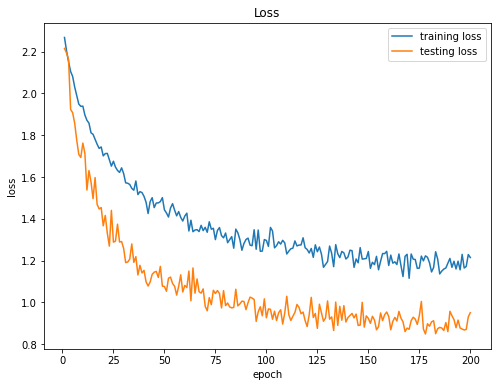

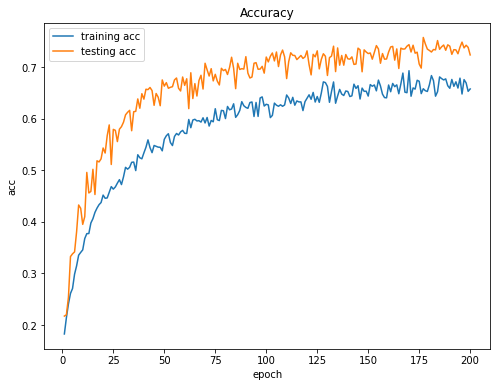

In [19]:
if config['k_folds'] > 0:
    k_fold_perf = {}
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(dataset)):
        print(f"FOLD {fold+1}")
        print("--------------------------------")
        
        # Sample elements randomly from a given list of idx, no replacement.
        train_subsampler = SubsetRandomSampler(train_idx)
        valid_subsampler = SubsetRandomSampler(valid_idx)

        # Define data loaders for training and validation data in this fold
        train_loader = DataLoader(dataset, batch_size=config['batch_size'], sampler=train_subsampler, num_workers=4, pin_memory=True)
        valid_loader = DataLoader(dataset, batch_size=config['batch_size'], sampler=valid_subsampler, num_workers=4, pin_memory=True)
        
        
        # Init the neural network
        model = get_specific_model(config, **config['classifier_paras'])
        model.apply(reset_weights)
        print_model(model, train_loader)

        config['save_path'] = f"./models/model-googlenet-fold-{fold+1}.ckpt"
        train_acc, train_loss, valid_acc, valid_loss = trainer(train_loader, valid_loader, model, config, device)

        plot_figure(train_acc, train_loss, valid_acc, valid_loss, config['n_epochs'])
        # best_index = train_acc.index(max(valid_acc))
        k_fold_perf[f"fold-{fold+1}"] = {
            'Train Acc': train_acc, 
            'Train Loss': train_loss, 
            'Valid Acc': valid_acc, 
            'Valid Loss': valid_loss
        }

        del train_loader, valid_loader, model
        gc.collect()
else:
    model = get_specific_model(config, **config['classifier_paras'])
    model.apply(reset_weights)
    print_model(model, train_loader)
    train_acc, train_loss, valid_acc, valid_loss = trainer(train_loader, valid_loader, model, config, device)
    del train_loader, valid_loader, model
    gc.collect()

# Plot the results

fold-1: Best acc: 0.754511, loss: 0.829246
------------------------------------------


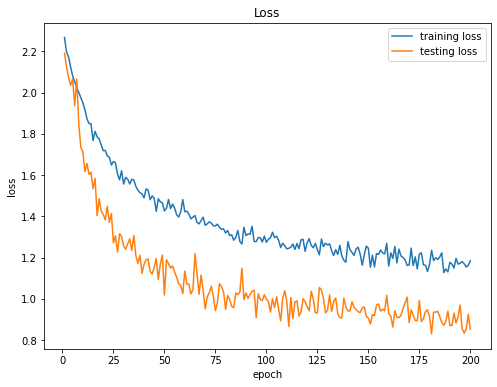

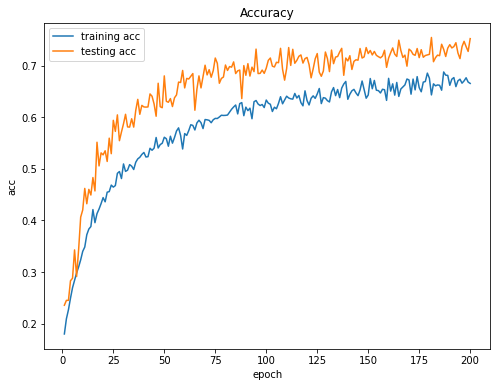

fold-2: Best acc: 0.751786, loss: 0.862233
------------------------------------------


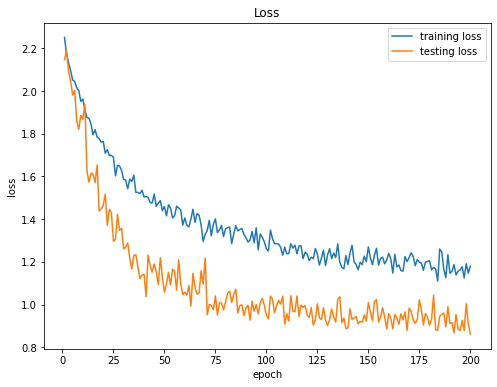

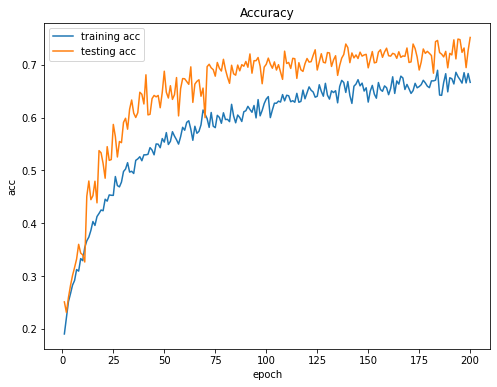

fold-3: Best acc: 0.752162, loss: 0.839204
------------------------------------------


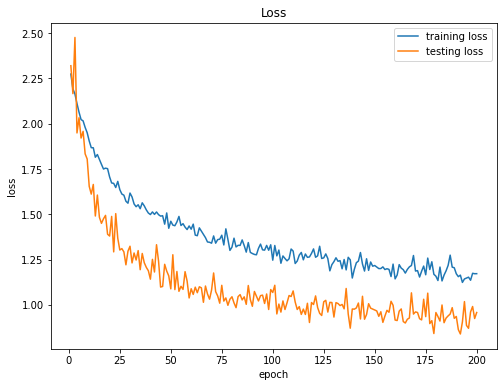

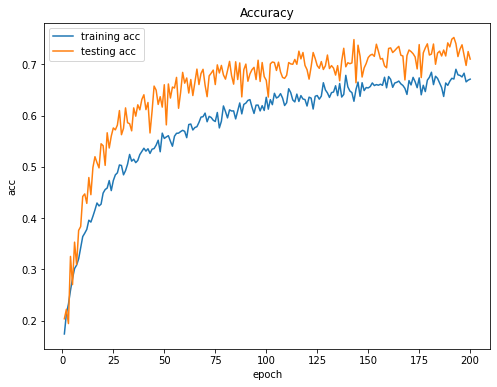

fold-4: Best acc: 0.757804, loss: 0.827258
------------------------------------------


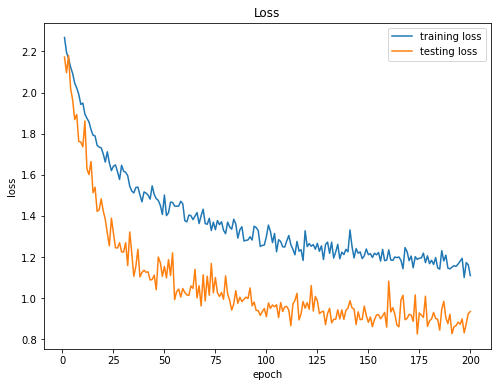

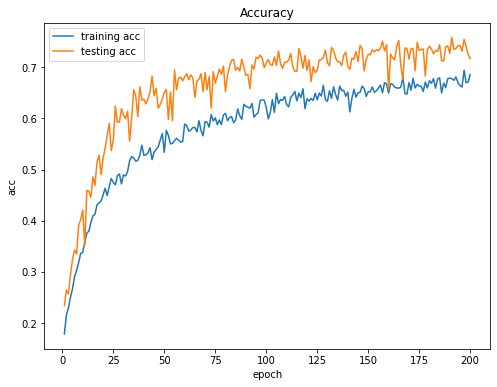

fold-5: Best acc: 0.757804, loss: 0.872768
------------------------------------------


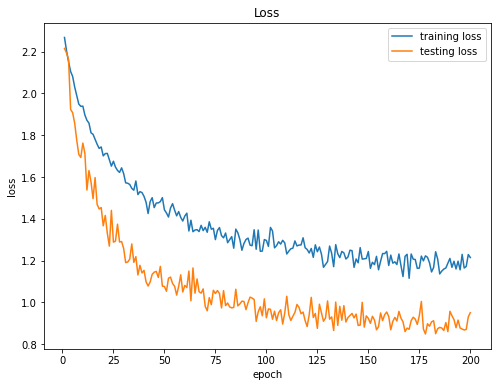

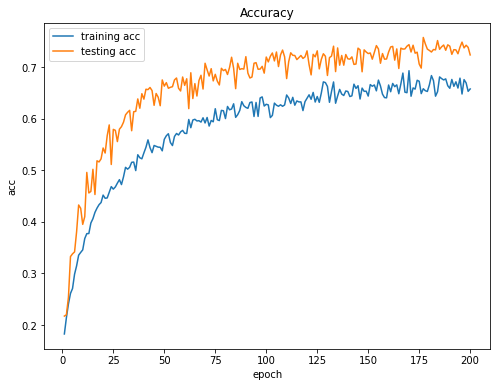

In [21]:
if config['k_folds'] > 0:
    for key, value in k_fold_perf.items():
        best_index = value['Valid Acc'].index(max(value['Valid Acc']))
        print(f"{key}: Best acc: {value['Valid Acc'][best_index]:>7f}, loss: {value['Valid Loss'][best_index]:>7f}")
        print("------------------------------------------")
        plot_figure(*value.values(), config['n_epochs'])        # Pass train_acc, train_loss, valid_acc, valid_loss, epoch
else:
    best_index = valid_acc.index(max(valid_acc))
    print(f"Best acc: {valid_acc[best_index]:>7f}, loss: {valid_loss[best_index]:>7f}")
    plot_figure(train_acc, train_loss, valid_acc, valid_loss, config['n_epochs'])

# Predict (Soft-Voting / Test Time Augmention / Default)

In [22]:
kwargs = {
    'alpha': 0.5, 
    'numAugment': 5,
    'test_tfm': test_tfm,
    'test_aug_tfm': train_tfm
}
if config['k_folds'] > 0:
    model_backbone = ["googlenet"]
    model_list = []
    for backbone in model_backbone:
        model_list += [f"./models/model-{backbone}-fold-{i+1}.ckpt" for i in range(config['k_folds'])]
    prediction = ensemble_soft_voting(config, model_list=model_list, classes=11, **kwargs)
else:
    
    model_best = get_specific_model(config, **config['classifier_paras'])
    model_best.load_state_dict(torch.load(config['save_path']))
    
    if config['TTA']:
        prediction = test_time_augmentation(config, model_best, classes=11, **kwargs)
    else:
        test_set = FoodDataset(os.path.join(_dataset_dir, "test"), tfm=test_tfm)
        test_loader = DataLoader(test_set, batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)
        model_best.eval()
        prediction = []
        with torch.no_grad():
            for data,_ in test_loader:
                test_pred = model_best(data.to(device))
                test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
                prediction += test_label.squeeze().tolist()

One ./food11/test sample ./food11/test/0001.jpg
in_features: 1024
out_features: None
One ./food11/test sample ./food11/test/0001.jpg


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:14<00:00,  3.76it/s]


[9 9 0 ... 0 2 4]
One ./food11/test sample ./food11/test/0001.jpg


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  6.63it/s]


in_features: 1024
out_features: None
One ./food11/test sample ./food11/test/0001.jpg


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.55it/s]


[2 9 0 ... 0 2 4]
One ./food11/test sample ./food11/test/0001.jpg


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  6.64it/s]


in_features: 1024
out_features: None
One ./food11/test sample ./food11/test/0001.jpg


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:06<00:00,  8.18it/s]


[9 9 3 ... 0 2 4]
One ./food11/test sample ./food11/test/0001.jpg


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  6.44it/s]


in_features: 1024
out_features: None
One ./food11/test sample ./food11/test/0001.jpg


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:06<00:00,  7.99it/s]


[9 9 0 ... 0 2 4]
One ./food11/test sample ./food11/test/0001.jpg


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:08<00:00,  6.51it/s]


in_features: 1024
out_features: None
One ./food11/test sample ./food11/test/0001.jpg


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  7.53it/s]


[2 9 0 ... 0 2 4]
One ./food11/test sample ./food11/test/0001.jpg


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:07<00:00,  6.66it/s]


In [23]:
for p in prediction:
    print(p)

2
9
0
2
3
9
4
9
5
9
9
0
3
2
5
3
9
10
2
5
9
10
10
5
2
2
10
2
3
4
2
5
9
5
5
3
10
9
10
0
5
3
5
5
0
0
6
4
5
5
2
0
3
10
0
3
2
5
3
2
5
0
4
9
8
2
5
2
0
9
5
3
2
8
0
0
9
0
10
1
9
9
6
2
2
5
0
0
4
5
8
9
9
3
3
10
8
1
4
5
9
5
4
9
8
0
1
0
5
4
2
6
0
0
6
7
0
9
9
3
7
5
0
4
2
5
5
2
10
9
5
2
2
9
9
5
9
9
9
5
4
0
5
4
8
5
4
0
4
5
5
8
5
7
1
5
4
8
9
9
6
6
5
9
9
5
2
2
5
9
9
2
3
0
6
9
8
5
2
2
1
5
2
8
2
8
0
3
8
3
2
9
2
4
8
9
2
10
9
9
6
2
2
4
10
0
4
8
7
5
5
5
0
9
8
9
9
3
9
2
8
9
9
5
4
1
2
7
2
4
5
4
2
4
4
0
6
1
0
5
5
2
10
4
6
10
0
10
0
3
8
2
4
2
4
8
2
8
3
5
2
7
5
10
10
3
0
6
0
9
2
8
2
9
9
5
10
10
10
5
5
6
3
5
8
2
0
10
4
2
8
1
0
9
7
5
4
2
2
8
9
2
9
10
5
9
5
2
2
5
8
5
2
2
0
10
8
5
1
3
9
9
9
0
3
9
0
7
5
10
5
10
5
10
2
9
6
9
0
3
1
9
10
10
2
10
0
3
2
5
5
2
10
9
6
0
3
0
9
2
4
5
7
4
1
2
1
10
2
2
5
9
4
8
9
2
2
1
8
8
0
9
8
4
0
9
3
4
6
8
5
10
2
5
3
2
5
9
7
3
9
2
8
5
5
1
2
2
8
3
10
2
5
9
5
9
0
4
3
2
9
4
6
5
0
7
2
4
5
3
8
9
3
3
4
3
10
3
2
0
9
10
0
2
6
9
5
4
3
9
2
3
9
3
1
2
8
9
6
7
0
4
9
3
9
2
2
5
9
9
10
2
9
4
4
2
5
5
0
10
5
1

# Write the predictions in CSV

In [24]:
#create test csv
def pad4(i):
    return "0" * (4-len(str(i))) + str(i)

df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(1, len(prediction)+1)]
df["Category"] = prediction
df.to_csv("prediction.csv", index=False)

# Q1. Augmentation Implementation
## Implement augmentation by finishing train_tfm in the code with image size of your choice. 
## Directly copy the following block and paste it on GradeScope after you finish the code
### Your train_tfm must be capable of producing 5+ different results when given an identical image multiple times.
### Your  train_tfm in the report can be different from train_tfm in your training code.


In [ ]:
# Policies for autoaugmentation
policies = [transforms.AutoAugmentPolicy.CIFAR10, transforms.AutoAugmentPolicy.IMAGENET]
augmenters = [transforms.AutoAugment(policy) for policy in policies]

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    # Use autoaugment
    *augmenters,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Test
fname = './food11/training/0_100.jpg'
im = Image.open(fname)
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(151 + i)
    trans_im = train_tfm(im).permute(1, 2, 0)
    plt.imshow(trans_im)

# Q2. Residual Implementation
![](https://i.imgur.com/GYsq1Ap.png)
## Directly copy the following block and paste it on GradeScope after you finish the code


In [3]:
from torch import nn
class Residual_Network(nn.Module):
    def __init__(self, input_dim, output_dim, prob=0.2):
        super(Residual_Network, self).__init__()
        
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
        )

        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
        )

        self.cnn_layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
        )

        self.cnn_layer4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
        )
        self.cnn_layer5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
        )
        self.cnn_layer6 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(256 * 32 * 32, 256),
            nn.ReLU(),
            nn.Linear(256, 11)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x1 = self.cnn_layer1(x)
        
        x1 = self.relu(x1)
        
        x2 = self.cnn_layer2(x1)
        
        x2 += x1
        
        x2 = self.relu(x2)
        
        x3 = self.cnn_layer3(x2)
        
        x3 = self.relu(x3)
        
        x4 = self.cnn_layer4(x3)
        
        x4 += x3
        
        x4 = self.relu(x4)
        
        x5 = self.cnn_layer5(x4)
        
        x5 = self.relu(x5)
        
        x6 = self.cnn_layer6(x5)
        
        x6 += x5
        
        x6 = self.relu(x6)
        
        # The extracted feature map must be flatten before going to fully-connected layers.
        xout = x6.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        xout = self.fc_layer(xout)
        return xout